### NHS project: Diagnostic Analysis using Python

This project used real NHS data but is a fictional scenario. I created this project for a course assignment and so was given business questions to answer. I used the three data files I was provided with, as well as some other data sets I downloaded from the NHS website to help with my analysis.

### Context

NHS England want to find out whether there is adequate staff and capacity in their networks and how they utilise resources. They need to know this so they know how to utilise their budget and whether they need to increase their capacity or increase the efficiency of their current use of resources. It’s also useful for them to know whether the capacity and utilisation of resources differs across regions, months and seasons, and days of the week so that they can potentially apply different solutions depending on the context. As the NHS frequently struggles to work within the budget set by the UK government, it is crucial that they can use their budget as effectively as possible so patients receive the best care as possible. I particularly need to analyse how many and which appointments were attended, how long it takes between booking and the appointment, the capacity across the country, and whether certain settings are at a better capacity than others.

Main questions:

1. Has there been adequate staff and capacity in the networks? 
2. What was the actual utilisation of resources?


I used a loose version of the 5 whys structured thinking framework to ask myself progressively deeper questions about this problem. This revealed limitations and gaps in the data as I knew that I didn't have all the information I needed to answer some of the questions. For example, "what is the maximum capacity?" led to the question "how many staff are there in the networks?" then "how many staff are needed in the networks?" (which I don't have the data to answer). Also, starting with "what is the maximum capacity?" led to "how many appointments have there been?" and "what is the duration of these appointments?" but these then led to questions I couldn't answer like "how much time do appointments take up in total and is this over maximum capacity?", "are these appointments too long for what the patient came in for?, and "how many patients have had an appointments where one wasn't needed?".

Note that there are many limitations with the data, such as are stated in the meta data text file.

The NHS has given a figure of 1.2 million appointments per day as a guideline for maximum capacity. However, not all practices and registered patients are included in the data collection. 95.6% of practices are included and of these, 96.4% of registered patients are included. I've assumed that the 96.4% of patients is of the practices included in the collection and not of all practices as this makes the most sense as certain practices didn't give any data. I would have checked this assumption with the NHS if I was able. 

Therefore I wil use 1,105,900 as a guideline for maximum capacity (rounded down as rounding up would exceed the maximum capacity).

Max capacity = 1,200,00 * 0.956 * 0.964 = 1,105,900.8 (rounded down to 1,105,900)

I am taking "maximum guideline for capacity" to mean that this is the maximum number of appointments that the NHS thinks it can give. However, it's important to note that if they are completing more appointments than their max capacity, surely this means that they can go over this number? Also, it may not be a positive result if the number of appointments that are being booked are significantly under this max capacity as it may mean that they are wasting their resources in GP practices, where these could perhaps be better used elsewhere (such as in hospitals) or that people are unable to book or attend appointments.

It is also important to note that they have provided a guideline for the maximum number of appointments NOT taking into account the length of these apppintments. For example, 1.105 million appointments that are less than 10 minutes will presumably not put as much strain on the NHS as 1.105 million 30 minute appointments. This is an important limitation.

### Import libraries

In [6]:
# Import the necessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Ignore warnings.
import warnings
warnings.filterwarnings('ignore')

### Create functions

In [8]:
# Validate the data function.
def validate_data(df):
    # Check the data types.
    data_types = df.dtypes
    print("Data types:")
    print(data_types)

    # Check the data shape.
    data_shape = df.shape
    print("Data shape:")
    print(data_shape)
    
    # Check for unique values
    unique_counts = df.nunique()
    print("Unique values per column:")
    print(unique_counts)
    
    # Check for duplicates
    duplicate_count = df.duplicated().sum()
    print("\nNumber of duplicate rows:")
    print(duplicate_count)
    
    # Summary statistics
    summary_stats = df.describe()
    print("\nSummary statistics:")
    print(summary_stats)
    
    return data_types, data_shape, unique_counts, duplicate_count, summary_stats

In [9]:
# Standard vertical bar chart function.
def standard_vertical_bar_chart(df, x, y, title="Bar Chart", x_label=None, y_label=None, 
                                figsize=(10,6), legend_title=None, hline_y=None, **kwargs):
  
    plt.figure(figsize=figsize)
    sns.barplot(data=df, x=x, y=y, **kwargs)

    # Get the axes so that the legend part of this function works.
    ax = plt.gca()

    # Plot the title, x and y labels, and rotate the x axis labels.
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation=45)

    # Add a legend if there are handles.
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        plt.legend(handles, labels, title=legend_title, loc="upper left", bbox_to_anchor=(1, 1))

    # Plot a maximum capacity line.
    if hline_y is not None:
        plt.axhline(y=hline_y, color='r', linestyle=':', label='Maximum capacity')
        plt.legend()
   
    plt.tight_layout()

    # Save the figure using the title of the plot.
    clean_title = re.sub(r'[^\w\s-]', '', title.replace("\n", " ")).strip().replace(' ', '_').lower()
    filename = f"{clean_title}.png"
    
    plt.savefig(filename, dpi=500, bbox_inches="tight")
    
    plt.show()

In [10]:
# Standard horizontal bar chart function.
def standard_horizontal_bar_chart(df, x, y, title="Bar Chart", x_label=None, y_label=None, 
                                  figsize=(10,6), legend_title=None, **kwargs):
    
    plt.figure(figsize=figsize)
    sns.barplot(data=df, x=y, y=x, **kwargs)

    # Get the axes so that the legend part of this function works.
    ax = plt.gca()

    # Plot the title and the x and y labels.
    plt.title(title)
    plt.xlabel(y_label)
    plt.ylabel(x_label)
    plt.xticks(rotation=0)

    # Add a legend if there are handles.
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        plt.legend(handles, labels, title=legend_title, loc="upper left", bbox_to_anchor=(1, 1))

    plt.tight_layout()

    # Save the figure using the title of the plot.
    clean_title = re.sub(r'[^\w\s-]', '', title.replace("\n", " ")).strip().replace(' ', '_').lower()
    filename = f"{clean_title}.png"
    
    plt.savefig(filename, dpi=500, bbox_inches="tight")
    
    plt.show()

In [11]:
# Box plot function.
def standard_box_plot(df, x, y, title="Boxplot", x_label=None, y_label=None, figsize=(10,6), **kwargs):
  
    plt.figure(figsize=figsize)
    sns.boxplot(data=df, x=x, y=y, **kwargs)

    # Plot the title, x and y labels, and rotate the x axis labels.
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save the figure using the title of the plot.
    clean_title = re.sub(r'[^\w\s-]', '', title.replace("\n", " ")).strip().replace(' ', '_').lower()
    filename = f"{clean_title}.png"
    
    plt.savefig(filename, dpi=500, bbox_inches="tight")
    
    plt.show()

In [12]:
# Line plot function 
def standard_line_plot(df, x, y, title="Line Plot", x_label=None, y_label=None, 
                       figsize=(10,6), y_limit=None, hline_y=None, **kwargs):

    plt.figure(figsize=figsize)
    sns.lineplot(data=df, x=x, y=y, **kwargs)

    # Plot the title, x and y labels, rotate the x axis labels, and plot the legend in the top left ouside the chart.
    plt.title(title)
    plt.xlabel(y_label)
    plt.ylabel(x_label)
    plt.xticks(rotation=45)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

    
    # Set an adjustable y axis size (needed for some plots for the max capacity line to be seen.
    if y_limit:
        plt.ylim(y_limit)

    # Plot the maximum capacity line.
    if hline_y is not None:
        plt.axhline(y=hline_y, color='r', linestyle=':', label='Maximum capacity')
        plt.legend()
    
    plt.tight_layout()

    # Save the figure using the title of the plot.
    clean_title = re.sub(r'[^\w\s-]', '', title.replace("\n", " ")).strip().replace(' ', '_').lower()
    filename = f"{clean_title}.png"
    
    plt.savefig(filename, dpi=500, bbox_inches="tight")
    
    plt.show()

In [13]:
# Time series plot function.
def time_series_plot_with_trendline(df, time_col, value_col, title="Time Series Plot with Trendline", 
                                    x_label=None, y_label=None, hline_y=None, figsize=(12,6), **kwargs):
    
    # Sort DataFrame by the time column
    df.sort_values(by=time_col, inplace=True)
    
    # Calculate trendline
    x = np.arange(len(df))
    y = df[value_col].values
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    
    plt.figure(figsize=figsize)
    
    # Plot the time series
    sns.lineplot(data=df, x=time_col, y=value_col, label='Observed')
    
    # Plot the trendline
    plt.plot(df[time_col], p(x), linestyle='--', color='purple', label='Trendline')

    # Plot max capacity line.
    if hline_y is not None:
        plt.axhline(y=hline_y, color='r', linestyle=':', label='Maximum Capacity')
    
    # Plot the title, x and y labels, rotate the x axis labels, and plot the legend in the top left ouside the chart.
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()

    # Save the figure using the title of the plot.
    clean_title = re.sub(r'[^\w\s-]', '', title.replace("\n", " ")).strip().replace(' ', '_').lower()
    filename = f"{clean_title}.png"
    
    plt.savefig(filename, dpi=500, bbox_inches="tight")
    
    plt.show()

### Loading data

Prior to loading the data into Jupyter, I converted any xlsx files to csv files as xlsx files tend to take longer to load.

20222122_number_patients_registered_per_region.csv was taken from NHS data at https://digital.nhs.uk/data-and-information/publications/statistical/patients-registered-at-a-gp-practice . I took data every 6 months from June 2020 to June 2022, joined these data sets together, used find and replace on the ICB codes so I could have a "region" column, deleted columns that weren't required, and added month and year columns.

111_calls.csv was taken from NHS data at https://digital.nhs.uk/services/nhs-pathways/nhs-pathways-service-information/monthly-triage-data/archived-monthly-triage-data/2022-archived-monthly-triage-data/111-nhs-pathways-monthly-triage-data---june-2022  and  https://digital.nhs.uk/services/nhs-pathways/nhs-pathways-service-information/monthly-triage-data/archived-monthly-triage-data/2021-archived-monthly-triage-data/111-nhs-pathways-monthly-triage-data---june-2021 . I only used data from July 2020 as the data before then isn't in Excel format so doesnt give the data per month.

NHS_workforce_totals.csv was taken from NHS data at https://digital.nhs.uk/data-and-information/publications/statistical/patients-registered-at-a-gp-practice. This included all NHS staff, not just those at GP practices ans I couldn't find a list of just those who worked at GP practices. I removed some data that I knew I didn't need (ambulance staff and NHS infrastructure support such as managers and staff who deal with property and estates) but had to leave everyone else in the dataset, eventhough lots of these people will work at hospitals, not at GP practices.

In [16]:
# Load actual duration data.
ad = pd.read_csv('actual_duration.csv')

# Load appointments regional data.
ar = pd.read_csv('appointments_regional.csv')

# Load national categories data.
nc = pd.read_csv('national_categories.csv')

# Load number of patients registered per region data.
prpr = pd.read_csv('20202122_number_patients_registered_per_region.csv')

# Load 111 calls data.
one11 = pd.read_csv('111_calls.csv')

# Load NHS workforce data.
wf = pd.read_csv('NHS_workforce_totals.csv')

In [17]:
# Reviewing head() and tail() of ad.
ad.head()
ad.tail()

sub_icb_location_code sub_icb_location_ons_code  \
137788                 X2C4Y                 E38000254   
137789                 X2C4Y                 E38000254   
137790                 X2C4Y                 E38000254   
137791                 X2C4Y                 E38000254   
137792                 X2C4Y                 E38000254   

                 sub_icb_location_name icb_ons_code region_ons_code  \
137788  NHS West Yorkshire ICB - X2C4Y    E54000054       E40000012   
137789  NHS West Yorkshire ICB - X2C4Y    E54000054       E40000012   
137790  NHS West Yorkshire ICB - X2C4Y    E54000054       E40000012   
137791  NHS West Yorkshire ICB - X2C4Y    E54000054       E40000012   
137792  NHS West Yorkshire ICB - X2C4Y    E54000054       E40000012   

       appointment_date actual_duration  count_of_appointments  
137788        30-Jun-22   31-60 Minutes                    430  
137789        30-Jun-22   21-30 Minutes                    751  
137790        30-Jun-22   16-20 Minutes                    921  
137791        30-Jun-22   11-15 Minutes                   1439  
137792        30-Jun-22     1-5 Minutes                   1739

In [18]:
# Reviewing head() and tail() of ar.
ar.head()
ar.tail()

icb_ons_code appointment_month appointment_status hcp_type  \
596816    E54000050           2022-06            Unknown  Unknown   
596817    E54000050           2022-06            Unknown  Unknown   
596818    E54000050           2022-06            Unknown  Unknown   
596819    E54000050           2022-06            Unknown  Unknown   
596820    E54000050           2022-06            Unknown  Unknown   

       appointment_mode time_between_book_and_appointment  \
596816          Unknown                       2 to 7 Days   
596817          Unknown                    22  to 28 Days   
596818          Unknown                     8  to 14 Days   
596819          Unknown                 More than 28 Days   
596820          Unknown                          Same Day   

        count_of_appointments  
596816                     21  
596817                      8  
596818                     28  
596819                     17  
596820                     10

In [19]:
# Reviewing head() and tail() of nc.
nc.head()
nc.tail()

appointment_date icb_ons_code           sub_icb_location_name  \
817389       30/06/2022    E54000054  NHS West Yorkshire ICB - X2C4Y   
817390       30/06/2022    E54000054  NHS West Yorkshire ICB - X2C4Y   
817391       30/06/2022    E54000054  NHS West Yorkshire ICB - X2C4Y   
817392       30/06/2022    E54000054  NHS West Yorkshire ICB - X2C4Y   
817393       30/06/2022    E54000054  NHS West Yorkshire ICB - X2C4Y   

                  service_setting            context_type  \
817389  Extended Access Provision  Care Related Encounter   
817390  Extended Access Provision  Care Related Encounter   
817391  Extended Access Provision  Care Related Encounter   
817392  Extended Access Provision  Care Related Encounter   
817393  Extended Access Provision  Care Related Encounter   

                   national_category  count_of_appointments appointment_month  
817389   Unplanned Clinical Activity                     12           2022-06  
817390               Planned Clinics                      4           2022-06  
817391    Planned Clinical Procedure                     92           2022-06  
817392  General Consultation Routine                      4           2022-06  
817393    General Consultation Acute                     19           2022-06

In [20]:
# Reviewing head() and tail() of prpr.
prpr.head()
prpr.tail()

month_year           region  patients_total
30    2022-06  East of England         7106121
31    2021-12  East of England         7073995
32    2021-06  East of England         7022099
33    2020-12  East of England         6974308
34    2020-06  East of England         6948061

In [21]:
# Reviewing head() and tail() of one11.
one11.head()
one11.tail()

month_year month  year  count_111_triages  Unnamed: 4
19    2022-02   Feb  2022            1159507         NaN
20    2022-03   Mar  2022            1364499         NaN
21    2022-04   Apr  2022            1476155         NaN
22    2022-05   May  2022            1454204         NaN
23    2022-06   Jun  2022            1505813         NaN

I chose to drop the "unnamed" columns here so that I'll probably not get any nulls when verifying my data.

In [23]:
# Drop "Unnamed: 4" column.
one11.drop('Unnamed: 4', axis=1, inplace=True)
one11.head()

month_year month  year  count_111_triages
0    2020-07   Jul  2020            1248152
1    2020-08   Aug  2020            1404175
2    2020-09   Sep  2020            1402720
3    2020-10   Oct  2020            1339519
4    2020-11   Nov  2020            1279294

In [24]:
# Reviewing the head() and tail() of wf.
wf.head()
wf.tail()

month_year month  year  staff_total  Unnamed: 4  Unnamed: 5  Unnamed: 6
25    2022-02   Feb  2022      1269954         NaN         NaN         NaN
26    2022-03   Mar  2022      1272425         NaN         NaN         NaN
27    2022-04   Apr  2022      1267514         NaN         NaN         NaN
28    2022-05   May  2022      1269724         NaN         NaN         NaN
29    2022-06   Jun  2022      1269267         NaN         NaN         NaN

In [25]:
# Drop unnamed columns.
wf.drop(['Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6'], axis=1, inplace=True)
wf.head()

month_year month  year  staff_total
0    2020-01   Jan  2020      1178573
1    2020-02   Feb  2020      1182326
2    2020-03   Mar  2020      1189414
3    2020-04   Apr  2020      1202179
4    2020-05   May  2020      1211884

### Validating and cleaning the data

#### ad

In [28]:
validate_data(ad)

Data types:
sub_icb_location_code        object
sub_icb_location_ons_code    object
sub_icb_location_name        object
icb_ons_code                 object
region_ons_code              object
appointment_date             object
actual_duration              object
count_of_appointments         int64
dtype: object
Data shape:
(137793, 8)
Unique values per column:
sub_icb_location_code         106
sub_icb_location_ons_code     106
sub_icb_location_name         106
icb_ons_code                   42
region_ons_code                 7
appointment_date              212
actual_duration                 7
count_of_appointments        7611
dtype: int64

Number of duplicate rows:
0

Summary statistics:
       count_of_appointments
count          137793.000000
mean             1219.080011
std              1546.902956
min                 1.000000
25%               194.000000
50%               696.000000
75%              1621.000000
max             15400.000000


(sub_icb_location_code        object
 sub_icb_location_ons_code    object
 sub_icb_location_name        object
 icb_ons_code                 object
 region_ons_code              object
 appointment_date             object
 actual_duration              object
 count_of_appointments         int64
 dtype: object,
 (137793, 8),
 sub_icb_location_code         106
 sub_icb_location_ons_code     106
 sub_icb_location_name         106
 icb_ons_code                   42
 region_ons_code                 7
 appointment_date              212
 actual_duration                 7
 count_of_appointments        7611
 dtype: int64,
 0,
        count_of_appointments
 count          137793.000000
 mean             1219.080011
 std              1546.902956
 min                 1.000000
 25%               194.000000
 50%               696.000000
 75%              1621.000000
 max             15400.000000)

Notes:
- appointment_date will need to be changed to datetime.
- I'll add extra year and month columns.
- No duplicated rows.
- Min and max appointment counts are expected values for this data so don't need to remove outliers.

In [30]:
# Check for missing values.
ad.isna().sum()

sub_icb_location_code        0
sub_icb_location_ons_code    0
sub_icb_location_name        0
icb_ons_code                 0
region_ons_code              0
appointment_date             0
actual_duration              0
count_of_appointments        0
dtype: int64

There are no missing values.

In [32]:
# Change "Unknown / Data Quality" in the "actual_duration" column to "Unknnown".
ad["actual_duration"] = ad["actual_duration"].replace('Unknown / Data Quality', 'Unknown')
ad["actual_duration"].unique()

array(['31-60 Minutes', '21-30 Minutes', '6-10 Minutes', 'Unknown',
       '16-20 Minutes', '11-15 Minutes', '1-5 Minutes'], dtype=object)

In [33]:
# Convert appointment_date to datetime format.
ad['appointment_date'] = pd.to_datetime(ad['appointment_date'], format="%d-%b-%y")
ad.dtypes

sub_icb_location_code                object
sub_icb_location_ons_code            object
sub_icb_location_name                object
icb_ons_code                         object
region_ons_code                      object
appointment_date             datetime64[ns]
actual_duration                      object
count_of_appointments                 int64
dtype: object

In [34]:
# Create separate year and month columns.
ad['month'] = ad['appointment_date'].dt.month
ad['year'] = ad['appointment_date'].dt.year

ad.head(5)

sub_icb_location_code sub_icb_location_ons_code  \
0                   00L                 E38000130   
1                   00L                 E38000130   
2                   00L                 E38000130   
3                   00L                 E38000130   
4                   00L                 E38000130   

                        sub_icb_location_name icb_ons_code region_ons_code  \
0  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
1  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
2  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
3  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
4  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   

  appointment_date actual_duration  count_of_appointments  month  year  
0       2021-12-01   31-60 Minutes                    364     12  2021  
1       2021-12-01   21-30 Minutes                    619     12  2021  
2       2021-12-01    6-10 Minutes                   1698     12  2021  
3       2021-12-01         Unknown                   1277     12  2021  
4       2021-12-01   16-20 Minutes                    730     12  2021

In [35]:
# Convert numeric month to short month name in the "month" column.
ad["month"] = pd.to_datetime(ad["month"], format='%m').dt.strftime('%b')
ad.head(5)

sub_icb_location_code sub_icb_location_ons_code  \
0                   00L                 E38000130   
1                   00L                 E38000130   
2                   00L                 E38000130   
3                   00L                 E38000130   
4                   00L                 E38000130   

                        sub_icb_location_name icb_ons_code region_ons_code  \
0  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
1  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
2  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
3  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
4  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   

  appointment_date actual_duration  count_of_appointments month  year  
0       2021-12-01   31-60 Minutes                    364   Dec  2021  
1       2021-12-01   21-30 Minutes                    619   Dec  2021  
2       2021-12-01    6-10 Minutes                   1698   Dec  2021  
3       2021-12-01         Unknown                   1277   Dec  2021  
4       2021-12-01   16-20 Minutes                    730   Dec  2021

In [36]:
# Reorder the columns so the most important columns are towards the left.
ad = pd.DataFrame(ad, columns=['icb_ons_code', 'sub_icb_location_code', 'sub_icb_location_name',
                                               'appointment_date', 'year', 'month', 'actual_duration', 'count_of_appointments',
                                               'region_ons_code', 'sub_icb_location_ons_code'])
ad.head(5)

icb_ons_code sub_icb_location_code  \
0    E54000050                   00L   
1    E54000050                   00L   
2    E54000050                   00L   
3    E54000050                   00L   
4    E54000050                   00L   

                        sub_icb_location_name appointment_date  year month  \
0  NHS North East and North Cumbria ICB - 00L       2021-12-01  2021   Dec   
1  NHS North East and North Cumbria ICB - 00L       2021-12-01  2021   Dec   
2  NHS North East and North Cumbria ICB - 00L       2021-12-01  2021   Dec   
3  NHS North East and North Cumbria ICB - 00L       2021-12-01  2021   Dec   
4  NHS North East and North Cumbria ICB - 00L       2021-12-01  2021   Dec   

  actual_duration  count_of_appointments region_ons_code  \
0   31-60 Minutes                    364       E40000012   
1   21-30 Minutes                    619       E40000012   
2    6-10 Minutes                   1698       E40000012   
3         Unknown                   1277       E40000012   
4   16-20 Minutes                    730       E40000012   

  sub_icb_location_ons_code  
0                 E38000130  
1                 E38000130  
2                 E38000130  
3                 E38000130  
4                 E38000130

Check that all the values in the columns are formatted correctly e.g. no spelling/grammatical mistakes, capatilisation correct etc.

In [38]:
ad['icb_ons_code'].unique()

array(['E54000050', 'E54000048', 'E54000057', 'E54000008', 'E54000061',
       'E54000060', 'E54000054', 'E54000051', 'E54000015', 'E54000010',
       'E54000056', 'E54000025', 'E54000023', 'E54000026', 'E54000053',
       'E54000044', 'E54000042', 'E54000041', 'E54000043', 'E54000036',
       'E54000038', 'E54000039', 'E54000055', 'E54000058', 'E54000037',
       'E54000019', 'E54000022', 'E54000031', 'E54000013', 'E54000030',
       'E54000059', 'E54000032', 'E54000052', 'E54000040', 'E54000028',
       'E54000029', 'E54000018', 'E54000062', 'E54000034', 'E54000024',
       'E54000011', 'E54000027'], dtype=object)

In [39]:
ad['sub_icb_location_code'].unique()

array(['00L', '00N', '00P', '00Q', '00R', '00T', '00V', '00X', '00Y',
       '01A', '01D', '01E', '01F', '01G', '01H', '01J', '01K', '01T',
       '01V', '01W', '01X', '01Y', '02A', '02E', '02G', '02H', '02M',
       '02P', '02Q', '02T', '02X', '02Y', '03F', '03H', '03K', '03L',
       '03N', '03Q', '03R', '03W', '04C', '04V', '04Y', '05D', '05G',
       '05Q', '05V', '05W', '06H', '06K', '06L', '06N', '06Q', '06T',
       '07G', '07H', '07K', '09D', '10Q', '10R', '11J', '11M', '11N',
       '11X', '12F', '13T', '14L', '14Y', '15A', '15C', '15E', '15F',
       '15M', '15N', '16C', '18C', '26A', '27D', '36J', '36L', '42D',
       '52R', '70F', '71E', '72Q', '78H', '84H', '91Q', '92A', '92G',
       '93C', '97R', '99A', '99C', '99E', '99F', '99G', 'A3A8R', 'B2M3M',
       'D2P2L', 'D4U1Y', 'D9Y0V', 'M1J4Y', 'M2L0M', 'W2U3Z', 'X2C4Y'],
      dtype=object)

In [40]:
ad['sub_icb_location_name'].unique()

array(['NHS North East and North Cumbria ICB - 00L',
       'NHS North East and North Cumbria ICB - 00N',
       'NHS North East and North Cumbria ICB - 00P',
       'NHS Lancashire and South Cumbria ICB - 00Q',
       'NHS Lancashire and South Cumbria ICB - 00R',
       'NHS Greater Manchester ICB - 00T',
       'NHS Greater Manchester ICB - 00V',
       'NHS Lancashire and South Cumbria ICB - 00X',
       'NHS Greater Manchester ICB - 00Y',
       'NHS Lancashire and South Cumbria ICB - 01A',
       'NHS Greater Manchester ICB - 01D',
       'NHS Lancashire and South Cumbria ICB - 01E',
       'NHS Cheshire and Merseyside ICB - 01F',
       'NHS Greater Manchester ICB - 01G',
       'NHS North East and North Cumbria ICB - 01H',
       'NHS Cheshire and Merseyside ICB - 01J',
       'NHS Lancashire and South Cumbria ICB - 01K',
       'NHS Cheshire and Merseyside ICB - 01T',
       'NHS Cheshire and Merseyside ICB - 01V',
       'NHS Greater Manchester ICB - 01W',
       'NHS Cheshire

In [41]:
ad['appointment_date'].unique()

<DatetimeArray>
['2021-12-01 00:00:00', '2021-12-02 00:00:00', '2021-12-03 00:00:00',
 '2021-12-04 00:00:00', '2021-12-06 00:00:00', '2021-12-07 00:00:00',
 '2021-12-08 00:00:00', '2021-12-09 00:00:00', '2021-12-10 00:00:00',
 '2021-12-11 00:00:00',
 ...
 '2022-02-06 00:00:00', '2022-02-13 00:00:00', '2022-02-20 00:00:00',
 '2022-03-06 00:00:00', '2022-04-24 00:00:00', '2021-12-26 00:00:00',
 '2022-04-03 00:00:00', '2022-04-17 00:00:00', '2022-05-01 00:00:00',
 '2022-05-15 00:00:00']
Length: 212, dtype: datetime64[ns]

In [42]:
ad['year'].unique()

array([2021, 2022])

In [43]:
ad['month'].unique()

array(['Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'], dtype=object)

In [44]:
ad['actual_duration'].unique()

array(['31-60 Minutes', '21-30 Minutes', '6-10 Minutes', 'Unknown',
       '16-20 Minutes', '11-15 Minutes', '1-5 Minutes'], dtype=object)

In [45]:
ad['region_ons_code'].unique()

array(['E40000012', 'E40000010', 'E40000011', 'E40000007', 'E40000005',
       'E40000006', 'E40000003'], dtype=object)

In [46]:
ad['sub_icb_location_ons_code'].unique()

array(['E38000130', 'E38000163', 'E38000176', 'E38000014', 'E38000015',
       'E38000016', 'E38000024', 'E38000034', 'E38000135', 'E38000050',
       'E38000080', 'E38000227', 'E38000068', 'E38000143', 'E38000215',
       'E38000091', 'E38000228', 'E38000161', 'E38000170', 'E38000174',
       'E38000172', 'E38000263', 'E38000187', 'E38000194', 'E38000200',
       'E38000205', 'E38000226', 'E38000006', 'E38000008', 'E38000025',
       'E38000044', 'E38000052', 'E38000085', 'E38000119', 'E38000122',
       'E38000141', 'E38000146', 'E38000188', 'E38000190', 'E38000051',
       'E38000097', 'E38000201', 'E38000028', 'E38000053', 'E38000126',
       'E38000153', 'E38000173', 'E38000175', 'E38000260', 'E38000049',
       'E38000086', 'E38000079', 'E38000106', 'E38000117', 'E38000185',
       'E38000197', 'E38000204', 'E38000021', 'E38000136', 'E38000137',
       'E38000045', 'E38000062', 'E38000089', 'E38000150', 'E38000208',
       'E38000212', 'E38000217', 'E38000223', 'E38000221', 'E380

#### ar

In [48]:
validate_data(ar)

Data types:
icb_ons_code                         object
appointment_month                    object
appointment_status                   object
hcp_type                             object
appointment_mode                     object
time_between_book_and_appointment    object
count_of_appointments                 int64
dtype: object
Data shape:
(596821, 7)
Unique values per column:
icb_ons_code                            42
appointment_month                       30
appointment_status                       3
hcp_type                                 3
appointment_mode                         5
time_between_book_and_appointment        8
count_of_appointments                22807
dtype: int64

Number of duplicate rows:
21604

Summary statistics:
       count_of_appointments
count          596821.000000
mean             1244.601857
std              5856.887042
min                 1.000000
25%                 7.000000
50%                47.000000
75%               308.000000
max            2

(icb_ons_code                         object
 appointment_month                    object
 appointment_status                   object
 hcp_type                             object
 appointment_mode                     object
 time_between_book_and_appointment    object
 count_of_appointments                 int64
 dtype: object,
 (596821, 7),
 icb_ons_code                            42
 appointment_month                       30
 appointment_status                       3
 hcp_type                                 3
 appointment_mode                         5
 time_between_book_and_appointment        8
 count_of_appointments                22807
 dtype: int64,
 21604,
        count_of_appointments
 count          596821.000000
 mean             1244.601857
 std              5856.887042
 min                 1.000000
 25%                 7.000000
 50%                47.000000
 75%               308.000000
 max            211265.000000)

Notes:
- appointment_month will need to be changed to datetime.
- I'll add extra year and month columns.
- 21604 duplicated rows. However, as the "date" column only includes month and year, we would expect there to be duplicates as during one month there could be multiple days that have the appointments in the same icb of the same status, hcp type, appointment mode, time between booking and apppointment, and count of appointments.. There could be "bad" duplicates that should be removed in this data, but I can't distinguish these from the "good" duplicates so I'm choosing to keep them in.
- Min appointment count is as expected. The max count seems quite high but there's not point doing an outlier analysis as different icb's will have different capacities and demand for appointments so what's an outlier for one icb, might not be for another one. I would check this max number if I could speak to the stakeholders. As I'm unsure whether it's a correct value, I'm going to leave it in.

In [50]:
# Check for missing values.
ar.isna().sum()

icb_ons_code                         0
appointment_month                    0
appointment_status                   0
hcp_type                             0
appointment_mode                     0
time_between_book_and_appointment    0
count_of_appointments                0
dtype: int64

There are no missing values.

In [52]:
# Change "DNA" in the appointment_status column to "Did not attend".
ar["appointment_status"] = ar["appointment_status"].replace('DNA', 'Did not attend')
ar["appointment_status"].unique()

array(['Attended', 'Did not attend', 'Unknown'], dtype=object)

In [53]:
# Change "Unknown/Data Quality" in the time_between_book_and_appointment column to "Unknown".
ar["time_between_book_and_appointment"] = ar["time_between_book_and_appointment"].replace('Unknown / Data Quality', 'Unknown')

In [54]:
ar["time_between_book_and_appointment"].unique()

array(['1 Day', '15  to 21 Days', '2 to 7 Days', '22  to 28 Days',
       '8  to 14 Days', 'More than 28 Days', 'Same Day', 'Unknown'],
      dtype=object)

In [55]:
# Convert appointment_month to datetime format
ar['appointment_month'] = pd.to_datetime(ar['appointment_month'], format="%Y-%m")
ar.dtypes

icb_ons_code                                 object
appointment_month                    datetime64[ns]
appointment_status                           object
hcp_type                                     object
appointment_mode                             object
time_between_book_and_appointment            object
count_of_appointments                         int64
dtype: object

In [56]:
ar.head(5)

icb_ons_code appointment_month appointment_status hcp_type appointment_mode  \
0    E54000034        2020-01-01           Attended       GP     Face-to-Face   
1    E54000034        2020-01-01           Attended       GP     Face-to-Face   
2    E54000034        2020-01-01           Attended       GP     Face-to-Face   
3    E54000034        2020-01-01           Attended       GP     Face-to-Face   
4    E54000034        2020-01-01           Attended       GP     Face-to-Face   

  time_between_book_and_appointment  count_of_appointments  
0                             1 Day                   8107  
1                    15  to 21 Days                   6791  
2                       2 to 7 Days                  20686  
3                    22  to 28 Days                   4268  
4                     8  to 14 Days                  11971

appointment_month has a place holder date of the 1st of the month which I don't need. This needs to be removed.

In [58]:
# Remove the date from the appointment_month column.
ar['appointment_month'] = ar['appointment_month'].dt.to_period('M')
ar.dtypes

icb_ons_code                            object
appointment_month                    period[M]
appointment_status                      object
hcp_type                                object
appointment_mode                        object
time_between_book_and_appointment       object
count_of_appointments                    int64
dtype: object

In [59]:
ar.head(5)

icb_ons_code appointment_month appointment_status hcp_type appointment_mode  \
0    E54000034           2020-01           Attended       GP     Face-to-Face   
1    E54000034           2020-01           Attended       GP     Face-to-Face   
2    E54000034           2020-01           Attended       GP     Face-to-Face   
3    E54000034           2020-01           Attended       GP     Face-to-Face   
4    E54000034           2020-01           Attended       GP     Face-to-Face   

  time_between_book_and_appointment  count_of_appointments  
0                             1 Day                   8107  
1                    15  to 21 Days                   6791  
2                       2 to 7 Days                  20686  
3                    22  to 28 Days                   4268  
4                     8  to 14 Days                  11971

In [60]:
# Create separate year and month columns.
ar['month'] = ar['appointment_month'].dt.month
ar['year'] = ar['appointment_month'].dt.year

ar.head(5)

icb_ons_code appointment_month appointment_status hcp_type appointment_mode  \
0    E54000034           2020-01           Attended       GP     Face-to-Face   
1    E54000034           2020-01           Attended       GP     Face-to-Face   
2    E54000034           2020-01           Attended       GP     Face-to-Face   
3    E54000034           2020-01           Attended       GP     Face-to-Face   
4    E54000034           2020-01           Attended       GP     Face-to-Face   

  time_between_book_and_appointment  count_of_appointments  month  year  
0                             1 Day                   8107      1  2020  
1                    15  to 21 Days                   6791      1  2020  
2                       2 to 7 Days                  20686      1  2020  
3                    22  to 28 Days                   4268      1  2020  
4                     8  to 14 Days                  11971      1  2020

In [61]:
# Convert numeric month to short month name in the "month" column.
ar["month"] = pd.to_datetime(ar["month"], format='%m').dt.strftime('%b')
ar.head(5)

icb_ons_code appointment_month appointment_status hcp_type appointment_mode  \
0    E54000034           2020-01           Attended       GP     Face-to-Face   
1    E54000034           2020-01           Attended       GP     Face-to-Face   
2    E54000034           2020-01           Attended       GP     Face-to-Face   
3    E54000034           2020-01           Attended       GP     Face-to-Face   
4    E54000034           2020-01           Attended       GP     Face-to-Face   

  time_between_book_and_appointment  count_of_appointments month  year  
0                             1 Day                   8107   Jan  2020  
1                    15  to 21 Days                   6791   Jan  2020  
2                       2 to 7 Days                  20686   Jan  2020  
3                    22  to 28 Days                   4268   Jan  2020  
4                     8  to 14 Days                  11971   Jan  2020

Check that all the values in the columns are formatted correctly e.g. no spelling/grammatical mistakes, capatilisation correct etc.

In [63]:
ar['icb_ons_code'].unique()

array(['E54000034', 'E54000037', 'E54000044', 'E54000043', 'E54000051',
       'E54000025', 'E54000058', 'E54000062', 'E54000055', 'E54000031',
       'E54000054', 'E54000027', 'E54000036', 'E54000048', 'E54000057',
       'E54000041', 'E54000013', 'E54000015', 'E54000030', 'E54000061',
       'E54000024', 'E54000011', 'E54000010', 'E54000019', 'E54000026',
       'E54000053', 'E54000018', 'E54000060', 'E54000029', 'E54000052',
       'E54000038', 'E54000039', 'E54000056', 'E54000042', 'E54000032',
       'E54000022', 'E54000023', 'E54000008', 'E54000028', 'E54000040',
       'E54000059', 'E54000050'], dtype=object)

In [64]:
ar['appointment_month'].unique()

<PeriodArray>
['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07',
 '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02',
 '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09',
 '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04',
 '2022-05', '2022-06']
Length: 30, dtype: period[M]

In [65]:
ar['appointment_status'].unique()

array(['Attended', 'Did not attend', 'Unknown'], dtype=object)

In [66]:
ar['hcp_type'].unique()

array(['GP', 'Other Practice staff', 'Unknown'], dtype=object)

In [67]:
ar['appointment_mode'].unique()

array(['Face-to-Face', 'Home Visit', 'Telephone', 'Unknown',
       'Video/Online'], dtype=object)

In [68]:
ar['time_between_book_and_appointment'].unique()

array(['1 Day', '15  to 21 Days', '2 to 7 Days', '22  to 28 Days',
       '8  to 14 Days', 'More than 28 Days', 'Same Day', 'Unknown'],
      dtype=object)

In [69]:
# There are extra spaces in time_between_book_and_appointment. Remove these.
ar['time_between_book_and_appointment'] = ar['time_between_book_and_appointment'].str.strip()
ar['time_between_book_and_appointment'].unique()

array(['1 Day', '15  to 21 Days', '2 to 7 Days', '22  to 28 Days',
       '8  to 14 Days', 'More than 28 Days', 'Same Day', 'Unknown'],
      dtype=object)

It still looks like there are extra spaces. I'll see if the data behaves properly when I'm visualising it. If it doesn't, I will try this again.

In [71]:
ar['month'].unique()

array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
       'Oct', 'Nov', 'Dec'], dtype=object)

In [72]:
ar['year'].unique()

array([2020, 2021, 2022], dtype=int64)

#### nc

In [74]:
validate_data(nc)

Data types:
appointment_date         object
icb_ons_code             object
sub_icb_location_name    object
service_setting          object
context_type             object
national_category        object
count_of_appointments     int64
appointment_month        object
dtype: object
Data shape:
(817394, 8)
Unique values per column:
appointment_date          334
icb_ons_code               42
sub_icb_location_name     106
service_setting             5
context_type                3
national_category          18
count_of_appointments    9957
appointment_month          11
dtype: int64

Number of duplicate rows:
0

Summary statistics:
       count_of_appointments
count          817394.000000
mean              362.183684
std              1084.576600
min                 1.000000
25%                 7.000000
50%                25.000000
75%               128.000000
max             16590.000000


(appointment_date         object
 icb_ons_code             object
 sub_icb_location_name    object
 service_setting          object
 context_type             object
 national_category        object
 count_of_appointments     int64
 appointment_month        object
 dtype: object,
 (817394, 8),
 appointment_date          334
 icb_ons_code               42
 sub_icb_location_name     106
 service_setting             5
 context_type                3
 national_category          18
 count_of_appointments    9957
 appointment_month          11
 dtype: int64,
 0,
        count_of_appointments
 count          817394.000000
 mean              362.183684
 std              1084.576600
 min                 1.000000
 25%                 7.000000
 50%                25.000000
 75%               128.000000
 max             16590.000000)

Notes:
- appointment_date needs to be changed to datetime.
- appointment_month isn't needed because we have appointment_date.
- I'll add extra year and month columns.
- There are no duplicated rows.
- Min and max appointment counts are expected values so no need to conduct any outlier analysis.

In [76]:
# Check for missing values.
nc.isna().sum()

appointment_date         0
icb_ons_code             0
sub_icb_location_name    0
service_setting          0
context_type             0
national_category        0
count_of_appointments    0
appointment_month        0
dtype: int64

There are no missing values.

In [78]:
# Check appointment_date and appointment_month columns before dropping appointment_month.
nc.head(5)
nc.tail(5)

appointment_date icb_ons_code           sub_icb_location_name  \
817389       30/06/2022    E54000054  NHS West Yorkshire ICB - X2C4Y   
817390       30/06/2022    E54000054  NHS West Yorkshire ICB - X2C4Y   
817391       30/06/2022    E54000054  NHS West Yorkshire ICB - X2C4Y   
817392       30/06/2022    E54000054  NHS West Yorkshire ICB - X2C4Y   
817393       30/06/2022    E54000054  NHS West Yorkshire ICB - X2C4Y   

                  service_setting            context_type  \
817389  Extended Access Provision  Care Related Encounter   
817390  Extended Access Provision  Care Related Encounter   
817391  Extended Access Provision  Care Related Encounter   
817392  Extended Access Provision  Care Related Encounter   
817393  Extended Access Provision  Care Related Encounter   

                   national_category  count_of_appointments appointment_month  
817389   Unplanned Clinical Activity                     12           2022-06  
817390               Planned Clinics                      4           2022-06  
817391    Planned Clinical Procedure                     92           2022-06  
817392  General Consultation Routine                      4           2022-06  
817393    General Consultation Acute                     19           2022-06

In [79]:
# Drop the appointment_month column.
nc.drop("appointment_month", axis=1, inplace=True)
nc

appointment_date icb_ons_code  \
0            02/08/2021    E54000050   
1            02/08/2021    E54000050   
2            02/08/2021    E54000050   
3            02/08/2021    E54000050   
4            02/08/2021    E54000050   
...                 ...          ...   
817389       30/06/2022    E54000054   
817390       30/06/2022    E54000054   
817391       30/06/2022    E54000054   
817392       30/06/2022    E54000054   
817393       30/06/2022    E54000054   

                             sub_icb_location_name            service_setting  \
0       NHS North East and North Cumbria ICB - 00L       Primary Care Network   
1       NHS North East and North Cumbria ICB - 00L                      Other   
2       NHS North East and North Cumbria ICB - 00L           General Practice   
3       NHS North East and North Cumbria ICB - 00L           General Practice   
4       NHS North East and North Cumbria ICB - 00L           General Practice   
...                                            ...                        ...   
817389              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817390              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817391              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817392              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817393              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   

                  context_type                       national_category  \
0       Care Related Encounter  Patient contact during Care Home Round   
1       Care Related Encounter                         Planned Clinics   
2       Care Related Encounter                              Home Visit   
3       Care Related Encounter              General Consultation Acute   
4       Care Related Encounter            Structured Medication Review   
...                        ...                                     ...   
817389  Care Related Encounter             Unplanned Clinical Activity   
817390  Care Related Encounter                         Planned Clinics   
817391  Care Related Encounter              Planned Clinical Procedure   
817392  Care Related Encounter            General Consultation Routine   
817393  Care Related Encounter              General Consultation Acute   

        count_of_appointments  
0                           3  
1                           7  
2                          79  
3                         725  
4                           2  
...                       ...  
817389                     12  
817390                      4  
817391                     92  
817392                      4  
817393                     19  

[817394 rows x 7 columns]

I tried to use this code to change appointment_date to datetime but was getting an error without dayfirst=True and errors='coerce' as it said that not all the values were in the correct format:
nc['appointment_date'] = pd.to_datetime(nc['appointment_date'], format="%d-%b-%y")

In [81]:
# Change appointment_date to datetime data type.
nc['appointment_date'] = pd.to_datetime(nc['appointment_date'], dayfirst=True, errors='coerce')
nc

appointment_date icb_ons_code  \
0            2021-08-02    E54000050   
1            2021-08-02    E54000050   
2            2021-08-02    E54000050   
3            2021-08-02    E54000050   
4            2021-08-02    E54000050   
...                 ...          ...   
817389       2022-06-30    E54000054   
817390       2022-06-30    E54000054   
817391       2022-06-30    E54000054   
817392       2022-06-30    E54000054   
817393       2022-06-30    E54000054   

                             sub_icb_location_name            service_setting  \
0       NHS North East and North Cumbria ICB - 00L       Primary Care Network   
1       NHS North East and North Cumbria ICB - 00L                      Other   
2       NHS North East and North Cumbria ICB - 00L           General Practice   
3       NHS North East and North Cumbria ICB - 00L           General Practice   
4       NHS North East and North Cumbria ICB - 00L           General Practice   
...                                            ...                        ...   
817389              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817390              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817391              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817392              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817393              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   

                  context_type                       national_category  \
0       Care Related Encounter  Patient contact during Care Home Round   
1       Care Related Encounter                         Planned Clinics   
2       Care Related Encounter                              Home Visit   
3       Care Related Encounter              General Consultation Acute   
4       Care Related Encounter            Structured Medication Review   
...                        ...                                     ...   
817389  Care Related Encounter             Unplanned Clinical Activity   
817390  Care Related Encounter                         Planned Clinics   
817391  Care Related Encounter              Planned Clinical Procedure   
817392  Care Related Encounter            General Consultation Routine   
817393  Care Related Encounter              General Consultation Acute   

        count_of_appointments  
0                           3  
1                           7  
2                          79  
3                         725  
4                           2  
...                       ...  
817389                     12  
817390                      4  
817391                     92  
817392                      4  
817393                     19  

[817394 rows x 7 columns]

Check for nulls in the appointment_date column incase the code resulted in any nulls.

In [83]:
# Check for nulls.
nc['appointment_date'].isna().sum()

0

In [84]:
# Create separate year and month columns.
nc['month'] = nc['appointment_date'].dt.month
nc['year'] = nc['appointment_date'].dt.year

In [85]:
nc

appointment_date icb_ons_code  \
0            2021-08-02    E54000050   
1            2021-08-02    E54000050   
2            2021-08-02    E54000050   
3            2021-08-02    E54000050   
4            2021-08-02    E54000050   
...                 ...          ...   
817389       2022-06-30    E54000054   
817390       2022-06-30    E54000054   
817391       2022-06-30    E54000054   
817392       2022-06-30    E54000054   
817393       2022-06-30    E54000054   

                             sub_icb_location_name            service_setting  \
0       NHS North East and North Cumbria ICB - 00L       Primary Care Network   
1       NHS North East and North Cumbria ICB - 00L                      Other   
2       NHS North East and North Cumbria ICB - 00L           General Practice   
3       NHS North East and North Cumbria ICB - 00L           General Practice   
4       NHS North East and North Cumbria ICB - 00L           General Practice   
...                                            ...                        ...   
817389              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817390              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817391              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817392              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817393              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   

                  context_type                       national_category  \
0       Care Related Encounter  Patient contact during Care Home Round   
1       Care Related Encounter                         Planned Clinics   
2       Care Related Encounter                              Home Visit   
3       Care Related Encounter              General Consultation Acute   
4       Care Related Encounter            Structured Medication Review   
...                        ...                                     ...   
817389  Care Related Encounter             Unplanned Clinical Activity   
817390  Care Related Encounter                         Planned Clinics   
817391  Care Related Encounter              Planned Clinical Procedure   
817392  Care Related Encounter            General Consultation Routine   
817393  Care Related Encounter              General Consultation Acute   

        count_of_appointments  month  year  
0                           3      8  2021  
1                           7      8  2021  
2                          79      8  2021  
3                         725      8  2021  
4                           2      8  2021  
...                       ...    ...   ...  
817389                     12      6  2022  
817390                      4      6  2022  
817391                     92      6  2022  
817392                      4      6  2022  
817393                     19      6  2022  

[817394 rows x 9 columns]

In [86]:
# Convert numeric month to short month name in the "month" column.
nc["month"] = pd.to_datetime(nc["month"], format='%m').dt.strftime('%b')
nc.head(5)

appointment_date icb_ons_code                       sub_icb_location_name  \
0       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
1       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
2       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
3       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
4       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   

        service_setting            context_type  \
0  Primary Care Network  Care Related Encounter   
1                 Other  Care Related Encounter   
2      General Practice  Care Related Encounter   
3      General Practice  Care Related Encounter   
4      General Practice  Care Related Encounter   

                        national_category  count_of_appointments month  year  
0  Patient contact during Care Home Round                      3   Aug  2021  
1                         Planned Clinics                      7   Aug  2021  
2                              Home Visit                     79   Aug  2021  
3              General Consultation Acute                    725   Aug  2021  
4            Structured Medication Review                      2   Aug  2021

Check that all the values in the columns are formatted correctly e.g. no spelling/grammatical mistakes, capatilisation correct etc.

In [88]:
nc['appointment_date'].unique()

<DatetimeArray>
['2021-08-02 00:00:00', '2021-08-03 00:00:00', '2021-08-04 00:00:00',
 '2021-08-05 00:00:00', '2021-08-06 00:00:00', '2021-08-07 00:00:00',
 '2021-08-09 00:00:00', '2021-08-10 00:00:00', '2021-08-11 00:00:00',
 '2021-08-12 00:00:00',
 ...
 '2022-02-06 00:00:00', '2022-02-13 00:00:00', '2022-02-20 00:00:00',
 '2022-04-24 00:00:00', '2021-08-15 00:00:00', '2021-11-07 00:00:00',
 '2021-12-26 00:00:00', '2022-04-03 00:00:00', '2022-04-17 00:00:00',
 '2022-05-15 00:00:00']
Length: 334, dtype: datetime64[ns]

In [89]:
nc['icb_ons_code'].unique()

array(['E54000050', 'E54000048', 'E54000057', 'E54000008', 'E54000061',
       'E54000060', 'E54000054', 'E54000051', 'E54000015', 'E54000010',
       'E54000056', 'E54000025', 'E54000023', 'E54000026', 'E54000053',
       'E54000044', 'E54000042', 'E54000041', 'E54000043', 'E54000036',
       'E54000038', 'E54000039', 'E54000055', 'E54000058', 'E54000037',
       'E54000019', 'E54000022', 'E54000031', 'E54000013', 'E54000030',
       'E54000059', 'E54000032', 'E54000052', 'E54000040', 'E54000028',
       'E54000029', 'E54000018', 'E54000062', 'E54000034', 'E54000024',
       'E54000011', 'E54000027'], dtype=object)

In [90]:
nc['sub_icb_location_name'].unique()

array(['NHS North East and North Cumbria ICB - 00L',
       'NHS North East and North Cumbria ICB - 00N',
       'NHS North East and North Cumbria ICB - 00P',
       'NHS Lancashire and South Cumbria ICB - 00Q',
       'NHS Lancashire and South Cumbria ICB - 00R',
       'NHS Greater Manchester ICB - 00T',
       'NHS Greater Manchester ICB - 00V',
       'NHS Lancashire and South Cumbria ICB - 00X',
       'NHS Greater Manchester ICB - 00Y',
       'NHS Lancashire and South Cumbria ICB - 01A',
       'NHS Greater Manchester ICB - 01D',
       'NHS Lancashire and South Cumbria ICB - 01E',
       'NHS Cheshire and Merseyside ICB - 01F',
       'NHS Greater Manchester ICB - 01G',
       'NHS North East and North Cumbria ICB - 01H',
       'NHS Cheshire and Merseyside ICB - 01J',
       'NHS Lancashire and South Cumbria ICB - 01K',
       'NHS Cheshire and Merseyside ICB - 01T',
       'NHS Cheshire and Merseyside ICB - 01V',
       'NHS Greater Manchester ICB - 01W',
       'NHS Cheshire

In [91]:
nc['service_setting'].unique()

array(['Primary Care Network', 'Other', 'General Practice', 'Unmapped',
       'Extended Access Provision'], dtype=object)

In [92]:
nc['context_type'].unique()

array(['Care Related Encounter', 'Unmapped', 'Inconsistent Mapping'],
      dtype=object)

In [93]:
nc['national_category'].unique()

array(['Patient contact during Care Home Round', 'Planned Clinics',
       'Home Visit', 'General Consultation Acute',
       'Structured Medication Review', 'Care Home Visit', 'Unmapped',
       'Clinical Triage', 'Planned Clinical Procedure',
       'Inconsistent Mapping',
       'Care Home Needs Assessment & Personalised Care and Support Planning',
       'General Consultation Routine',
       'Service provided by organisation external to the practice',
       'Unplanned Clinical Activity', 'Social Prescribing Service',
       'Non-contractual chargeable work',
       'Group Consultation and Group Education', 'Walk-in'], dtype=object)

In [94]:
# Sorted out some capitalisation in the national_category column.
nc['national_category'] = nc['national_category'].str.capitalize()
nc['national_category'].unique()

array(['Patient contact during care home round', 'Planned clinics',
       'Home visit', 'General consultation acute',
       'Structured medication review', 'Care home visit', 'Unmapped',
       'Clinical triage', 'Planned clinical procedure',
       'Inconsistent mapping',
       'Care home needs assessment & personalised care and support planning',
       'General consultation routine',
       'Service provided by organisation external to the practice',
       'Unplanned clinical activity', 'Social prescribing service',
       'Non-contractual chargeable work',
       'Group consultation and group education', 'Walk-in'], dtype=object)

In [95]:
nc['month'].unique()

array(['Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr',
       'May', 'Jun'], dtype=object)

In [96]:
nc['year'].unique()

array([2021, 2022])

#### prpr

In [98]:
validate_data(prpr)

Data types:
month_year        object
region            object
patients_total     int64
dtype: object
Data shape:
(35, 3)
Unique values per column:
month_year         5
region             7
patients_total    35
dtype: int64

Number of duplicate rows:
0

Summary statistics:
       patients_total
count    3.500000e+01
mean     8.712597e+06
std      1.727115e+06
min      5.937337e+06
25%      7.090058e+06
50%      8.961942e+06
75%      1.005528e+07
max      1.154749e+07


(month_year        object
 region            object
 patients_total     int64
 dtype: object,
 (35, 3),
 month_year         5
 region             7
 patients_total    35
 dtype: int64,
 0,
        patients_total
 count    3.500000e+01
 mean     8.712597e+06
 std      1.727115e+06
 min      5.937337e+06
 25%      7.090058e+06
 50%      8.961942e+06
 75%      1.005528e+07
 max      1.154749e+07)

Notes:
- month_year needs to be in datetime format.
- Create a separate year column.
- There are no duplicated rows.
- I inputted the data from the NHS data sources and all of the patient totals are as expected so don't have to complete outlier analysis.

In [100]:
# Check for missing values.
prpr.isna().sum()

month_year        0
region            0
patients_total    0
dtype: int64

In [101]:
# Convert month_year to datetime format
prpr['month_year'] = pd.to_datetime(prpr['month_year'], format="%Y-%m")
prpr.dtypes

month_year        datetime64[ns]
region                    object
patients_total             int64
dtype: object

In [102]:
# Create a year column
prpr['year'] = prpr['month_year'].dt.year
prpr

month_year                  region  patients_total  year
0  2022-06-01  North East & Yorkshire         9035341  2022
1  2021-12-01  North East & Yorkshire         9012291  2021
2  2021-06-01  North East & Yorkshire         8961942  2021
3  2020-12-01  North East & Yorkshire         9254057  2020
4  2020-06-01  North East & Yorkshire         9230439  2020
5  2022-06-01              North West         7736969  2022
6  2021-12-01              North West         7696530  2021
7  2021-06-01              North West         7632602  2021
8  2020-12-01              North West         8305160  2020
9  2020-06-01              North West         8282597  2020
10 2022-06-01                Midlands        11547486  2022
11 2021-12-01                Midlands        11489282  2021
12 2021-06-01                Midlands        11407353  2021
13 2020-12-01                Midlands        11080820  2020
14 2020-06-01                Midlands        11053328  2020
15 2022-06-01              South West         6006933  2022
16 2021-12-01              South West         5983101  2021
17 2021-06-01              South West         5937337  2021
18 2020-12-01              South West         6479586  2020
19 2020-06-01              South West         6455706  2020
20 2022-06-01                  London        10682806  2022
21 2021-12-01                  London        10587476  2021
22 2021-06-01                  London        10416804  2021
23 2020-12-01                  London        10067862  2020
24 2020-06-01                  London        10042697  2020
25 2022-06-01              South East         9599810  2022
26 2021-12-01              South East         9553164  2021
27 2021-06-01              South East         9482622  2021
28 2020-12-01              South East         8408574  2020
29 2020-06-01              South East         8385627  2020
30 2022-06-01         East of England         7106121  2022
31 2021-12-01         East of England         7073995  2021
32 2021-06-01         East of England         7022099  2021
33 2020-12-01         East of England         6974308  2020
34 2020-06-01         East of England         6948061  2020

In [103]:
# Remove the date from the month_year column as the data was just taken from the month as a whole, not necessarily the 1st of the month.
prpr['month_year'] = pd.to_datetime(prpr['month_year'], dayfirst=True, errors='coerce')
prpr.head(5)

month_year                  region  patients_total  year
0 2022-06-01  North East & Yorkshire         9035341  2022
1 2021-12-01  North East & Yorkshire         9012291  2021
2 2021-06-01  North East & Yorkshire         8961942  2021
3 2020-12-01  North East & Yorkshire         9254057  2020
4 2020-06-01  North East & Yorkshire         9230439  2020

This didn't work so I'm going to try to convert it to a pandas period type.

In [105]:
# Convert to a pandas period type to remove the date.
prpr['month_year'] = prpr['month_year'].dt.to_period('M')
prpr.head(5)

month_year                  region  patients_total  year
0    2022-06  North East & Yorkshire         9035341  2022
1    2021-12  North East & Yorkshire         9012291  2021
2    2021-06  North East & Yorkshire         8961942  2021
3    2020-12  North East & Yorkshire         9254057  2020
4    2020-06  North East & Yorkshire         9230439  2020

Check that all the values in the columns are formatted correctly e.g. no spelling/grammatical mistakes, capatilisation correct etc.

In [107]:
prpr

month_year                  region  patients_total  year
0     2022-06  North East & Yorkshire         9035341  2022
1     2021-12  North East & Yorkshire         9012291  2021
2     2021-06  North East & Yorkshire         8961942  2021
3     2020-12  North East & Yorkshire         9254057  2020
4     2020-06  North East & Yorkshire         9230439  2020
5     2022-06              North West         7736969  2022
6     2021-12              North West         7696530  2021
7     2021-06              North West         7632602  2021
8     2020-12              North West         8305160  2020
9     2020-06              North West         8282597  2020
10    2022-06                Midlands        11547486  2022
11    2021-12                Midlands        11489282  2021
12    2021-06                Midlands        11407353  2021
13    2020-12                Midlands        11080820  2020
14    2020-06                Midlands        11053328  2020
15    2022-06              South West         6006933  2022
16    2021-12              South West         5983101  2021
17    2021-06              South West         5937337  2021
18    2020-12              South West         6479586  2020
19    2020-06              South West         6455706  2020
20    2022-06                  London        10682806  2022
21    2021-12                  London        10587476  2021
22    2021-06                  London        10416804  2021
23    2020-12                  London        10067862  2020
24    2020-06                  London        10042697  2020
25    2022-06              South East         9599810  2022
26    2021-12              South East         9553164  2021
27    2021-06              South East         9482622  2021
28    2020-12              South East         8408574  2020
29    2020-06              South East         8385627  2020
30    2022-06         East of England         7106121  2022
31    2021-12         East of England         7073995  2021
32    2021-06         East of England         7022099  2021
33    2020-12         East of England         6974308  2020
34    2020-06         East of England         6948061  2020

#### one11

In [109]:
validate_data(one11)

Data types:
month_year           object
month                object
year                  int64
count_111_triages     int64
dtype: object
Data shape:
(24, 4)
Unique values per column:
month_year           24
month                12
year                  3
count_111_triages    24
dtype: int64

Number of duplicate rows:
0

Summary statistics:
              year  count_111_triages
count    24.000000       2.400000e+01
mean   2021.000000       1.347155e+06
std       0.722315       1.007320e+05
min    2020.000000       1.125971e+06
25%    2020.750000       1.291946e+06
50%    2021.000000       1.353880e+06
75%    2021.250000       1.408350e+06
max    2022.000000       1.505813e+06


(month_year           object
 month                object
 year                  int64
 count_111_triages     int64
 dtype: object,
 (24, 4),
 month_year           24
 month                12
 year                  3
 count_111_triages    24
 dtype: int64,
 0,
               year  count_111_triages
 count    24.000000       2.400000e+01
 mean   2021.000000       1.347155e+06
 std       0.722315       1.007320e+05
 min    2020.000000       1.125971e+06
 25%    2020.750000       1.291946e+06
 50%    2021.000000       1.353880e+06
 75%    2021.250000       1.408350e+06
 max    2022.000000       1.505813e+06)

Notes:
- month_year needs to be in datetime format.
- year needs to be in a string format.
- There are no duplicated rows.
- I inputted the data from the NHS data sources and all of the totals are as expected so don't have to complete outlier analysis.

In [111]:
# Check for missing values.
one11.isna().sum()

month_year           0
month                0
year                 0
count_111_triages    0
dtype: int64

In [112]:
# Convert month_year to datetime format
one11['month_year'] = pd.to_datetime(one11['month_year'], format="%Y-%m")
one11.dtypes

month_year           datetime64[ns]
month                        object
year                          int64
count_111_triages             int64
dtype: object

In [113]:
# Change month_year to a pandas period object.
one11['month_year'] = one11['month_year'].dt.to_period('M')
one11.head(5)

month_year month  year  count_111_triages
0    2020-07   Jul  2020            1248152
1    2020-08   Aug  2020            1404175
2    2020-09   Sep  2020            1402720
3    2020-10   Oct  2020            1339519
4    2020-11   Nov  2020            1279294

In [114]:
# Change year to a string object.
one11['year'] = one11['year'].astype(str)
one11.dtypes

month_year           period[M]
month                   object
year                    object
count_111_triages        int64
dtype: object

In [115]:
# Check that all the values are formatted correctly.
one11

month_year month  year  count_111_triages
0     2020-07   Jul  2020            1248152
1     2020-08   Aug  2020            1404175
2     2020-09   Sep  2020            1402720
3     2020-10   Oct  2020            1339519
4     2020-11   Nov  2020            1279294
5     2020-12   Dec  2020            1420875
6     2021-01   Jan  2021            1367158
7     2021-02   Feb  2021            1125971
8     2021-03   Mar  2021            1368170
9     2021-04   Apr  2021            1474377
10    2021-05   May  2021            1497478
11    2021-06   Jun  2021            1343260
12    2021-07   Jul  2021            1334046
13    2021-08   Aug  2021            1296163
14    2021-09   Sep  2021            1216971
15    2021-10   Oct  2021            1315164
16    2021-11   Nov  2021            1267048
17    2021-12   Dec  2021            1369860
18    2022-01   Jan  2022            1301133
19    2022-02   Feb  2022            1159507
20    2022-03   Mar  2022            1364499
21    2022-04   Apr  2022            1476155
22    2022-05   May  2022            1454204
23    2022-06   Jun  2022            1505813

#### wf

In [117]:
validate_data(wf)

Data types:
month_year     object
month          object
year            int64
staff_total     int64
dtype: object
Data shape:
(30, 4)
Unique values per column:
month_year     30
month          12
year            3
staff_total    30
dtype: int64

Number of duplicate rows:
0

Summary statistics:
              year   staff_total
count    30.000000  3.000000e+01
mean   2020.800000  1.235808e+06
std       0.761124  2.735630e+04
min    2020.000000  1.178573e+06
25%    2020.000000  1.217113e+06
50%    2021.000000  1.242220e+06
75%    2021.000000  1.259010e+06
max    2022.000000  1.272425e+06


(month_year     object
 month          object
 year            int64
 staff_total     int64
 dtype: object,
 (30, 4),
 month_year     30
 month          12
 year            3
 staff_total    30
 dtype: int64,
 0,
               year   staff_total
 count    30.000000  3.000000e+01
 mean   2020.800000  1.235808e+06
 std       0.761124  2.735630e+04
 min    2020.000000  1.178573e+06
 25%    2020.000000  1.217113e+06
 50%    2021.000000  1.242220e+06
 75%    2021.000000  1.259010e+06
 max    2022.000000  1.272425e+06)

Notes:
- month_year needs to be in datetime format.
- year needs to be in a string format.
- There are no duplicated rows.
- I inputted the data from the NHS data sources and all of the totals are as expected so don't have to complete outlier analysis.

In [119]:
# Check for missing values.
wf.isna().sum()

month_year     0
month          0
year           0
staff_total    0
dtype: int64

In [120]:
# Convert month_year to datetime format
wf['month_year'] = pd.to_datetime(wf['month_year'], format="%Y-%m")
wf.dtypes

month_year     datetime64[ns]
month                  object
year                    int64
staff_total             int64
dtype: object

In [121]:
# Change month_year to a pandas period object.
wf['month_year'] = wf['month_year'].dt.to_period('M')
wf.head(5)

month_year month  year  staff_total
0    2020-01   Jan  2020      1178573
1    2020-02   Feb  2020      1182326
2    2020-03   Mar  2020      1189414
3    2020-04   Apr  2020      1202179
4    2020-05   May  2020      1211884

In [122]:
# Change year to a string object.
wf['year'] = wf['year'].astype(str)
wf.dtypes

month_year     period[M]
month             object
year              object
staff_total        int64
dtype: object

In [123]:
# Check that all values are formatted correctly.
wf

month_year month  year  staff_total
0     2020-01   Jan  2020      1178573
1     2020-02   Feb  2020      1182326
2     2020-03   Mar  2020      1189414
3     2020-04   Apr  2020      1202179
4     2020-05   May  2020      1211884
5     2020-06   Jun  2020      1220324
6     2020-07   Jul  2020      1219984
7     2020-08   Aug  2020      1211416
8     2020-09   Sep  2020      1212944
9     2020-10   Oct  2020      1216156
10    2020-11   Nov  2020      1223247
11    2020-12   Dec  2020      1221764
12    2021-01   Jan  2021      1229444
13    2021-02   Feb  2021      1239214
14    2021-03   Mar  2021      1247002
15    2021-04   Apr  2021      1244453
16    2021-05   May  2021      1241983
17    2021-06   Jun  2021      1242456
18    2021-07   Jul  2021      1242747
19    2021-08   Aug  2021      1246842
20    2021-09   Sep  2021      1253859
21    2021-10   Oct  2021      1257496
22    2021-11   Nov  2021      1263412
23    2021-12   Dec  2021      1259515
24    2022-01   Jan  2022      1266716
25    2022-02   Feb  2022      1269954
26    2022-03   Mar  2022      1272425
27    2022-04   Apr  2022      1267514
28    2022-05   May  2022      1269724
29    2022-06   Jun  2022      1269267

### Preliminary analysis (without visualisations)

1. How many locations are there in the data set?

In [126]:
# Determine the number of locations.
count_sub_icbs = ad['sub_icb_location_name'].nunique()
count_sub_icbs

106

2. What are the five locations with the highest number of appointments?

In [128]:
# Determine the top five locations based on record count.
five_highest_appointments = ad.groupby('sub_icb_location_name')['count_of_appointments'].sum().sort_values(ascending=False)
five_highest_appointments.head(5)

sub_icb_location_name
NHS North West London ICB - W2U3Z              6976986
NHS North East London ICB - A3A8R              5341883
NHS Kent and Medway ICB - 91Q                  5209641
NHS Hampshire and Isle Of Wight ICB - D9Y0V    4712737
NHS South East London ICB - 72Q                4360079
Name: count_of_appointments, dtype: int64

3. What is the date range of each data set (ad, ar, and nc)?
I'm not going to just check the min and max values in case there are any missing dates in between.

In [130]:
# Date range of the ad data set.
date_range_ad = pd.Series(ad['appointment_date'].unique()).sort_values()

# View all dates.
date_range_ad.tolist()

[Timestamp('2021-12-01 00:00:00'),
 Timestamp('2021-12-02 00:00:00'),
 Timestamp('2021-12-03 00:00:00'),
 Timestamp('2021-12-04 00:00:00'),
 Timestamp('2021-12-05 00:00:00'),
 Timestamp('2021-12-06 00:00:00'),
 Timestamp('2021-12-07 00:00:00'),
 Timestamp('2021-12-08 00:00:00'),
 Timestamp('2021-12-09 00:00:00'),
 Timestamp('2021-12-10 00:00:00'),
 Timestamp('2021-12-11 00:00:00'),
 Timestamp('2021-12-12 00:00:00'),
 Timestamp('2021-12-13 00:00:00'),
 Timestamp('2021-12-14 00:00:00'),
 Timestamp('2021-12-15 00:00:00'),
 Timestamp('2021-12-16 00:00:00'),
 Timestamp('2021-12-17 00:00:00'),
 Timestamp('2021-12-18 00:00:00'),
 Timestamp('2021-12-19 00:00:00'),
 Timestamp('2021-12-20 00:00:00'),
 Timestamp('2021-12-21 00:00:00'),
 Timestamp('2021-12-22 00:00:00'),
 Timestamp('2021-12-23 00:00:00'),
 Timestamp('2021-12-24 00:00:00'),
 Timestamp('2021-12-25 00:00:00'),
 Timestamp('2021-12-26 00:00:00'),
 Timestamp('2021-12-27 00:00:00'),
 Timestamp('2021-12-28 00:00:00'),
 Timestamp('2021-12-

In [131]:
# Date range of the ar data set.
date_range_ar = pd.Series(ar['appointment_month'].unique()).sort_values()

# View all dates.
date_range_ar.to_list()

[Period('2020-01', 'M'),
 Period('2020-02', 'M'),
 Period('2020-03', 'M'),
 Period('2020-04', 'M'),
 Period('2020-05', 'M'),
 Period('2020-06', 'M'),
 Period('2020-07', 'M'),
 Period('2020-08', 'M'),
 Period('2020-09', 'M'),
 Period('2020-10', 'M'),
 Period('2020-11', 'M'),
 Period('2020-12', 'M'),
 Period('2021-01', 'M'),
 Period('2021-02', 'M'),
 Period('2021-03', 'M'),
 Period('2021-04', 'M'),
 Period('2021-05', 'M'),
 Period('2021-06', 'M'),
 Period('2021-07', 'M'),
 Period('2021-08', 'M'),
 Period('2021-09', 'M'),
 Period('2021-10', 'M'),
 Period('2021-11', 'M'),
 Period('2021-12', 'M'),
 Period('2022-01', 'M'),
 Period('2022-02', 'M'),
 Period('2022-03', 'M'),
 Period('2022-04', 'M'),
 Period('2022-05', 'M'),
 Period('2022-06', 'M')]

In [132]:
# Date range of the nc data set.
date_range_nc = pd.Series(nc['appointment_date'].unique()).sort_values()

# View all dates.
date_range_nc.to_list()

[Timestamp('2021-08-01 00:00:00'),
 Timestamp('2021-08-02 00:00:00'),
 Timestamp('2021-08-03 00:00:00'),
 Timestamp('2021-08-04 00:00:00'),
 Timestamp('2021-08-05 00:00:00'),
 Timestamp('2021-08-06 00:00:00'),
 Timestamp('2021-08-07 00:00:00'),
 Timestamp('2021-08-08 00:00:00'),
 Timestamp('2021-08-09 00:00:00'),
 Timestamp('2021-08-10 00:00:00'),
 Timestamp('2021-08-11 00:00:00'),
 Timestamp('2021-08-12 00:00:00'),
 Timestamp('2021-08-13 00:00:00'),
 Timestamp('2021-08-14 00:00:00'),
 Timestamp('2021-08-15 00:00:00'),
 Timestamp('2021-08-16 00:00:00'),
 Timestamp('2021-08-17 00:00:00'),
 Timestamp('2021-08-18 00:00:00'),
 Timestamp('2021-08-19 00:00:00'),
 Timestamp('2021-08-20 00:00:00'),
 Timestamp('2021-08-21 00:00:00'),
 Timestamp('2021-08-22 00:00:00'),
 Timestamp('2021-08-23 00:00:00'),
 Timestamp('2021-08-24 00:00:00'),
 Timestamp('2021-08-25 00:00:00'),
 Timestamp('2021-08-26 00:00:00'),
 Timestamp('2021-08-27 00:00:00'),
 Timestamp('2021-08-28 00:00:00'),
 Timestamp('2021-08-

Summary of date ranges:

- ad: 1st December 2021 - 30th June 2022
- ar: January 2020 - June 2022
- nc: 1st August 2021 - 30th June 2022

Lots of my analysis will be using 2021 - 2022 data but I will do some analysis of 2020 data, remembering that 2020 (and somewhat 2021) data might be unusual due to the impact of Covid.

4. Which month had the highest number of appointments?

ar covers the most time and all months but I'm only going to do July 2020 until June 2022 as otherwise the months before July are summed three times (2020, 2021, and 2022) rather than twice like the months after July (2020, 2021).

In [135]:
# Which month has the highest (and lowest) number of appointments (using ar)
ar_filtered_202022 = ar[(ar['appointment_month']>= '2020-07') & (ar['appointment_month']<= '2022-06')]
nappointments_per_month_ar = ar_filtered_202022.groupby('month')['count_of_appointments'].sum()
nappointments_per_month_ar.sort_values(ascending=False, inplace=True)
nappointments_per_month_ar

month
Oct    58605766
Mar    56820462
Nov    55466672
Sep    55236756
Jun    52612260
May    51003903
Dec    48676712
Jul    48230656
Jan    48127543
Apr    47792992
Feb    47754829
Aug    44002691
Name: count_of_appointments, dtype: int64

5. Which month had the highest number of appointments (excluding 2020)?

As 2020 may have been skewed by Covid and a potential backlog of appointments in the autumn of that year, I'm going to just find out the number of appointments per month from July 2021 to June 2022. As above, I'm doing this from July so that certain months aren't summed twice.

In [137]:
# Which month has the highest (and lowest) number of appointments (excluding 2020 using the ar data set)
ar_filtered_202122 = ar[(ar['appointment_month']>= '2021-07') & (ar['appointment_month']<= '2022-06')]
nappointments_per_month_ar2 = ar_filtered_202122.groupby('month')['count_of_appointments'].sum()
nappointments_per_month_ar2.sort_values(ascending=False, inplace=True)
nappointments_per_month_ar2

month
Nov    30405070
Oct    30303834
Mar    29595038
Sep    28522501
May    27495508
Jun    25828078
Jul    25739219
Jan    25635474
Feb    25355260
Dec    25140776
Apr    23913060
Aug    23852171
Name: count_of_appointments, dtype: int64

### Preparing data for analysis e.g. creating new columns.

This is to make it easier to create visualisations.

In [140]:
# Create a data frame using data about the number of patients registered at GP practices in England as a whole.
data = prpr.groupby("month_year")["patients_total"].sum().reset_index()
prpr_England_whole = pd.DataFrame(data)
prpr_England_whole

month_year  patients_total
0    2020-06        60398455
1    2020-12        60570367
2    2021-06        60860759
3    2021-12        61395839
4    2022-06        61715466

I want to create a new column called "Region" for ad, ar, and nc where I have grouped each of them by region:
North East & Yorkshire,
North West,
Midlands,
East of England,
South West,
South East

By bringing up the first part of the data sets below, I can see "icb_ons_code" is common to all of the data sets which I'm going to use to map the region names into each data set.

This is a map of the regions from the ONS: https://geoportal.statistics.gov.uk/documents/ons::nhs-england-regions-july-2022-map-in-en/explore?path=

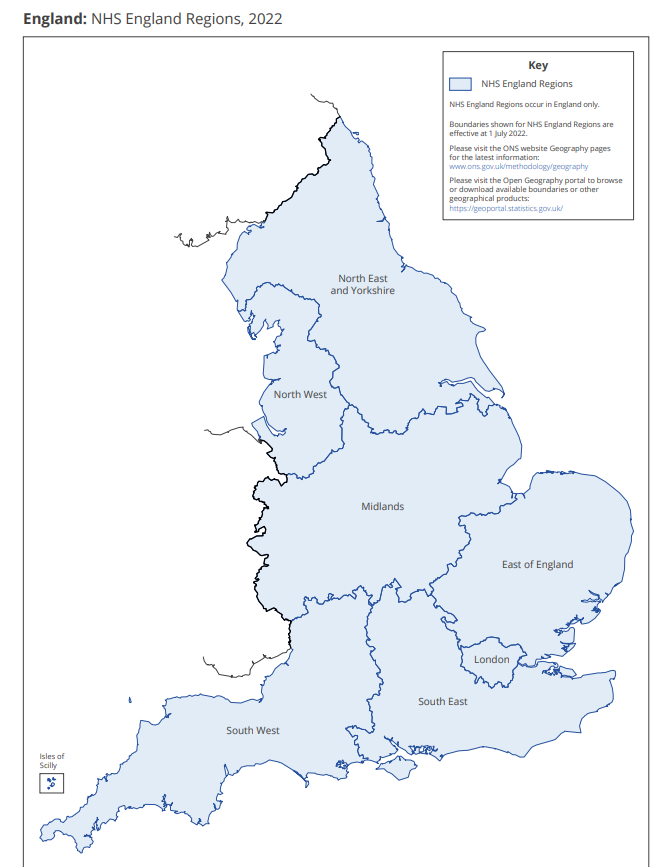

In [142]:
ad.head(1)

icb_ons_code sub_icb_location_code  \
0    E54000050                   00L   

                        sub_icb_location_name appointment_date  year month  \
0  NHS North East and North Cumbria ICB - 00L       2021-12-01  2021   Dec   

  actual_duration  count_of_appointments region_ons_code  \
0   31-60 Minutes                    364       E40000012   

  sub_icb_location_ons_code  
0                 E38000130

In [143]:
ar.head(1)

icb_ons_code appointment_month appointment_status hcp_type appointment_mode  \
0    E54000034           2020-01           Attended       GP     Face-to-Face   

  time_between_book_and_appointment  count_of_appointments month  year  
0                             1 Day                   8107   Jan  2020

In [144]:
nc.head(1)

appointment_date icb_ons_code                       sub_icb_location_name  \
0       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   

        service_setting            context_type  \
0  Primary Care Network  Care Related Encounter   

                        national_category  count_of_appointments month  year  
0  Patient contact during care home round                      3   Aug  2021

I found the icb_ons_codes in an Excel file I downloaded from here https://geoportal.statistics.gov.uk/documents/25ba241a775e4a9db8e5c721ee73d85d/about  I then matched the icb’s with the regions on here: https://www.nhs.uk/nhs-services/find-your-local-integrated-care-board/

I have decided to create a mapping dictionary to create a new "region" column in each data set.

In [146]:
# Create mapping dictionary.
icb_region_mapping = {
    "E54000008": "North West",
    "E54000048": "North West",
    "E54000057": "North West",
    "E54000050": "North East & Yorkshire",
    "E54000051": "North East & Yorkshire",
    "E54000054": "North East & Yorkshire",
    "E54000061": "North East & Yorkshire",
    "E54000010": "Midlands",
    "E54000011": "Midlands",
    "E54000013": "Midlands",
    "E54000015": "Midlands",
    "E54000018": "Midlands",
    "E54000019": "Midlands",
    "E54000055": "Midlands",
    "E54000058": "Midlands",
    "E54000059": "Midlands",
    "E54000060": "Midlands",
    "E54000062": "Midlands",
    "E54000022": "East of England",
    "E54000023": "East of England",
    "E54000024": "East of England",
    "E54000025": "East of England",
    "E54000026": "East of England",
    "E54000056": "East of England",
    "E54000027": "London",
    "E54000028": "London",
    "E54000029": "London",
    "E54000030": "London",
    "E54000031": "London",
    "E54000036": "South West",
    "E54000037": "South West",
    "E54000038": "South West",
    "E54000039": "South West",
    "E54000040": "South West",
    "E54000041": "South West",
    "E54000043": "South West",
    "E54000032": "South East",
    "E54000034": "South East",
    "E54000042": "South East",
    "E54000044": "South East",
    "E54000052": "South East",
    "E54000053": "South East"}

I tried various ways to map this but all but using replace() returned lots of NaN values. I tried using map() and also apply() with the lambda function, then tried to rectify NaN values by doing things like stripping the spaces from the "icb_ons_code" column and making sure that that column just had string values. In the end replace() was the only method that worked.

In [148]:
# Map regions with ad data.
ad['Region'] = ad['icb_ons_code'].replace(icb_region_mapping)
ad

icb_ons_code sub_icb_location_code  \
0         E54000050                   00L   
1         E54000050                   00L   
2         E54000050                   00L   
3         E54000050                   00L   
4         E54000050                   00L   
...             ...                   ...   
137788    E54000054                 X2C4Y   
137789    E54000054                 X2C4Y   
137790    E54000054                 X2C4Y   
137791    E54000054                 X2C4Y   
137792    E54000054                 X2C4Y   

                             sub_icb_location_name appointment_date  year  \
0       NHS North East and North Cumbria ICB - 00L       2021-12-01  2021   
1       NHS North East and North Cumbria ICB - 00L       2021-12-01  2021   
2       NHS North East and North Cumbria ICB - 00L       2021-12-01  2021   
3       NHS North East and North Cumbria ICB - 00L       2021-12-01  2021   
4       NHS North East and North Cumbria ICB - 00L       2021-12-01  2021   
...                                            ...              ...   ...   
137788              NHS West Yorkshire ICB - X2C4Y       2022-06-30  2022   
137789              NHS West Yorkshire ICB - X2C4Y       2022-06-30  2022   
137790              NHS West Yorkshire ICB - X2C4Y       2022-06-30  2022   
137791              NHS West Yorkshire ICB - X2C4Y       2022-06-30  2022   
137792              NHS West Yorkshire ICB - X2C4Y       2022-06-30  2022   

       month actual_duration  count_of_appointments region_ons_code  \
0        Dec   31-60 Minutes                    364       E40000012   
1        Dec   21-30 Minutes                    619       E40000012   
2        Dec    6-10 Minutes                   1698       E40000012   
3        Dec         Unknown                   1277       E40000012   
4        Dec   16-20 Minutes                    730       E40000012   
...      ...             ...                    ...             ...   
137788   Jun   31-60 Minutes                    430       E40000012   
137789   Jun   21-30 Minutes                    751       E40000012   
137790   Jun   16-20 Minutes                    921       E40000012   
137791   Jun   11-15 Minutes                   1439       E40000012   
137792   Jun     1-5 Minutes                   1739       E40000012   

       sub_icb_location_ons_code                  Region  
0                      E38000130  North East & Yorkshire  
1                      E38000130  North East & Yorkshire  
2                      E38000130  North East & Yorkshire  
3                      E38000130  North East & Yorkshire  
4                      E38000130  North East & Yorkshire  
...                          ...                     ...  
137788                 E38000254  North East & Yorkshire  
137789                 E38000254  North East & Yorkshire  
137790                 E38000254  North East & Yorkshire  
137791                 E38000254  North East & Yorkshire  
137792                 E38000254  North East & Yorkshire  

[137793 rows x 11 columns]

In [149]:
# Check region column values in ad.
ad['Region'].unique()

array(['North East & Yorkshire', 'North West', 'Midlands',
       'East of England', 'South East', 'South West', 'London'],
      dtype=object)

In [150]:
# Checking the NaN values.
ad["Region"].isna().sum()

0

In [151]:
# Map regions with ar data.
ar['Region'] = ar['icb_ons_code'].replace(icb_region_mapping)
ar

icb_ons_code appointment_month appointment_status hcp_type  \
0         E54000034           2020-01           Attended       GP   
1         E54000034           2020-01           Attended       GP   
2         E54000034           2020-01           Attended       GP   
3         E54000034           2020-01           Attended       GP   
4         E54000034           2020-01           Attended       GP   
...             ...               ...                ...      ...   
596816    E54000050           2022-06            Unknown  Unknown   
596817    E54000050           2022-06            Unknown  Unknown   
596818    E54000050           2022-06            Unknown  Unknown   
596819    E54000050           2022-06            Unknown  Unknown   
596820    E54000050           2022-06            Unknown  Unknown   

       appointment_mode time_between_book_and_appointment  \
0          Face-to-Face                             1 Day   
1          Face-to-Face                    15  to 21 Days   
2          Face-to-Face                       2 to 7 Days   
3          Face-to-Face                    22  to 28 Days   
4          Face-to-Face                     8  to 14 Days   
...                 ...                               ...   
596816          Unknown                       2 to 7 Days   
596817          Unknown                    22  to 28 Days   
596818          Unknown                     8  to 14 Days   
596819          Unknown                 More than 28 Days   
596820          Unknown                          Same Day   

        count_of_appointments month  year                  Region  
0                        8107   Jan  2020              South East  
1                        6791   Jan  2020              South East  
2                       20686   Jan  2020              South East  
3                        4268   Jan  2020              South East  
4                       11971   Jan  2020              South East  
...                       ...   ...   ...                     ...  
596816                     21   Jun  2022  North East & Yorkshire  
596817                      8   Jun  2022  North East & Yorkshire  
596818                     28   Jun  2022  North East & Yorkshire  
596819                     17   Jun  2022  North East & Yorkshire  
596820                     10   Jun  2022  North East & Yorkshire  

[596821 rows x 10 columns]

In [152]:
# Check region column values in ar.
ar["Region"].unique()

array(['South East', 'South West', 'North East & Yorkshire',
       'East of England', 'Midlands', 'London', 'North West'],
      dtype=object)

In [153]:
# Checking the NaN values.
ar["Region"].isna().sum()

0

In [154]:
# Map regions with nc data.
nc['Region'] = nc['icb_ons_code'].replace(icb_region_mapping)
nc

appointment_date icb_ons_code  \
0            2021-08-02    E54000050   
1            2021-08-02    E54000050   
2            2021-08-02    E54000050   
3            2021-08-02    E54000050   
4            2021-08-02    E54000050   
...                 ...          ...   
817389       2022-06-30    E54000054   
817390       2022-06-30    E54000054   
817391       2022-06-30    E54000054   
817392       2022-06-30    E54000054   
817393       2022-06-30    E54000054   

                             sub_icb_location_name            service_setting  \
0       NHS North East and North Cumbria ICB - 00L       Primary Care Network   
1       NHS North East and North Cumbria ICB - 00L                      Other   
2       NHS North East and North Cumbria ICB - 00L           General Practice   
3       NHS North East and North Cumbria ICB - 00L           General Practice   
4       NHS North East and North Cumbria ICB - 00L           General Practice   
...                                            ...                        ...   
817389              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817390              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817391              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817392              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817393              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   

                  context_type                       national_category  \
0       Care Related Encounter  Patient contact during care home round   
1       Care Related Encounter                         Planned clinics   
2       Care Related Encounter                              Home visit   
3       Care Related Encounter              General consultation acute   
4       Care Related Encounter            Structured medication review   
...                        ...                                     ...   
817389  Care Related Encounter             Unplanned clinical activity   
817390  Care Related Encounter                         Planned clinics   
817391  Care Related Encounter              Planned clinical procedure   
817392  Care Related Encounter            General consultation routine   
817393  Care Related Encounter              General consultation acute   

        count_of_appointments month  year                  Region  
0                           3   Aug  2021  North East & Yorkshire  
1                           7   Aug  2021  North East & Yorkshire  
2                          79   Aug  2021  North East & Yorkshire  
3                         725   Aug  2021  North East & Yorkshire  
4                           2   Aug  2021  North East & Yorkshire  
...                       ...   ...   ...                     ...  
817389                     12   Jun  2022  North East & Yorkshire  
817390                      4   Jun  2022  North East & Yorkshire  
817391                     92   Jun  2022  North East & Yorkshire  
817392                      4   Jun  2022  North East & Yorkshire  
817393                     19   Jun  2022  North East & Yorkshire  

[817394 rows x 10 columns]

In [155]:
# Check region column values in nc.
nc['Region'].unique()

array(['North East & Yorkshire', 'North West', 'Midlands',
       'East of England', 'South East', 'South West', 'London'],
      dtype=object)

In [156]:
# Checking the NaN values.
ar["Region"].isna().sum()

0

As I've had a lot of problems with mapping this, I'm going to download one of these data sets and double check that there's nothing weird going on in Excel.

In [158]:
ad.to_csv('ad_data.csv', index=False)

Checked ad_data.csv in Excel for the "Region" column and all was ok.

In [160]:
# Another check that everything is working ok and I can group the values.
# This shows the total appointments per region from highest to lowest.
groupby_region_ad = ad.groupby("Region")["count_of_appointments"].sum()
groupby_region_ad.sort_values(ascending=False)

Region
Midlands                  32574555
North East & Yorkshire    27425610
South East                25577953
London                    24488519
North West                19880924
East of England           19546694
South West                18486437
Name: count_of_appointments, dtype: int64

Note that this does not take into account the number of patients registered in each region so, for example, the South West could be busier than the Midlands as their count of appointments per patient registered could be higher.

I want to create a new column called "Season" in all of the data sets. I will use the same process that I did when creating the "Regions" column.

In [163]:
# Check how the months are formatted.
ar["month"].unique()

array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
       'Oct', 'Nov', 'Dec'], dtype=object)

In [164]:
# Create a mapping dictionary for the seasons.
month_season_mapping = {
    "Jan":"Winter",
    "Feb":"Winter",
    "Mar":"Spring",
    "Apr":"Spring",
    "May":"Spring",
    "Jun":"Summer",
    "Jul":"Summer",
    "Aug":"Summer",
    "Sep":"Autumn",
    "Oct":"Autumn",
    "Nov":"Autumn",
    "Dec":"Winter"}

In [165]:
# Map seasons with ad data.
ad["Season"] = ad["month"].replace(month_season_mapping)
ad

icb_ons_code sub_icb_location_code  \
0         E54000050                   00L   
1         E54000050                   00L   
2         E54000050                   00L   
3         E54000050                   00L   
4         E54000050                   00L   
...             ...                   ...   
137788    E54000054                 X2C4Y   
137789    E54000054                 X2C4Y   
137790    E54000054                 X2C4Y   
137791    E54000054                 X2C4Y   
137792    E54000054                 X2C4Y   

                             sub_icb_location_name appointment_date  year  \
0       NHS North East and North Cumbria ICB - 00L       2021-12-01  2021   
1       NHS North East and North Cumbria ICB - 00L       2021-12-01  2021   
2       NHS North East and North Cumbria ICB - 00L       2021-12-01  2021   
3       NHS North East and North Cumbria ICB - 00L       2021-12-01  2021   
4       NHS North East and North Cumbria ICB - 00L       2021-12-01  2021   
...                                            ...              ...   ...   
137788              NHS West Yorkshire ICB - X2C4Y       2022-06-30  2022   
137789              NHS West Yorkshire ICB - X2C4Y       2022-06-30  2022   
137790              NHS West Yorkshire ICB - X2C4Y       2022-06-30  2022   
137791              NHS West Yorkshire ICB - X2C4Y       2022-06-30  2022   
137792              NHS West Yorkshire ICB - X2C4Y       2022-06-30  2022   

       month actual_duration  count_of_appointments region_ons_code  \
0        Dec   31-60 Minutes                    364       E40000012   
1        Dec   21-30 Minutes                    619       E40000012   
2        Dec    6-10 Minutes                   1698       E40000012   
3        Dec         Unknown                   1277       E40000012   
4        Dec   16-20 Minutes                    730       E40000012   
...      ...             ...                    ...             ...   
137788   Jun   31-60 Minutes                    430       E40000012   
137789   Jun   21-30 Minutes                    751       E40000012   
137790   Jun   16-20 Minutes                    921       E40000012   
137791   Jun   11-15 Minutes                   1439       E40000012   
137792   Jun     1-5 Minutes                   1739       E40000012   

       sub_icb_location_ons_code                  Region  Season  
0                      E38000130  North East & Yorkshire  Winter  
1                      E38000130  North East & Yorkshire  Winter  
2                      E38000130  North East & Yorkshire  Winter  
3                      E38000130  North East & Yorkshire  Winter  
4                      E38000130  North East & Yorkshire  Winter  
...                          ...                     ...     ...  
137788                 E38000254  North East & Yorkshire  Summer  
137789                 E38000254  North East & Yorkshire  Summer  
137790                 E38000254  North East & Yorkshire  Summer  
137791                 E38000254  North East & Yorkshire  Summer  
137792                 E38000254  North East & Yorkshire  Summer  

[137793 rows x 12 columns]

In [166]:
# Check the values in the "Season" column.
ad["Season"].unique()

array(['Winter', 'Spring', 'Summer'], dtype=object)

Note that there are no Autumn values in this data set.

In [168]:
# Check whether there are any nulls.
ad["Season"].isna().sum()

0

In [169]:
# Map seasons with ar data.
ar["Season"] = ar["month"].replace(month_season_mapping)
ar

icb_ons_code appointment_month appointment_status hcp_type  \
0         E54000034           2020-01           Attended       GP   
1         E54000034           2020-01           Attended       GP   
2         E54000034           2020-01           Attended       GP   
3         E54000034           2020-01           Attended       GP   
4         E54000034           2020-01           Attended       GP   
...             ...               ...                ...      ...   
596816    E54000050           2022-06            Unknown  Unknown   
596817    E54000050           2022-06            Unknown  Unknown   
596818    E54000050           2022-06            Unknown  Unknown   
596819    E54000050           2022-06            Unknown  Unknown   
596820    E54000050           2022-06            Unknown  Unknown   

       appointment_mode time_between_book_and_appointment  \
0          Face-to-Face                             1 Day   
1          Face-to-Face                    15  to 21 Days   
2          Face-to-Face                       2 to 7 Days   
3          Face-to-Face                    22  to 28 Days   
4          Face-to-Face                     8  to 14 Days   
...                 ...                               ...   
596816          Unknown                       2 to 7 Days   
596817          Unknown                    22  to 28 Days   
596818          Unknown                     8  to 14 Days   
596819          Unknown                 More than 28 Days   
596820          Unknown                          Same Day   

        count_of_appointments month  year                  Region  Season  
0                        8107   Jan  2020              South East  Winter  
1                        6791   Jan  2020              South East  Winter  
2                       20686   Jan  2020              South East  Winter  
3                        4268   Jan  2020              South East  Winter  
4                       11971   Jan  2020              South East  Winter  
...                       ...   ...   ...                     ...     ...  
596816                     21   Jun  2022  North East & Yorkshire  Summer  
596817                      8   Jun  2022  North East & Yorkshire  Summer  
596818                     28   Jun  2022  North East & Yorkshire  Summer  
596819                     17   Jun  2022  North East & Yorkshire  Summer  
596820                     10   Jun  2022  North East & Yorkshire  Summer  

[596821 rows x 11 columns]

In [170]:
# Check the values in the "Season" column.
ar["Season"].unique()

array(['Winter', 'Spring', 'Summer', 'Autumn'], dtype=object)

In [171]:
# Check whether there are any missing values.
ar["Season"].isna().sum()

0

In [172]:
# Map seasons with nc data.
nc["Season"] = nc["month"].replace(month_season_mapping)
nc

appointment_date icb_ons_code  \
0            2021-08-02    E54000050   
1            2021-08-02    E54000050   
2            2021-08-02    E54000050   
3            2021-08-02    E54000050   
4            2021-08-02    E54000050   
...                 ...          ...   
817389       2022-06-30    E54000054   
817390       2022-06-30    E54000054   
817391       2022-06-30    E54000054   
817392       2022-06-30    E54000054   
817393       2022-06-30    E54000054   

                             sub_icb_location_name            service_setting  \
0       NHS North East and North Cumbria ICB - 00L       Primary Care Network   
1       NHS North East and North Cumbria ICB - 00L                      Other   
2       NHS North East and North Cumbria ICB - 00L           General Practice   
3       NHS North East and North Cumbria ICB - 00L           General Practice   
4       NHS North East and North Cumbria ICB - 00L           General Practice   
...                                            ...                        ...   
817389              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817390              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817391              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817392              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817393              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   

                  context_type                       national_category  \
0       Care Related Encounter  Patient contact during care home round   
1       Care Related Encounter                         Planned clinics   
2       Care Related Encounter                              Home visit   
3       Care Related Encounter              General consultation acute   
4       Care Related Encounter            Structured medication review   
...                        ...                                     ...   
817389  Care Related Encounter             Unplanned clinical activity   
817390  Care Related Encounter                         Planned clinics   
817391  Care Related Encounter              Planned clinical procedure   
817392  Care Related Encounter            General consultation routine   
817393  Care Related Encounter              General consultation acute   

        count_of_appointments month  year                  Region  Season  
0                           3   Aug  2021  North East & Yorkshire  Summer  
1                           7   Aug  2021  North East & Yorkshire  Summer  
2                          79   Aug  2021  North East & Yorkshire  Summer  
3                         725   Aug  2021  North East & Yorkshire  Summer  
4                           2   Aug  2021  North East & Yorkshire  Summer  
...                       ...   ...   ...                     ...     ...  
817389                     12   Jun  2022  North East & Yorkshire  Summer  
817390                      4   Jun  2022  North East & Yorkshire  Summer  
817391                     92   Jun  2022  North East & Yorkshire  Summer  
817392                      4   Jun  2022  North East & Yorkshire  Summer  
817393                     19   Jun  2022  North East & Yorkshire  Summer  

[817394 rows x 11 columns]

In [173]:
# Check the values in the "Season" column.
nc["Season"].unique()

array(['Summer', 'Autumn', 'Winter', 'Spring'], dtype=object)

In [174]:
# Check for missing values.
nc["Season"].isna().sum()

0

In [175]:
# Map seasons with one11 data.
one11["Season"] = one11["month"].replace(month_season_mapping)
one11.head(5)

month_year month  year  count_111_triages  Season
0    2020-07   Jul  2020            1248152  Summer
1    2020-08   Aug  2020            1404175  Summer
2    2020-09   Sep  2020            1402720  Autumn
3    2020-10   Oct  2020            1339519  Autumn
4    2020-11   Nov  2020            1279294  Autumn

In [176]:
# Check the values in the "Season" column.
one11["Season"].unique()

array(['Summer', 'Autumn', 'Winter', 'Spring'], dtype=object)

In [177]:
# Check for missing values.
one11["Season"].isna().sum()

0

### Visualisations

1. Create a bar chart - How many apppointments per appointment mode between Jan 2020 and Jun 2022?

In [180]:
# Group by appointment mode.
group_app_mode1 = ar.groupby("appointment_mode")["count_of_appointments"].sum().reset_index()

# View group by.
group_app_mode1

appointment_mode  count_of_appointments
0     Face-to-Face              439981729
1       Home Visit                4887876
2        Telephone              267862657
3          Unknown               26451305
4     Video/Online                3620958

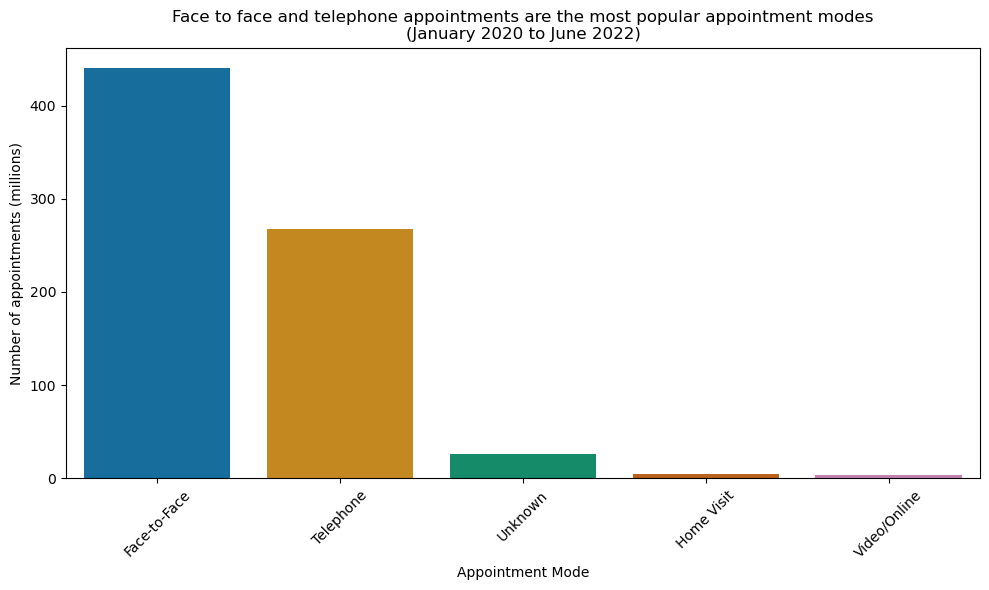

In [181]:
# Sort group_app_mode1 into descending order so the chart is more readable.
group_app_mode1 = group_app_mode1.sort_values(by="count_of_appointments", ascending=False)

# Divide the appointment count by a million so that the y axis will be more readable.
group_app_mode1["count_of_appointments"] /= 1000000

# Create a vertical bar chart.
standard_vertical_bar_chart(group_app_mode1, "appointment_mode", "count_of_appointments", 
                            title="Face to face and telephone appointments are the most popular appointment modes\n(January 2020 to June 2022)", 
                            x_label="Appointment Mode", y_label="Number of appointments (millions)", palette="colorblind")

Face-to-face and telephone appointments are the most common appointment mode. Online the least.

2. Create a bar chart - How many appointments were there for each apppointment duration between Dec 2021 and Jun 2022?

In [184]:
# Group by appointment duration.
group_app_dur1 = ad.groupby("actual_duration")["count_of_appointments"].sum().reset_index()

# View group by.
group_app_dur1

actual_duration  count_of_appointments
0     1-5 Minutes               28600865
1   11-15 Minutes               25160882
2   16-20 Minutes               16004247
3   21-30 Minutes               15026365
4   31-60 Minutes                9103432
5    6-10 Minutes               33800815
6         Unknown               40284086

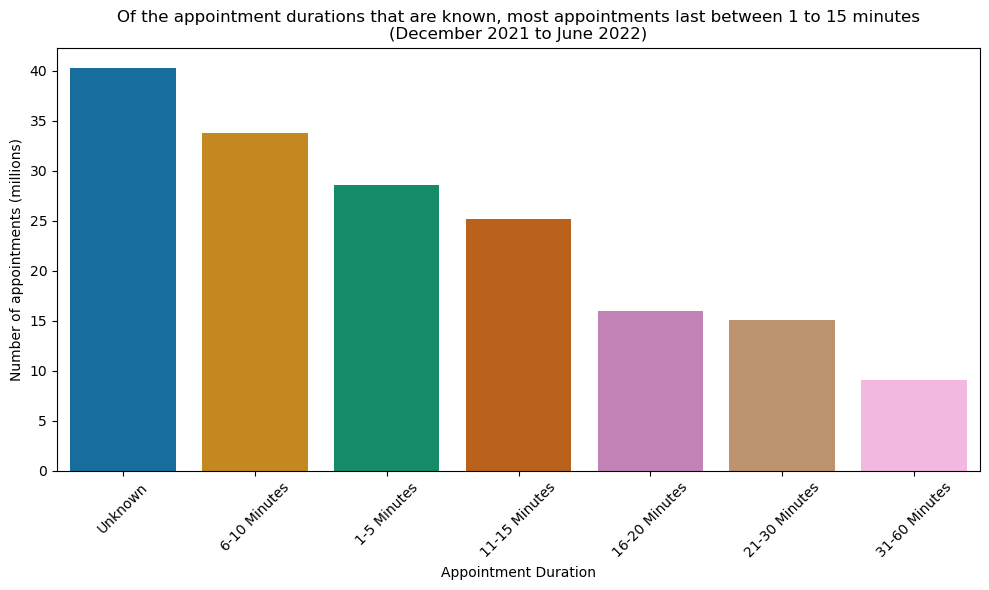

In [185]:
# Sort group_app_dur1 into descending order so the chart is more readable.
group_app_dur1 = group_app_dur1.sort_values(by="count_of_appointments", ascending=False)

# Divide the appointment count by a million so that the y axis will be more readable.
group_app_dur1["count_of_appointments"] /= 1000000

# Create a vertical bar chart.
napp_dur202122 = standard_vertical_bar_chart(group_app_dur1, "actual_duration", "count_of_appointments", 
                            title="Of the appointment durations that are known, most appointments last between 1 to 15 minutes\n"\
                            "(December 2021 to June 2022)", 
                            x_label="Appointment Duration", y_label="Number of appointments (millions)", palette="colorblind")

Lots of unknowns. But of the appointments that are known, most appointments are between 1 and 15 minutes.

In [187]:
# Group by appointment duration.
group_ser_set1 = nc.groupby("service_setting")["count_of_appointments"].sum().reset_index()

# View group by.
group_ser_set1

service_setting  count_of_appointments
0  Extended Access Provision                2176807
1           General Practice              270811691
2                      Other                5420076
3       Primary Care Network                6557386
4                   Unmapped               11080810

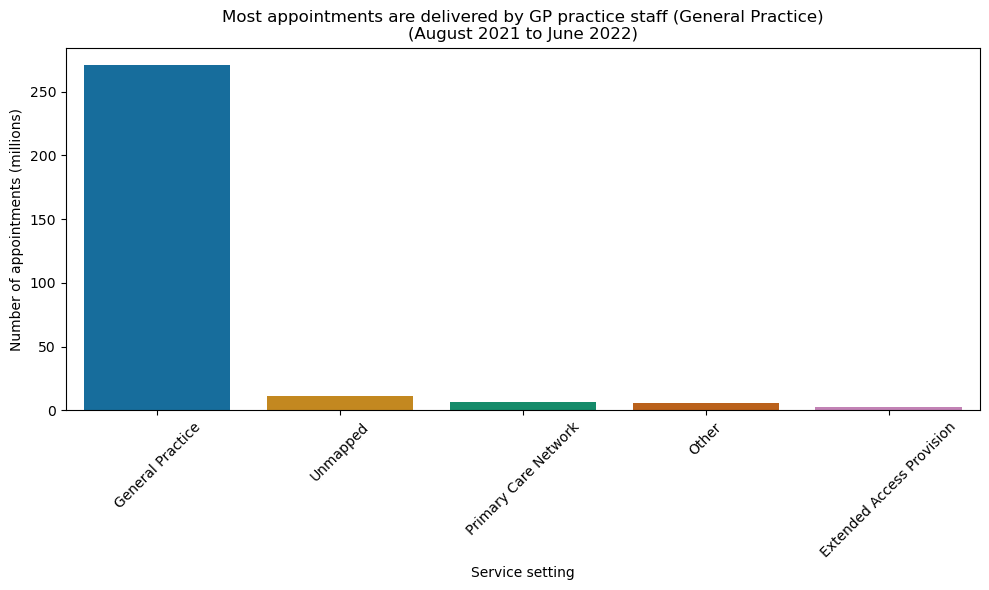

In [188]:
# Sort group_ser_set1 into descending order so the chart is more readable.
group_ser_set1 = group_ser_set1.sort_values(by="count_of_appointments", ascending=False)

# Divide the appointment count by a million so that the y axis will be more readable.
group_ser_set1["count_of_appointments"] /= 1000000

# Create a vertical bar chart.
napp_ser_set202122 = standard_vertical_bar_chart(group_ser_set1, "service_setting", "count_of_appointments", 
                            title="Most appointments are delivered by GP practice staff (General Practice)\n(August 2021 to June 2022)", 
                            x_label="Service setting", y_label="Number of appointments (millions)", palette="colorblind")

Most appointments are delivered by General Practice staff.

4. Create a bar chart - How many appointments were there for each context type. between Aug 2021 and Jun 2022?

In [191]:
# Group by context type.
group_ctx_typ1 = nc.groupby("context_type")["count_of_appointments"].sum().reset_index()

# View group by.
group_ctx_typ1

context_type  count_of_appointments
0  Care Related Encounter              257075158
1    Inconsistent Mapping               27890802
2                Unmapped               11080810

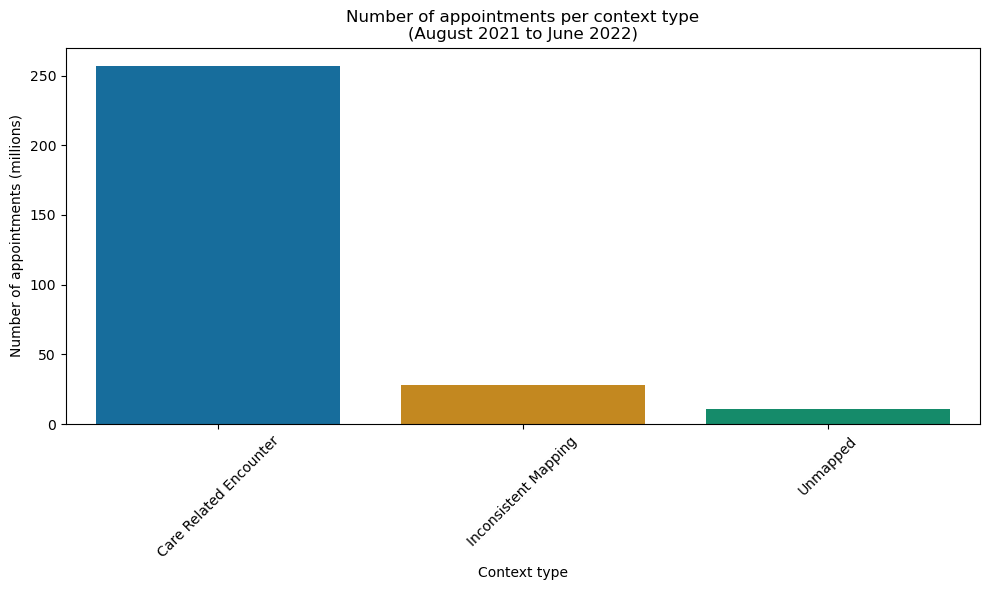

In [192]:
# Sort group_ctx_typ1 into descending order so the chart is more readable.
group_ctx_typ1 = group_ctx_typ1.sort_values(by="count_of_appointments", ascending=False)

# Divide the appointment count by a million so that the y axis will be more readable.
group_ctx_typ1["count_of_appointments"] /= 1000000

# Create a vertical bar chart.
napp_ctx_typ = standard_vertical_bar_chart(group_ctx_typ1, "context_type", "count_of_appointments",
                            title="Number of appointments per context type\n(August 2021 to June 2022)", 
                            x_label="Context type", y_label="Number of appointments (millions)", palette="colorblind")

Most appointments are a care related encounter.

5. Create a horizontal bar chart - How many appointments were there for each national category between Aug 2021 and Jun 2022?

A horizontal bar chart allows the long category names to be more readable than if it was a vertical bar chart.

In [196]:
# Group by national category.
group_nat_cat1 = nc.groupby("national_category")["count_of_appointments"].sum().reset_index()

# View group by.
group_nat_cat1

national_category  count_of_appointments
0   Care home needs assessment & personalised care...                 405904
1                                     Care home visit                 628279
2                                     Clinical triage               41546964
3                          General consultation acute               53691150
4                        General consultation routine               97271522
5              Group consultation and group education                  60632
6                                          Home visit                2144452
7                                Inconsistent mapping               27890802
8                     Non-contractual chargeable work                 138911
9              Patient contact during care home round                 810330
10                         Planned clinical procedure               25702694
11                                    Planned clinics               28019748
12  Service provided by organisation external to t...                 852133
13                         Social prescribing service                 475828
14                       Structured medication review                1858379
15                                           Unmapped               11080810
16                        Unplanned clinical activity                3055794
17                                            Walk-in                 412438

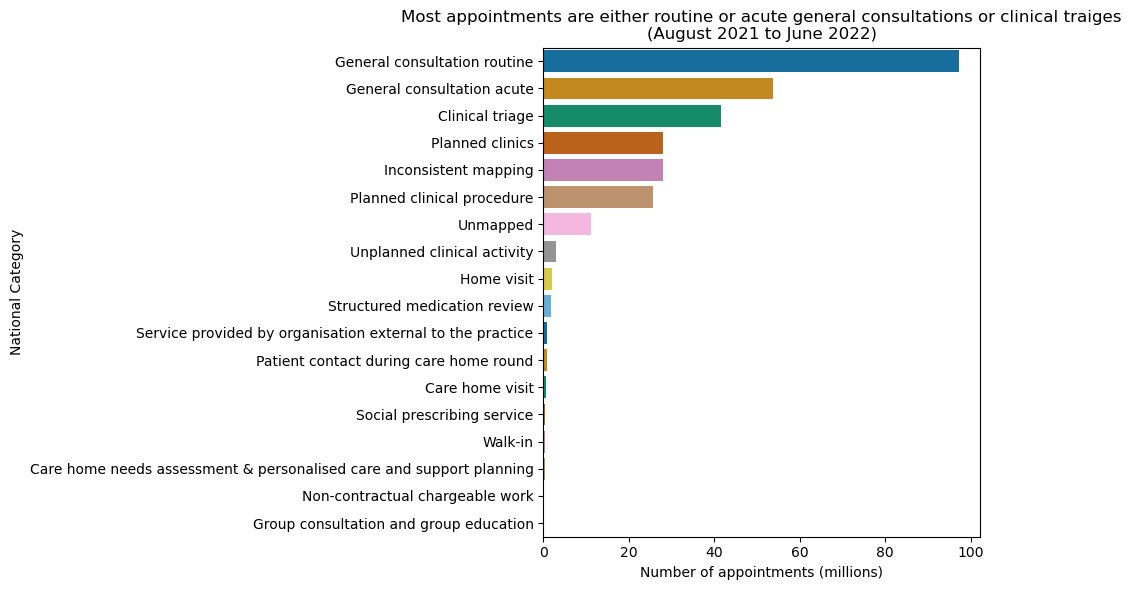

In [197]:
# Sort group_nat_cat1 into descending order so the chart is more readable.
group_nat_cat1 = group_nat_cat1.sort_values(by="count_of_appointments", ascending=False)

# Divide the appointment count by a million so that the y axis will be more readable.
group_nat_cat1["count_of_appointments"] /= 1000000

# Create a horizontal bar chart.
napp_nat_cat = standard_horizontal_bar_chart(group_nat_cat1, "national_category", "count_of_appointments",
                            title="Most appointments are either routine or acute general consultations or clinical traiges\n"\
                            "(August 2021 to June 2022)", 
                            x_label="National Category", y_label="Number of appointments (millions)", palette="colorblind")

Most appointments are either a routine or acute general consultation or a clinical traige.

6. Create a bar chart - How many apppointments per time between booking and getting and apppintment category from Jan 2020 to Jun 2022?

In [200]:
# Group by time between booking and appointment.
group_tbbanda1 = ar.groupby("time_between_book_and_appointment")["count_of_appointments"].sum().reset_index()

# View group by.
group_tbbanda1

time_between_book_and_appointment  count_of_appointments
0                             1 Day               67716097
1                    15  to 21 Days               42710574
2                       2 to 7 Days              153794531
3                    22  to 28 Days               25536541
4                     8  to 14 Days               86846519
5                 More than 28 Days               23050987
6                          Same Day              342747171
7                           Unknown                 402105

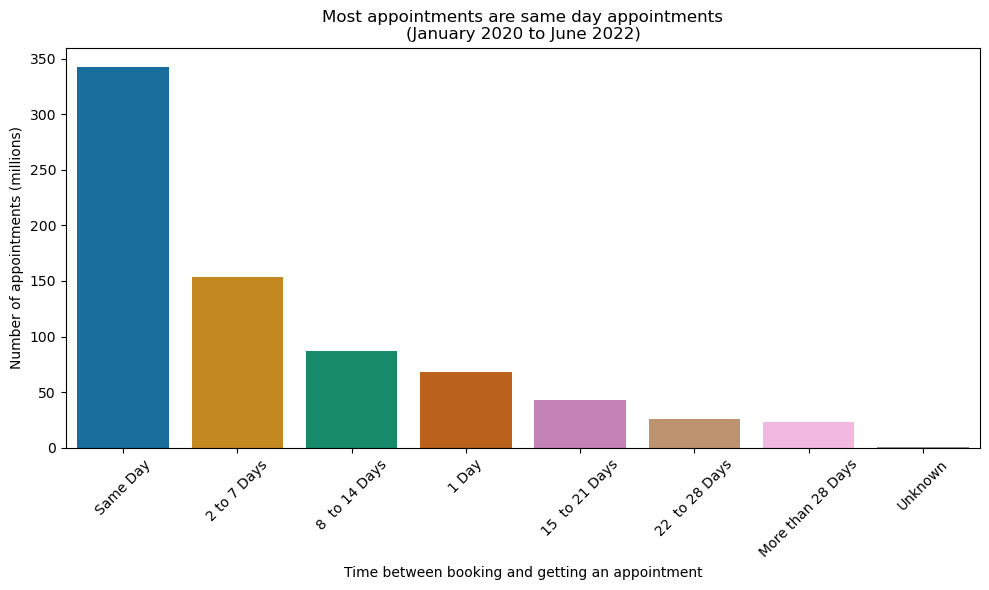

In [201]:
# Sort group_tbbanda1 into descending order so the chart is more readable.
group_tbbanda1 = group_tbbanda1.sort_values(by="count_of_appointments", ascending=False)

# Divide the appointment count by a million so that the y axis will be more readable.
group_tbbanda1["count_of_appointments"] /= 1000000

# Create a vertical bar chart.
napp_tbbanda202222 = standard_vertical_bar_chart(group_tbbanda1, "time_between_book_and_appointment", "count_of_appointments", 
                            title="Most appointments are same day appointments\n(January 2020 to June 2022)", 
                            x_label="Time between booking and getting an appointment", 
                            y_label="Number of appointments (millions)", palette="colorblind")

Most appointments were same day appointments. Most appointments were within 7 days of being booked.

7. Create a bar chart - How many apppointments per healthcare professional type from Jan 2020 to Jun 2022?

In [204]:
# Group by healthcare professional type.
group_hcp1 = ar.groupby("hcp_type")["count_of_appointments"].sum().reset_index()

# View group by.
group_hcp1

hcp_type  count_of_appointments
0                    GP              379650140
1  Other Practice staff              339650535
2               Unknown               23503850

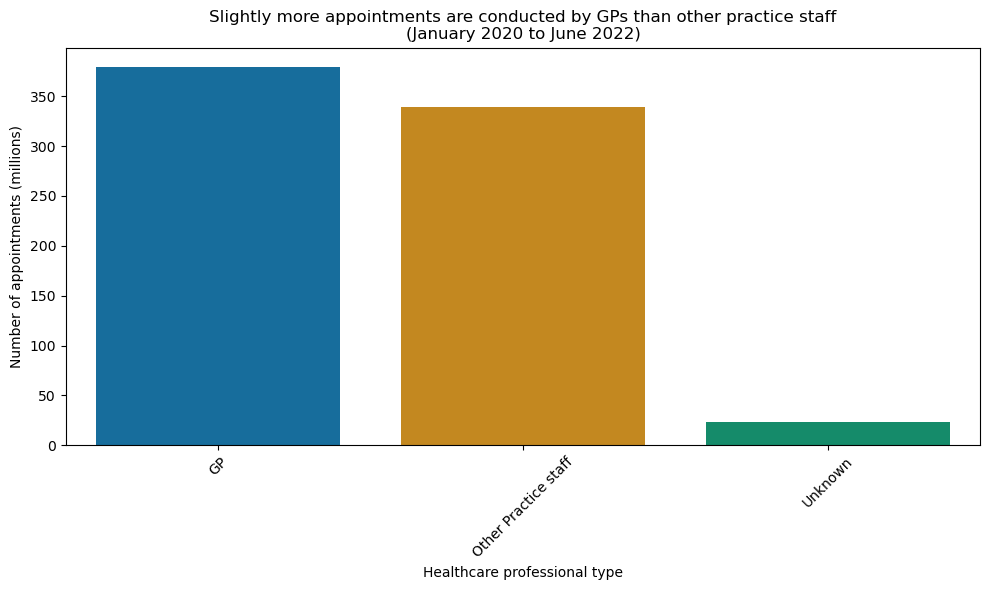

In [205]:
# Sort group_hcp1 into descending order so the chart is more readable.
group_hcp1 = group_hcp1.sort_values(by="count_of_appointments", ascending=False)

# Divide the appointment count by a million so that the y axis will be more readable.
group_hcp1["count_of_appointments"] /= 1000000

# Create a vertical bar chart.
napp_hcptyp = standard_vertical_bar_chart(group_hcp1, "hcp_type", "count_of_appointments", 
                            title="Slightly more appointments are conducted by GPs than other practice staff\n(January 2020 to June 2022)", 
                            x_label="Healthcare professional type", 
                            y_label="Number of appointments (millions)", palette="colorblind")

Slightly more GPs conducted appointments than other practice staff. I would like more data on each type of "other practice staff" as this is not that helpful.

8. Create a horizontal bar chart - How many apppointments per appointment status (attended or not) from Jan 2020 to Jun 2022?

In [208]:
# Group by appointment status.
group_app_sts1 = ar.groupby("appointment_status")["count_of_appointments"].sum().reset_index()

# View group by.
group_app_sts1

appointment_status  count_of_appointments
0           Attended              677755876
1     Did not attend               30911233
2            Unknown               34137416

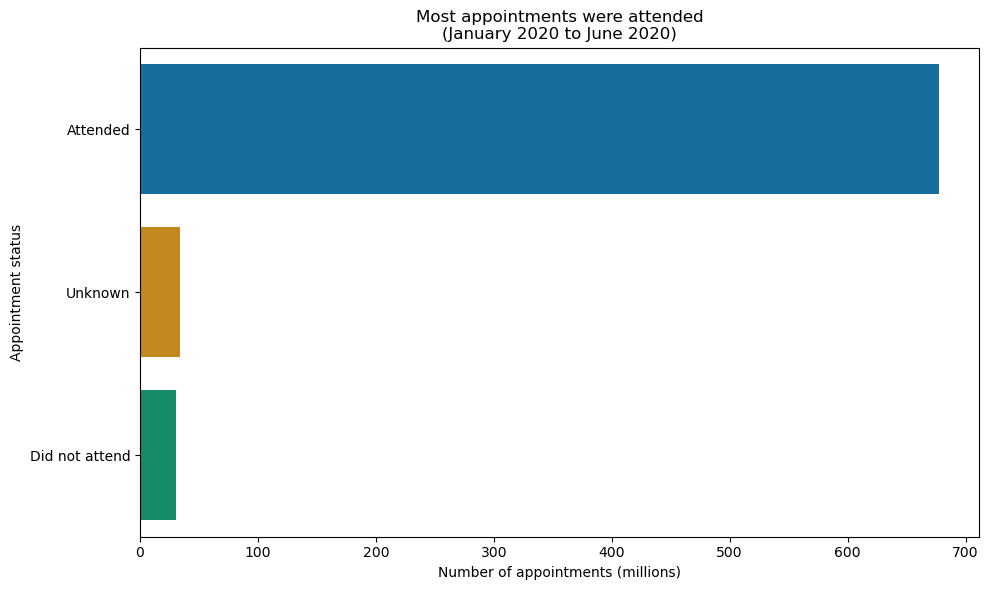

In [209]:
# Sort group_app_sts1 into descending order so the chart is more readable.
group_app_sts1 = group_app_sts1.sort_values(by="count_of_appointments", ascending=False)

# Divide the appointment count by a million so that the y axis will be more readable.
group_app_sts1["count_of_appointments"] /= 1000000

# Create a horizontal bar chart.
napp_app_sts = standard_horizontal_bar_chart(group_app_sts1, "appointment_status", "count_of_appointments", 
                            title="Most appointments were attended\n(January 2020 to June 2020)", 
                            x_label="Appointment status", 
                            y_label="Number of appointments (millions)", palette="colorblind")

Most appointments were attended.

9. Create a line plot - Showing the average number of appointments per day for each month from Jan 2020 - Jun 2022.
I'm using this date range as it shows the typical number of appointments across the largest data range I have available.
As mentioned near the start of this notebook, I will use 1,105,900 appointments per day as a guideline for maximum capacity.

In [212]:
# Check data types.
ar.dtypes

icb_ons_code                            object
appointment_month                    period[M]
appointment_status                      object
hcp_type                                object
appointment_mode                        object
time_between_book_and_appointment       object
count_of_appointments                    int64
month                                   object
year                                     int64
Region                                  object
Season                                  object
dtype: object

In [213]:
# Change "appointment_month" to a string.
ar["appointment_month"] = ar["appointment_month"].astype(str)
ar.dtypes

icb_ons_code                         object
appointment_month                    object
appointment_status                   object
hcp_type                             object
appointment_mode                     object
time_between_book_and_appointment    object
count_of_appointments                 int64
month                                object
year                                  int64
Region                               object
Season                               object
dtype: object

In [214]:
# Use groupby() to group by month and then divide count_of_appointments by 30 to work out the approx. number of appointments per day.
# Also divide the count_of_appointments by a million so that "1e6" doesn't appear on the y axis.
group_ar_nappoint1 = ar.groupby("appointment_month")["count_of_appointments"].sum()/30000000
group_ar_nappoint1 = group_ar_nappoint1.reset_index()
group_ar_nappoint1

appointment_month  count_of_appointments
0            2020-01               0.906643
1            2020-02               0.803487
2            2020-03               0.801782
3            2020-04               0.533596
4            2020-05               0.547240
5            2020-06               0.689693
6            2020-07               0.749715
7            2020-08               0.671684
8            2020-09               0.890475
9            2020-10               0.943398
10           2020-11               0.835387
11           2020-12               0.784531
12           2021-01               0.749736
13           2021-02               0.746652
14           2021-03               0.907514
15           2021-04               0.795998
16           2021-05               0.783613
17           2021-06               0.892806
18           2021-07               0.857974
19           2021-08               0.795072
20           2021-09               0.950750
21           2021-10               1.010128
22           2021-11               1.013502
23           2021-12               0.838026
24           2022-01               0.854516
25           2022-02               0.845175
26           2022-03               0.986501
27           2022-04               0.797102
28           2022-05               0.916517
29           2022-06               0.860936

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


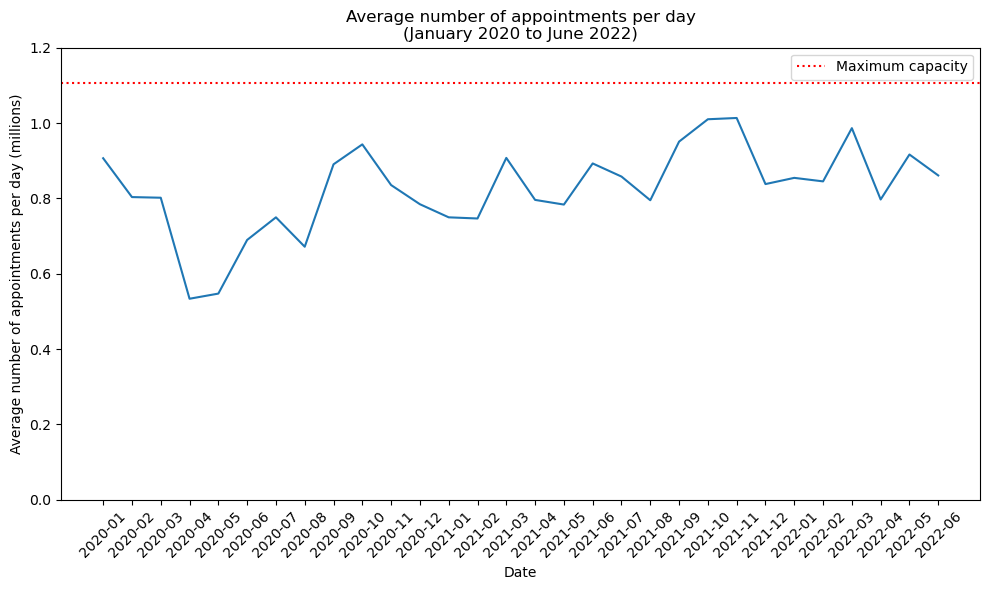

In [215]:
# Create the line plot.
standard_line_plot(group_ar_nappoint1, "appointment_month", "count_of_appointments", 
                   title="Average number of appointments per day\n(January 2020 to June 2022)",
                   x_label="Average number of appointments per day (millions)", y_label="Date",
                   y_limit=(0, 1.2), hline_y=1.1059)

On average, no months are over maximum capacity.

10. Create the same plot as above, but only covering one year so that there aren't too many dates on the x axis.

In [218]:
# Filter group_ar_nappoint1 to only include July 2021 to June 2022.
group_ar_nappoint2 = group_ar_nappoint1[
    (group_ar_nappoint1["appointment_month"] >= "2021-07") &
    (group_ar_nappoint1["appointment_month"] <= "2022-06")]
group_ar_nappoint2

appointment_month  count_of_appointments
18           2021-07               0.857974
19           2021-08               0.795072
20           2021-09               0.950750
21           2021-10               1.010128
22           2021-11               1.013502
23           2021-12               0.838026
24           2022-01               0.854516
25           2022-02               0.845175
26           2022-03               0.986501
27           2022-04               0.797102
28           2022-05               0.916517
29           2022-06               0.860936

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


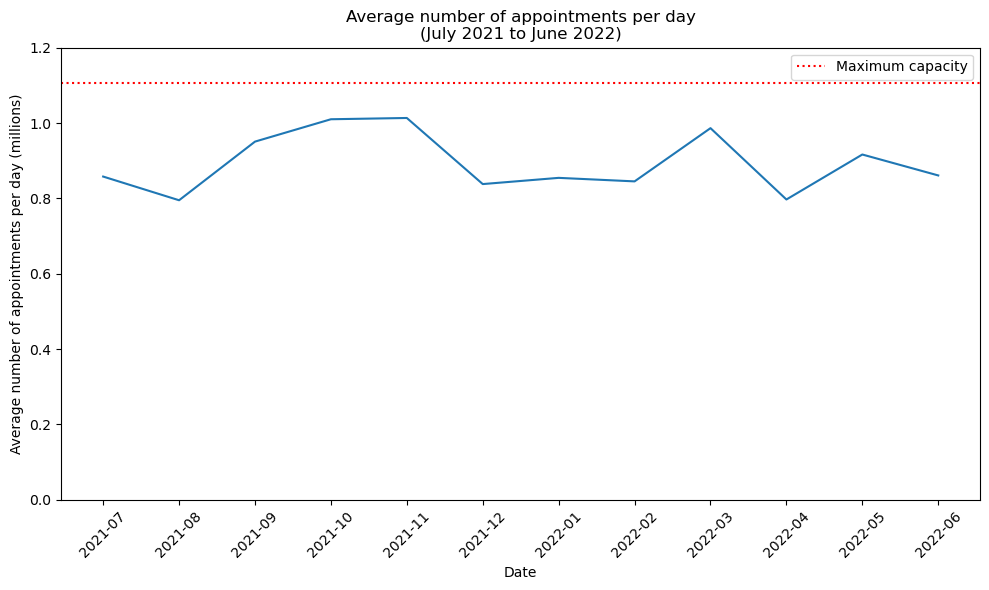

In [219]:
# Create the line plot.
standard_line_plot(group_ar_nappoint2, "appointment_month", "count_of_appointments", 
                   title="Average number of appointments per day\n(July 2021 to June 2022)", 
                   x_label="Average number of appointments per day (millions)", y_label="Date",
                   y_limit=(0, 1.2), hline_y=1.1059)

Similar to the previous plot but for a narrower range.

11. Create a similar line plot, but using the nc data.
I'm wondering whether I will get a different result if I use a different data set.

In [222]:
# Create an appointment_month column in the nc data.
nc['appointment_month'] = nc['appointment_date'].dt.to_period('M')
nc.head(5)

appointment_date icb_ons_code                       sub_icb_location_name  \
0       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
1       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
2       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
3       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
4       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   

        service_setting            context_type  \
0  Primary Care Network  Care Related Encounter   
1                 Other  Care Related Encounter   
2      General Practice  Care Related Encounter   
3      General Practice  Care Related Encounter   
4      General Practice  Care Related Encounter   

                        national_category  count_of_appointments month  year  \
0  Patient contact during care home round                      3   Aug  2021   
1                         Planned clinics                      7   Aug  2021   
2                              Home visit                     79   Aug  2021   
3              General consultation acute                    725   Aug  2021   
4            Structured medication review                      2   Aug  2021   

                   Region  Season appointment_month  
0  North East & Yorkshire  Summer           2021-08  
1  North East & Yorkshire  Summer           2021-08  
2  North East & Yorkshire  Summer           2021-08  
3  North East & Yorkshire  Summer           2021-08  
4  North East & Yorkshire  Summer           2021-08

In [223]:
# Check the data type of appointment_month.
nc.dtypes

appointment_date         datetime64[ns]
icb_ons_code                     object
sub_icb_location_name            object
service_setting                  object
context_type                     object
national_category                object
count_of_appointments             int64
month                            object
year                              int32
Region                           object
Season                           object
appointment_month             period[M]
dtype: object

In [224]:
# Change appointment_month to a string.
nc["appointment_month"] = nc["appointment_month"].astype(str)
nc.dtypes

appointment_date         datetime64[ns]
icb_ons_code                     object
sub_icb_location_name            object
service_setting                  object
context_type                     object
national_category                object
count_of_appointments             int64
month                            object
year                              int32
Region                           object
Season                           object
appointment_month                object
dtype: object

In [225]:
# Use groupby() to group by month and then divide count_of_appointments by 30 to work out the approx. number of appointments per day.
# Also divide the count_of_appointments by a million so that "1e6" doesn't appear on the y axis.
group_nc_nappoint1 = nc.groupby("appointment_month")["count_of_appointments"].sum()/30000000
group_nc_nappoint1 = group_nc_nappoint1.reset_index()
group_nc_nappoint1

appointment_month  count_of_appointments
0            2021-08               0.795072
1            2021-09               0.950750
2            2021-10               1.010128
3            2021-11               1.013502
4            2021-12               0.838026
5            2022-01               0.854516
6            2022-02               0.845175
7            2022-03               0.986501
8            2022-04               0.797102
9            2022-05               0.916517
10           2022-06               0.860936

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


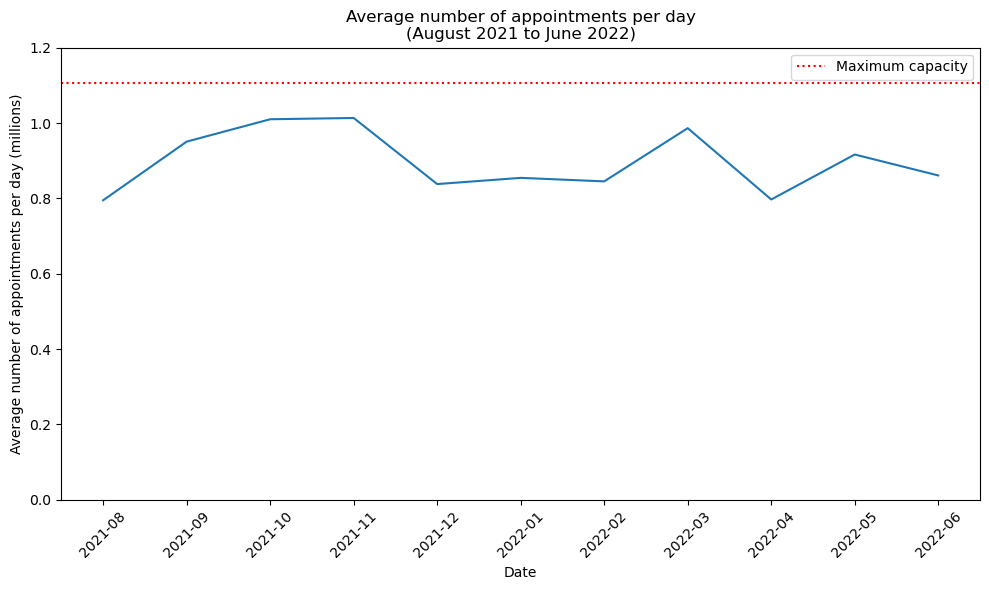

In [226]:
# Create the line plot.
standard_line_plot(group_nc_nappoint1, "appointment_month", "count_of_appointments", 
                   title="Average number of appointments per day\n(August 2021 to June 2022)", 
                   x_label="Average number of appointments per day (millions)", y_label="Date",
                   y_limit=(0, 1.2), hline_y=1.1059)

This line graph using nc data is very similar to the one using ar data.

12. Bar chart - How many appointments were there per season from July 2021 to June 2022?
Only the ar data set will cover a whole year so I'll use ar data.

In [229]:
# Filter ar for July 2021 to June 2022.
filter_jul21_jun22 = ar[(ar["appointment_month"] >= "2021-07") &
    (ar["appointment_month"] <= "2022-06")]

In [230]:
# Group by season.
group_season_ar_202122 = filter_jul21_jun22.groupby("Season")["count_of_appointments"].sum().reset_index()
group_season_ar_202122

Season  count_of_appointments
0  Autumn               89231405
1  Spring               81003606
2  Summer               75419468
3  Winter               76131510

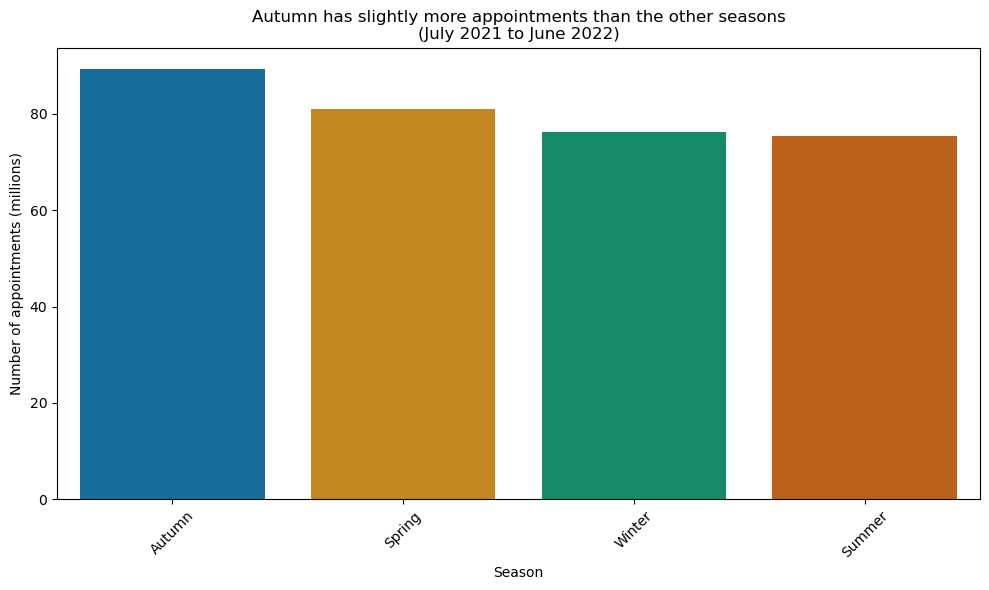

In [231]:
# Sort group_season_ar_202122 into descending order so the chart is more readable.
group_season_ar_202122 = group_season_ar_202122.sort_values(by="count_of_appointments", ascending=False)

# Divide the appointment count by a million so that the y axis will be more readable.
group_season_ar_202122["count_of_appointments"] /= 1000000


# Create bar chart.
standard_vertical_bar_chart(group_season_ar_202122, "Season", "count_of_appointments", 
                            title="Autumn has slightly more appointments than the other seasons\n(July 2021 to June 2022)", 
                            x_label="Season", y_label="Number of appointments (millions)", palette="colorblind")

Autumn has slightly more appointments than the other seasons.

13. Bar chart - How many appointments were there per region from July 2021 to June 2022? Only the ar data set will cover a whole year so I'll use ar data.
Note that each region will have a different number of patients registered.

In [234]:
# Group by region.
group_region_ar_202122 = filter_jul21_jun22.groupby(["Region", "Season"])["count_of_appointments"].sum().reset_index()
group_region_ar_202122

Region  Season  count_of_appointments
0          East of England  Autumn               10322737
1          East of England  Spring                9286287
2          East of England  Summer                8646039
3          East of England  Winter                8749024
4                   London  Autumn               12878022
5                   London  Spring               12021966
6                   London  Summer               11286724
7                   London  Winter               11169562
8                 Midlands  Autumn               17336445
9                 Midlands  Spring               15641932
10                Midlands  Summer               14599627
11                Midlands  Winter               14737740
12  North East & Yorkshire  Autumn               14387434
13  North East & Yorkshire  Spring               13116107
14  North East & Yorkshire  Summer               12174025
15  North East & Yorkshire  Winter               12391344
16              North West  Autumn               10900029
17              North West  Spring                9817912
18              North West  Summer                9024172
19              North West  Winter                9188474
20              South East  Autumn               13589209
21              South East  Spring               12310468
22              South East  Summer               11476042
23              South East  Winter               11555989
24              South West  Autumn                9817529
25              South West  Spring                8808934
26              South West  Summer                8212839
27              South West  Winter                8339377

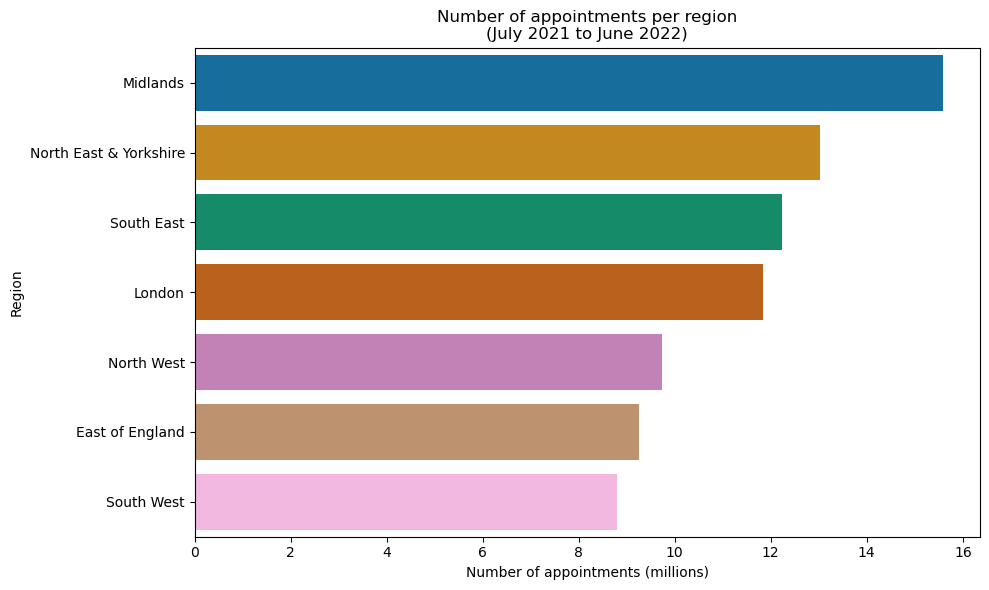

In [235]:
# Sort group_season_ar_202122 into descending order so the chart is more readable.
group_region_ar_202122 = group_region_ar_202122.sort_values(by="count_of_appointments", ascending=False)

# Divide the appointment count by a million so that the y axis will be more readable.
group_region_ar_202122["count_of_appointments"] /= 1000000


# Create bar chart.
standard_horizontal_bar_chart(group_region_ar_202122, "Region", "count_of_appointments", 
                            title="Number of appointments per region\n(July 2021 to June 2022)", 
                            x_label="Region", y_label="Number of appointments (millions)", palette="colorblind", errorbar=None)

The Midlands has the highest number of appointments and the South West the least but note that this does not take into account the number of patients registered in each region. I will create another chart using the number of appointments per patient registered later.

14. Grouped bar chart - How many appointments were there per region (and per season) from July 2021 to June? Only the ar data set will cover a whole year so I'll use ar data.

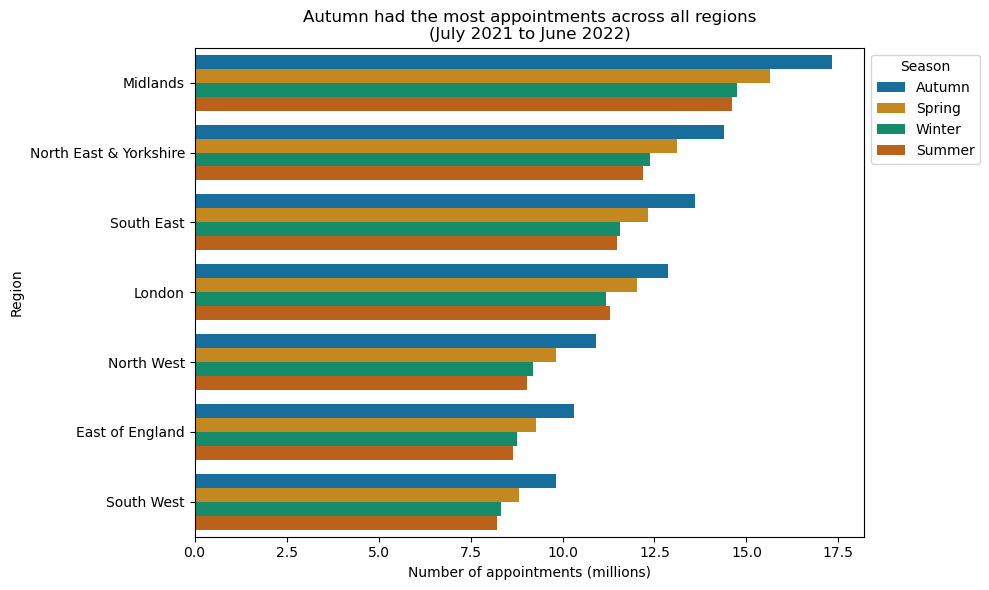

In [238]:
# Create bar chart.
standard_horizontal_bar_chart(group_region_ar_202122, "Region", "count_of_appointments", 
                            title="Autumn had the most appointments across all regions\n(July 2021 to June 2022)", 
                            x_label="Region", y_label="Number of appointments (millions)",
                            legend_title="Season", hue="Season", palette="colorblind", errorbar=None)

Autumn had the most appointments for all the seasons and summer the least number of appointments for the majority of regions. Similar trend across the regions.

15. Grouped bar chart - appointment status by season.

In [241]:
# Group by appointment status and season.
group_status_season_ar_202122 = filter_jul21_jun22.groupby(["appointment_status", "Season"])["count_of_appointments"].sum().reset_index()
group_status_season_ar_202122

appointment_status  Season  count_of_appointments
0            Attended  Autumn               80595237
1            Attended  Spring               74462757
2            Attended  Summer               69558083
3            Attended  Winter               69802618
4      Did not attend  Autumn                4315059
5      Did not attend  Spring                3534861
6      Did not attend  Summer                3146592
7      Did not attend  Winter                3351537
8             Unknown  Autumn                4321109
9             Unknown  Spring                3005988
10            Unknown  Summer                2714793
11            Unknown  Winter                2977355

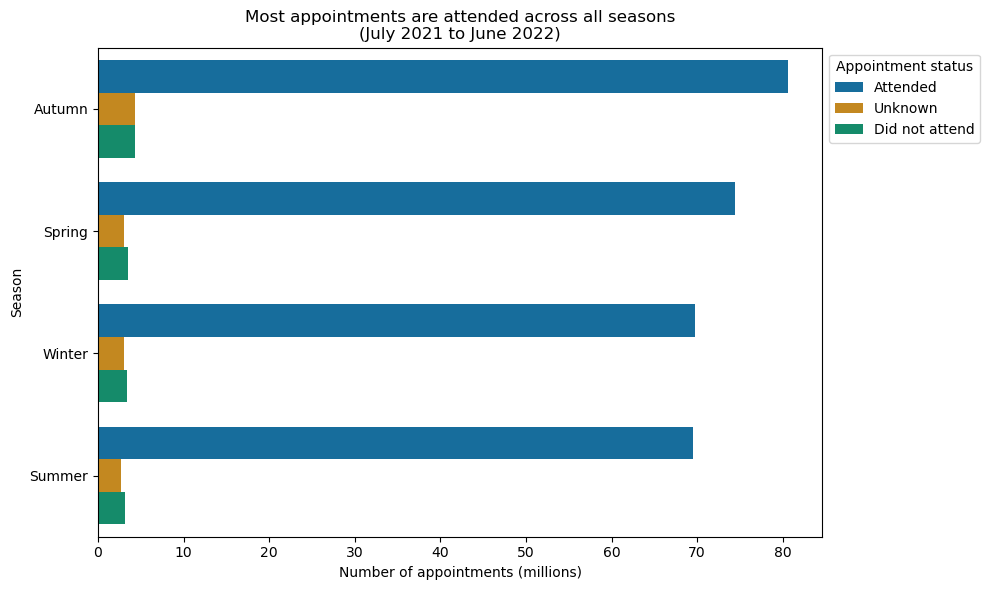

In [242]:
# Sort group_status_season_ar_202122into descending order so the chart is more readable.
group_status_season_ar_202122 = group_status_season_ar_202122.sort_values(by="count_of_appointments", ascending=False)

# Divide the appointment count by a million so that the y axis will be more readable.
group_status_season_ar_202122["count_of_appointments"] /= 1000000

# Create a grouped bar chart.
standard_horizontal_bar_chart(group_status_season_ar_202122, "Season", "count_of_appointments", 
                            title="Most appointments are attended across all seasons\n(July 2021 to June 2022)", 
                            x_label="Season", y_label="Number of appointments (millions)", 
                            legend_title="Appointment status", hue="appointment_status", 
                              palette="colorblind", errorbar=None)

Most appointments were attended for all the seasons.

16. How many days were over the maximum capacity of 1,105,900 appointments per day (between August 2021 and June 2022)?

Above, I found that as an average, no months were over max capacity. I'm wondering whether any individual days are over max capacity.
 
I am using these dates, because it is the maximum range I can use that includes the dates, not just the months. This is using the nc data.

In [245]:
# Group appointment_date.
group_appdate1 = nc.groupby("appointment_date")["count_of_appointments"].sum().reset_index()

# Sort the values into descending order
group_appdate1 = group_appdate1.sort_values(by="count_of_appointments", ascending=False)

# Check if any exceed max capacity.
group_appdate1

appointment_date  count_of_appointments
106       2021-11-15                1480215
71        2021-10-11                1480165
99        2021-11-08                1477922
78        2021-10-18                1465917
113       2021-11-22                1455862
..               ...                    ...
153       2022-01-01                   4891
28        2021-08-29                   4866
308       2022-06-05                   4480
259       2022-04-17                   4242
147       2021-12-26                   3693

[334 rows x 2 columns]

Yes, there are days which exceeded maximum capacity.

In [247]:
# Number of days that exceeded max capacity.
high_capacity = (group_appdate1["count_of_appointments"] >= 1105900).sum()
high_capacity

212

212 days between Aug 2021 and June 2022 that were over capacity. This is slightly surprising as my line graphs above that were grouped by month showed no months over capacity. There must be lots of days that are significantly below max capacity as well.

I'm going to double check this by also calculating the number of days that were under max capacity. I would expect 334 - 212 = 122 days. 334 is the number of days in a year excluding July.

In [249]:
# Number of days that were under max capacity.
under_capacity = (group_appdate1["count_of_appointments"] < 1105900).sum()
under_capacity

122

In [250]:
# Create a bar chart showing the number of days that were above and below max capacity from Aug 2021 to Jun 2022.
# The percentage column is to 1 decimal place.
capacity_data = {
    "Capacity":["Over max capacity", "Under max capacity"],
    "Values":[212, 122],
    "Percentage":[63.5, 36.5]}

capacity = pd.DataFrame(capacity_data)
capacity

Capacity  Values  Percentage
0   Over max capacity     212        63.5
1  Under max capacity     122        36.5

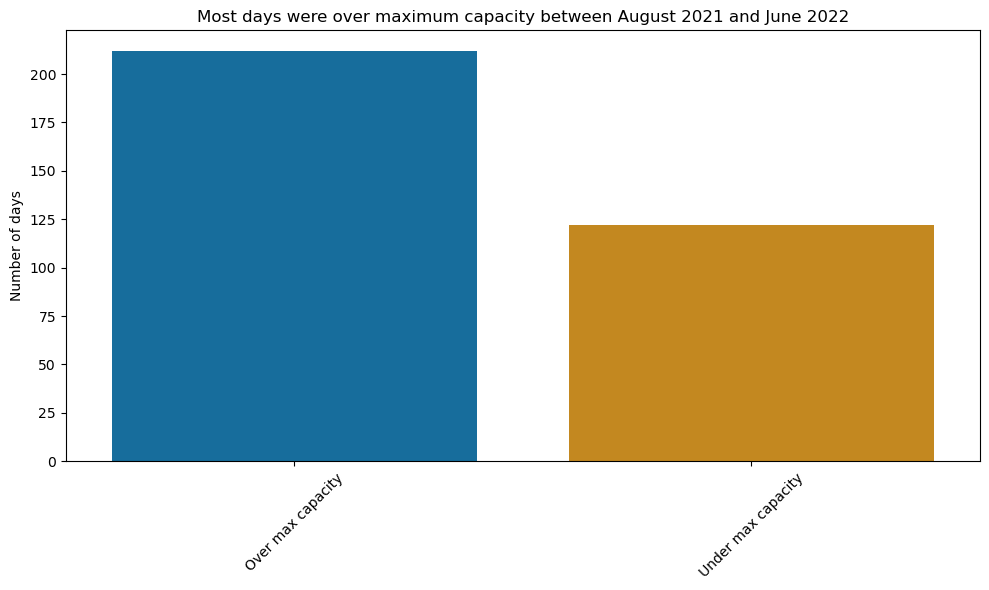

In [251]:
# Create a bar chart using the "Values" column. Don't need a x label.
standard_vertical_bar_chart(capacity, "Capacity", "Values", 
                            title="Most days were over maximum capacity between August 2021 and June 2022",
                            y_label="Number of days", palette="colorblind")

Most days were over max capacity.

I tried to add labels to the top of the bars showing the number of appointments but no method worked.

Create the same bar chart, but using percentages as this may mean more to the stakeholder than the raw numbers of days.

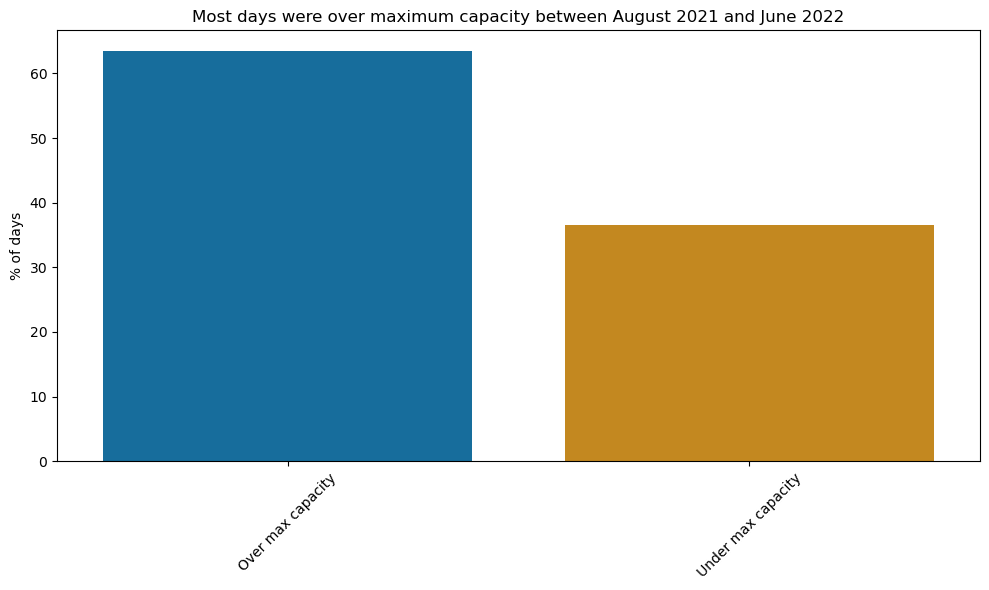

In [255]:
# Create a bar chart using the "Percentage" column. Don't need a x label.
standard_vertical_bar_chart(capacity, "Capacity", "Percentage", 
                            title="Most days were over maximum capacity between August 2021 and June 2022",
                            y_label="% of days", palette="colorblind")

17. How many days were over the maximum capacity of 1,105,900 appointments per day (between August 2021 and June 2022) by month?
I'll create a grouped bar chart.

In [257]:
# Group appointment_date and month.
group_appdate_month = nc.groupby(["appointment_date", "month"])["count_of_appointments"].sum().reset_index()

# Sort the values into descending order
group_appdate_month = group_appdate_month.sort_values(by="count_of_appointments", ascending=False)

group_appdate_month

appointment_date month  count_of_appointments
106       2021-11-15   Nov                1480215
71        2021-10-11   Oct                1480165
99        2021-11-08   Nov                1477922
78        2021-10-18   Oct                1465917
113       2021-11-22   Nov                1455862
..               ...   ...                    ...
153       2022-01-01   Jan                   4891
28        2021-08-29   Aug                   4866
308       2022-06-05   Jun                   4480
259       2022-04-17   Apr                   4242
147       2021-12-26   Dec                   3693

[334 rows x 3 columns]

In [258]:
# Make the table above into a data frame.
appdate_month_capacity = pd.DataFrame(group_appdate_month)
appdate_month_capacity

appointment_date month  count_of_appointments
106       2021-11-15   Nov                1480215
71        2021-10-11   Oct                1480165
99        2021-11-08   Nov                1477922
78        2021-10-18   Oct                1465917
113       2021-11-22   Nov                1455862
..               ...   ...                    ...
153       2022-01-01   Jan                   4891
28        2021-08-29   Aug                   4866
308       2022-06-05   Jun                   4480
259       2022-04-17   Apr                   4242
147       2021-12-26   Dec                   3693

[334 rows x 3 columns]

In [259]:
# Create a "Capacity" column which I can use as the hue on my bar chart.
appdate_month_capacity["Capacity"] = appdate_month_capacity["count_of_appointments"].apply(
    lambda x: "Over max capacity" if x >= 1105900 else "Under max capacity")

appdate_month_capacity

appointment_date month  count_of_appointments            Capacity
106       2021-11-15   Nov                1480215   Over max capacity
71        2021-10-11   Oct                1480165   Over max capacity
99        2021-11-08   Nov                1477922   Over max capacity
78        2021-10-18   Oct                1465917   Over max capacity
113       2021-11-22   Nov                1455862   Over max capacity
..               ...   ...                    ...                 ...
153       2022-01-01   Jan                   4891  Under max capacity
28        2021-08-29   Aug                   4866  Under max capacity
308       2022-06-05   Jun                   4480  Under max capacity
259       2022-04-17   Apr                   4242  Under max capacity
147       2021-12-26   Dec                   3693  Under max capacity

[334 rows x 4 columns]

In [260]:
# Count the number of days per month for each value in the capacity column.
group_count_days_capacity = appdate_month_capacity.groupby(["month", "Capacity"]).size().reset_index(name="num_days")
group_count_days_capacity

month            Capacity  num_days
0    Apr   Over max capacity        19
1    Apr  Under max capacity        11
2    Aug   Over max capacity        10
3    Aug  Under max capacity        21
4    Dec   Over max capacity        16
5    Dec  Under max capacity        15
6    Feb   Over max capacity        19
7    Feb  Under max capacity         9
8    Jan   Over max capacity        20
9    Jan  Under max capacity        11
10   Jun   Over max capacity        20
11   Jun  Under max capacity        10
12   Mar   Over max capacity        23
13   Mar  Under max capacity         8
14   May   Over max capacity        21
15   May  Under max capacity        10
16   Nov   Over max capacity        22
17   Nov  Under max capacity         8
18   Oct   Over max capacity        21
19   Oct  Under max capacity        10
20   Sep   Over max capacity        21
21   Sep  Under max capacity         9

In [261]:
# Sort months into their chronological order.
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Aug", "Sep", "Oct", "Nov", "Dec"]

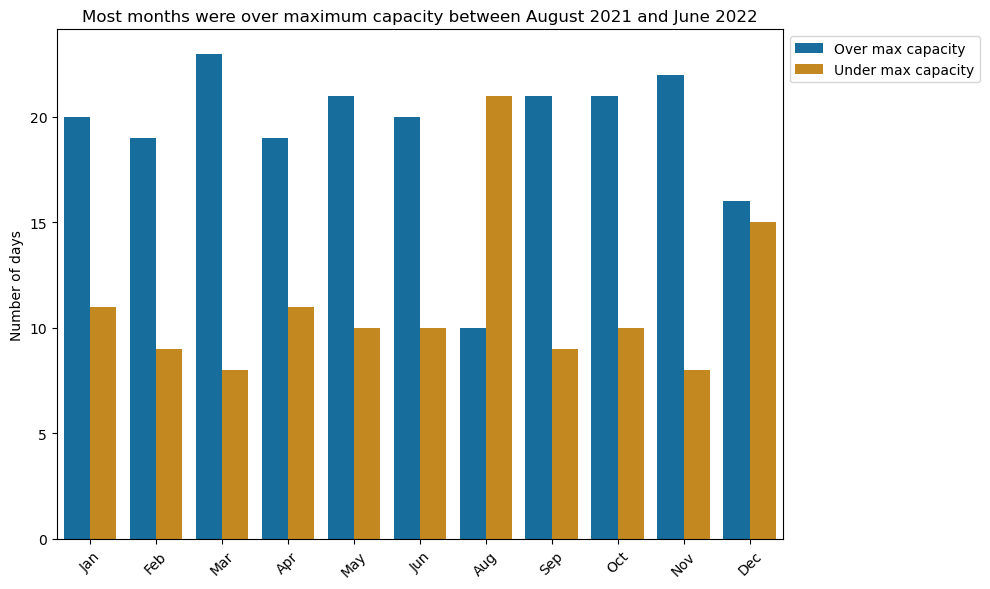

In [262]:
# Create a grouped bar chart by month.
standard_vertical_bar_chart(group_count_days_capacity, "month", "num_days", 
                            title="Most months were over maximum capacity between August 2021 and June 2022",
                            y_label="Number of days", order=month_order, hue="Capacity", palette="colorblind")

Only August had more days under max capacity than over.

18. Create a boxplot showing the spread of appointments per day for each month from August 2021 to June 2022.

In [265]:
# Create a copy of appdate_month_capacity so the original is still there to use later on.
appdate_month_capacity2 = appdate_month_capacity.copy()

# Divide the count of appointments by a million to make the y axis more readable.
appdate_month_capacity2["count_of_appointments"] /= 1000000

appdate_month_capacity2

appointment_date month  count_of_appointments            Capacity
106       2021-11-15   Nov               1.480215   Over max capacity
71        2021-10-11   Oct               1.480165   Over max capacity
99        2021-11-08   Nov               1.477922   Over max capacity
78        2021-10-18   Oct               1.465917   Over max capacity
113       2021-11-22   Nov               1.455862   Over max capacity
..               ...   ...                    ...                 ...
153       2022-01-01   Jan               0.004891  Under max capacity
28        2021-08-29   Aug               0.004866  Under max capacity
308       2022-06-05   Jun               0.004480  Under max capacity
259       2022-04-17   Apr               0.004242  Under max capacity
147       2021-12-26   Dec               0.003693  Under max capacity

[334 rows x 4 columns]

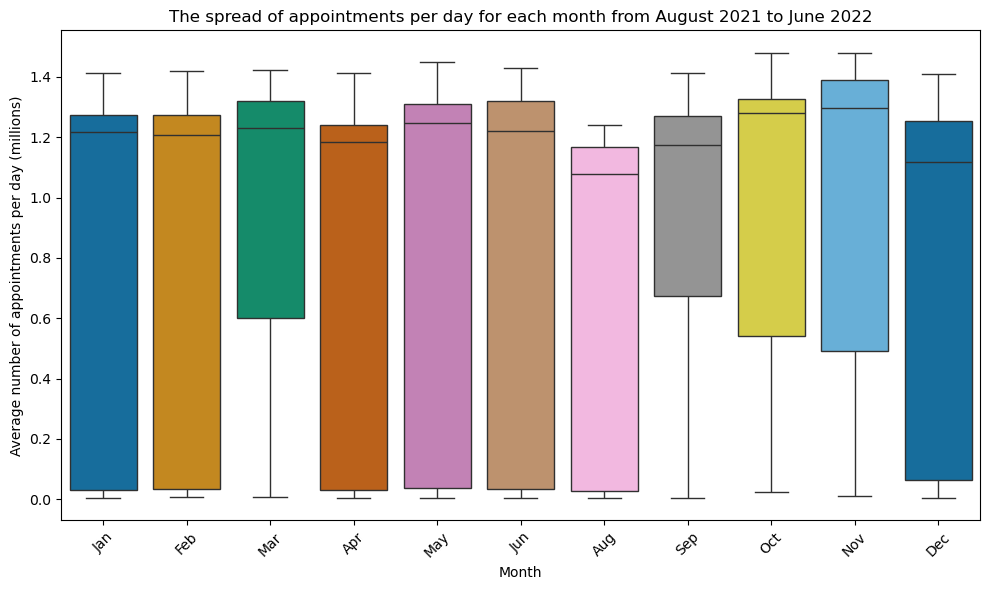

In [266]:
# Create the box plot.
standard_box_plot(appdate_month_capacity2, "month", "count_of_appointments",  
                      title="The spread of appointments per day for each month from August 2021 to June 2022", 
                      x_label="Month", y_label="Average number of appointments per day (millions)", order=month_order, palette="colorblind")

Note: This spread is huge!

I think it might be useful to analyse whether there are certain days of the week that are more busy than others.

19. Create a bar chart showing the number of appointments for each day of the week from August 2021 to June 2022.
(Note that there may not be an equal number of Mondays, Tuesdays etc. but it will be approximate)

In [269]:
appdate_month_capacity2

appointment_date month  count_of_appointments            Capacity
106       2021-11-15   Nov               1.480215   Over max capacity
71        2021-10-11   Oct               1.480165   Over max capacity
99        2021-11-08   Nov               1.477922   Over max capacity
78        2021-10-18   Oct               1.465917   Over max capacity
113       2021-11-22   Nov               1.455862   Over max capacity
..               ...   ...                    ...                 ...
153       2022-01-01   Jan               0.004891  Under max capacity
28        2021-08-29   Aug               0.004866  Under max capacity
308       2022-06-05   Jun               0.004480  Under max capacity
259       2022-04-17   Apr               0.004242  Under max capacity
147       2021-12-26   Dec               0.003693  Under max capacity

[334 rows x 4 columns]

In [270]:
# Create a "day of the week" column.
appdate_month_capacity2["day_of_week"] = appdate_month_capacity2["appointment_date"].dt.day_name()
appdate_month_capacity2

appointment_date month  count_of_appointments            Capacity  \
106       2021-11-15   Nov               1.480215   Over max capacity   
71        2021-10-11   Oct               1.480165   Over max capacity   
99        2021-11-08   Nov               1.477922   Over max capacity   
78        2021-10-18   Oct               1.465917   Over max capacity   
113       2021-11-22   Nov               1.455862   Over max capacity   
..               ...   ...                    ...                 ...   
153       2022-01-01   Jan               0.004891  Under max capacity   
28        2021-08-29   Aug               0.004866  Under max capacity   
308       2022-06-05   Jun               0.004480  Under max capacity   
259       2022-04-17   Apr               0.004242  Under max capacity   
147       2021-12-26   Dec               0.003693  Under max capacity   

    day_of_week  
106      Monday  
71       Monday  
99       Monday  
78       Monday  
113      Monday  
..          ...  
153    Saturday  
28       Sunday  
308      Sunday  
259      Sunday  
147      Sunday  

[334 rows x 5 columns]

In [271]:
# Group by appointment_date and day_of_week.
group_appdate_month_capacity2 = appdate_month_capacity2.groupby(["day_of_week"])["count_of_appointments"].sum().reset_index()

# Approx number of appointments each day of the week. Assume 48 weeks from Aug 2021 to June 2022.
group_appdate_month_capacity2["count_of_appointments"] /= 48
group_appdate_month_capacity2

day_of_week  count_of_appointments
0      Friday               1.091560
1      Monday               1.243651
2    Saturday               0.116144
3      Sunday               0.012795
4    Thursday               1.187007
5     Tuesday               1.287644
6   Wednesday               1.228839

In [272]:
# Create a chronological day order.
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

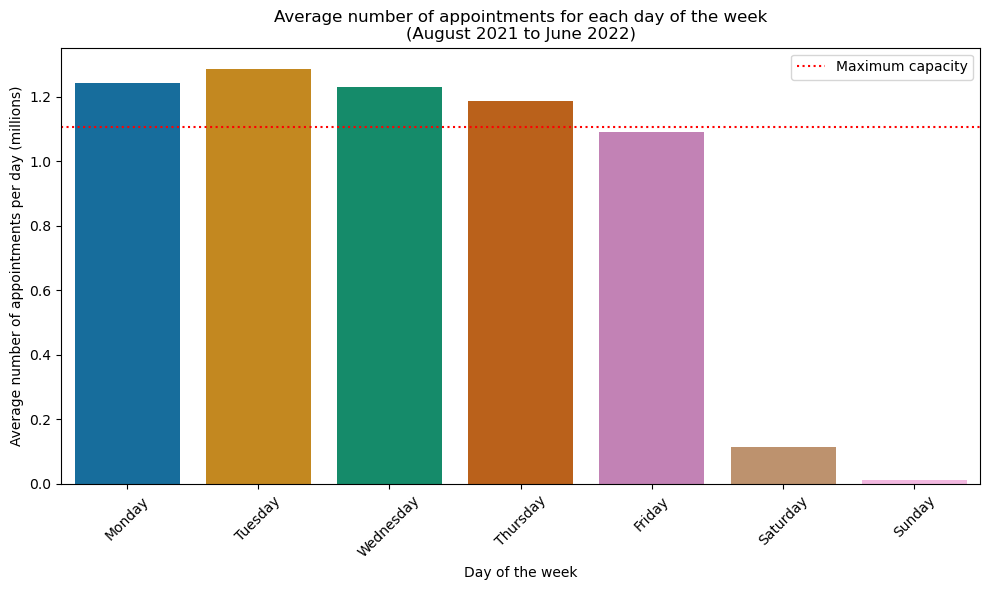

In [273]:
# Create bar chart.
standard_vertical_bar_chart(group_appdate_month_capacity2, "day_of_week", "count_of_appointments",
                            title="Average number of appointments for each day of the week\n(August 2021 to June 2022)",
                            x_label="Day of the week", y_label="Average number of appointments per day (millions)", 
                            hline_y=1.1059, order=day_order, palette="colorblind")

It seems like the weekend dates are having a significant impact on my results. It seems that there is limited access to GP services during the weekend so there are many appointments available to book https://www.pulsetoday.co.uk/news/breaking-news/england-gp-practices-to-open-9-5-on-saturdays-under-contract-update/#:~:text=GPs%20in%20England's%20primary%20care,and%20the%20Network%20Contract%20DES..

I'm going to remove all weekend days then create another bar chart showing the number of appointments that were over or under max capacity excluding weekends. I'm also going to create a time series plot showing this as well and compare it to a time series plot with all days included.

20. Create a bar chart showing the number of appointments that were over or above max capacity from August 2021 to June 2022, excluding weekends.

In [276]:
appdate_month_capacity2

appointment_date month  count_of_appointments            Capacity  \
106       2021-11-15   Nov               1.480215   Over max capacity   
71        2021-10-11   Oct               1.480165   Over max capacity   
99        2021-11-08   Nov               1.477922   Over max capacity   
78        2021-10-18   Oct               1.465917   Over max capacity   
113       2021-11-22   Nov               1.455862   Over max capacity   
..               ...   ...                    ...                 ...   
153       2022-01-01   Jan               0.004891  Under max capacity   
28        2021-08-29   Aug               0.004866  Under max capacity   
308       2022-06-05   Jun               0.004480  Under max capacity   
259       2022-04-17   Apr               0.004242  Under max capacity   
147       2021-12-26   Dec               0.003693  Under max capacity   

    day_of_week  
106      Monday  
71       Monday  
99       Monday  
78       Monday  
113      Monday  
..          ...  
153    Saturday  
28       Sunday  
308      Sunday  
259      Sunday  
147      Sunday  

[334 rows x 5 columns]

In [277]:
# Create a new dataframe that excludes weekends.
capacity_ex_weekends = appdate_month_capacity2[~appdate_month_capacity2["day_of_week"].isin(["Saturday", "Sunday"])]
capacity_ex_weekends

appointment_date month  count_of_appointments            Capacity  \
106       2021-11-15   Nov               1.480215   Over max capacity   
71        2021-10-11   Oct               1.480165   Over max capacity   
99        2021-11-08   Nov               1.477922   Over max capacity   
78        2021-10-18   Oct               1.465917   Over max capacity   
113       2021-11-22   Nov               1.455862   Over max capacity   
..               ...   ...                    ...                 ...   
260       2022-04-18   Apr               0.006683  Under max capacity   
274       2022-05-02   May               0.006622  Under max capacity   
305       2022-06-02   Jun               0.006441  Under max capacity   
306       2022-06-03   Jun               0.005408  Under max capacity   
29        2021-08-30   Aug               0.005344  Under max capacity   

    day_of_week  
106      Monday  
71       Monday  
99       Monday  
78       Monday  
113      Monday  
..          ...  
260      Monday  
274      Monday  
305    Thursday  
306      Friday  
29       Monday  

[239 rows x 5 columns]

In [278]:
# Groupby number of days at each capacity.
group_capacity_ex_weekends = capacity_ex_weekends.groupby("Capacity").size().reset_index(name="num_days")
group_capacity_ex_weekends

Capacity  num_days
0   Over max capacity       212
1  Under max capacity        27

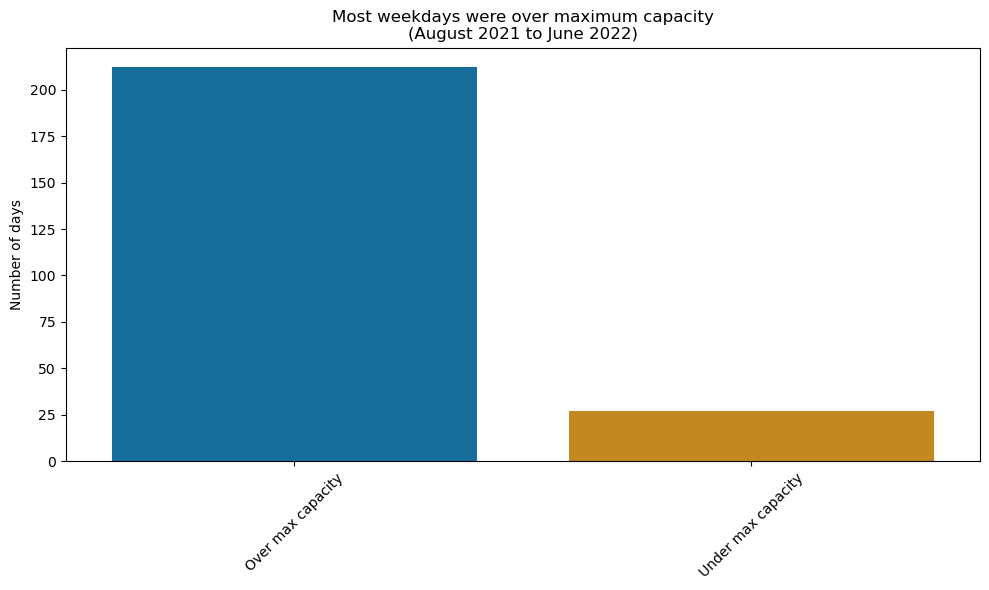

In [279]:
# Create bar chart.
standard_vertical_bar_chart(group_capacity_ex_weekends, "Capacity", "num_days",
                            title="Most weekdays were over maximum capacity\n(August 2021 to June 2022)",
                            y_label="Number of days", palette="colorblind")

21. Create a bar chart showing the percentage of appointments that were over or above max capacity from August 2021 to June 2022, excluding weekends.

In [281]:
# Show this as a percentage.
group_capacity_ex_weekends["percentage"] = group_capacity_ex_weekends["num_days"] * (100/239)
group_capacity_ex_weekends["percentage"] = group_capacity_ex_weekends["percentage"].round(1)
group_capacity_ex_weekends

Capacity  num_days  percentage
0   Over max capacity       212        88.7
1  Under max capacity        27        11.3

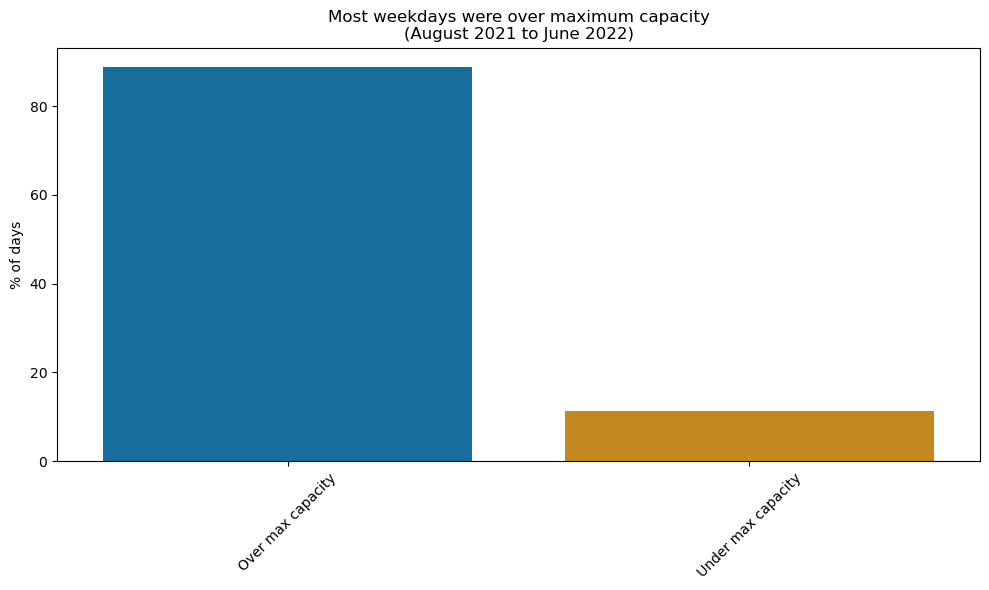

In [282]:
# Create bar chart.
standard_vertical_bar_chart(group_capacity_ex_weekends, "Capacity", "percentage",
                            title="Most weekdays were over maximum capacity\n(August 2021 to June 2022)",
                            y_label="% of days", palette="colorblind")

Excluding weekdays, there is a higher percentage of appointments that are over maximum capacity.

22. Create a boxplot showing the spread of number of appointments over each month from August 2021 to June 2022 (excluding weekends).

In [285]:
capacity_ex_weekends

appointment_date month  count_of_appointments            Capacity  \
106       2021-11-15   Nov               1.480215   Over max capacity   
71        2021-10-11   Oct               1.480165   Over max capacity   
99        2021-11-08   Nov               1.477922   Over max capacity   
78        2021-10-18   Oct               1.465917   Over max capacity   
113       2021-11-22   Nov               1.455862   Over max capacity   
..               ...   ...                    ...                 ...   
260       2022-04-18   Apr               0.006683  Under max capacity   
274       2022-05-02   May               0.006622  Under max capacity   
305       2022-06-02   Jun               0.006441  Under max capacity   
306       2022-06-03   Jun               0.005408  Under max capacity   
29        2021-08-30   Aug               0.005344  Under max capacity   

    day_of_week  
106      Monday  
71       Monday  
99       Monday  
78       Monday  
113      Monday  
..          ...  
260      Monday  
274      Monday  
305    Thursday  
306      Friday  
29       Monday  

[239 rows x 5 columns]

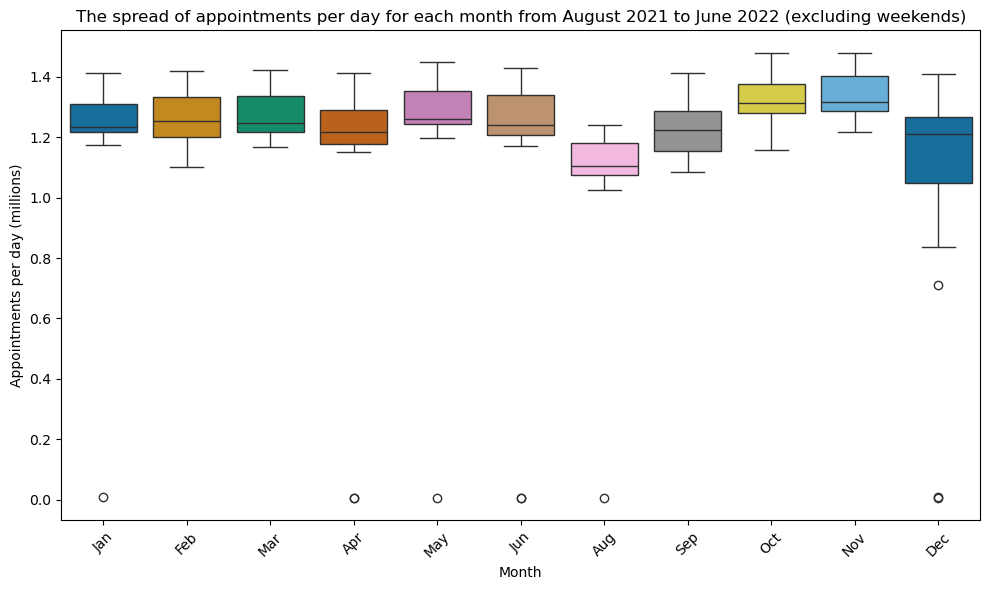

In [286]:
# Create the box plot.
standard_box_plot(capacity_ex_weekends, "month", "count_of_appointments",  
                      title="The spread of appointments per day for each month from August 2021 to June 2022 (excluding weekends)", 
                      x_label="Month", y_label="Appointments per day (millions)", order=month_order, palette="colorblind")

The spread is much less excluding weekends. I assume that the outliers are bank holidays.

23. Create a time series plot showing the number of appointments per day from August 2021 to June 2022 including weekends.
I've also included a trendline.

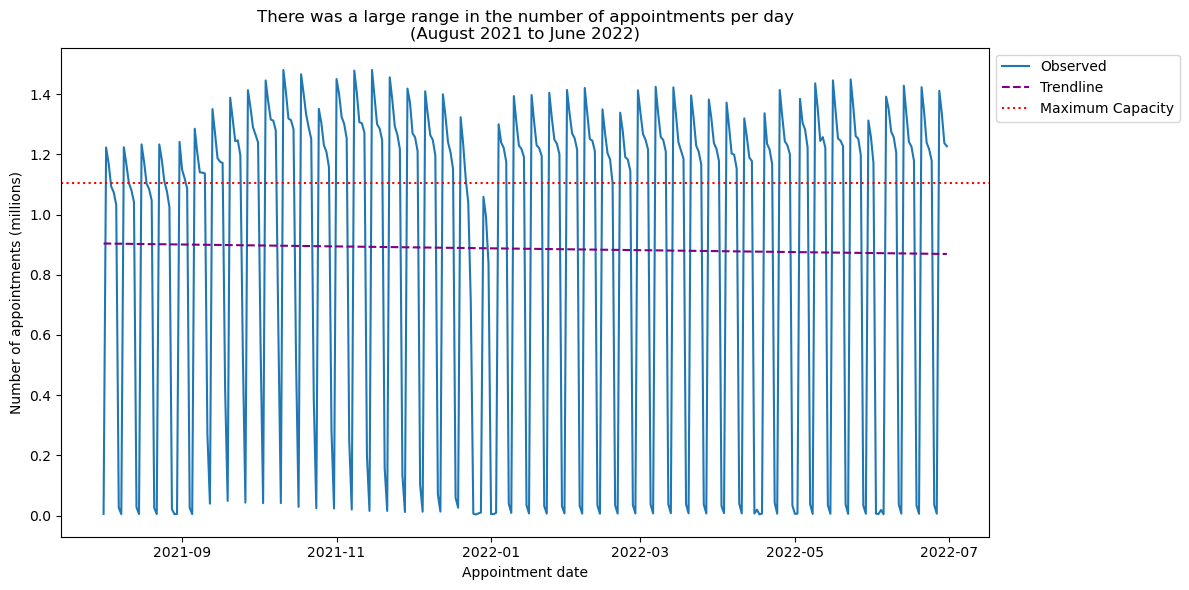

In [289]:
# Time series plot showing the number of appointments per day from August 2021 to June 2022 including weekends.
# Also includes a trendline and the maximum capacity line.
time_series_plot_with_trendline(appdate_month_capacity2, "appointment_date", "count_of_appointments", 
                                title="There was a large range in the number of appointments per day\n(August 2021 to June 2022)", 
                                x_label="Appointment date", y_label="Number of appointments (millions)", hline_y=1.105900)

This graph looks a bit hectic but if I show the appointments per month, it looks like no months are over capacity because of the large range of values (see box plot). 
There is a slight downwards trend but this is not significant.

24. Create a time series plot showing the number of appointments per day from August 2021 to June 2022 excluding weekends.
I've also included a trendline.

In [292]:
capacity_ex_weekends

appointment_date month  count_of_appointments            Capacity  \
106       2021-11-15   Nov               1.480215   Over max capacity   
71        2021-10-11   Oct               1.480165   Over max capacity   
99        2021-11-08   Nov               1.477922   Over max capacity   
78        2021-10-18   Oct               1.465917   Over max capacity   
113       2021-11-22   Nov               1.455862   Over max capacity   
..               ...   ...                    ...                 ...   
260       2022-04-18   Apr               0.006683  Under max capacity   
274       2022-05-02   May               0.006622  Under max capacity   
305       2022-06-02   Jun               0.006441  Under max capacity   
306       2022-06-03   Jun               0.005408  Under max capacity   
29        2021-08-30   Aug               0.005344  Under max capacity   

    day_of_week  
106      Monday  
71       Monday  
99       Monday  
78       Monday  
113      Monday  
..          ...  
260      Monday  
274      Monday  
305    Thursday  
306      Friday  
29       Monday  

[239 rows x 5 columns]

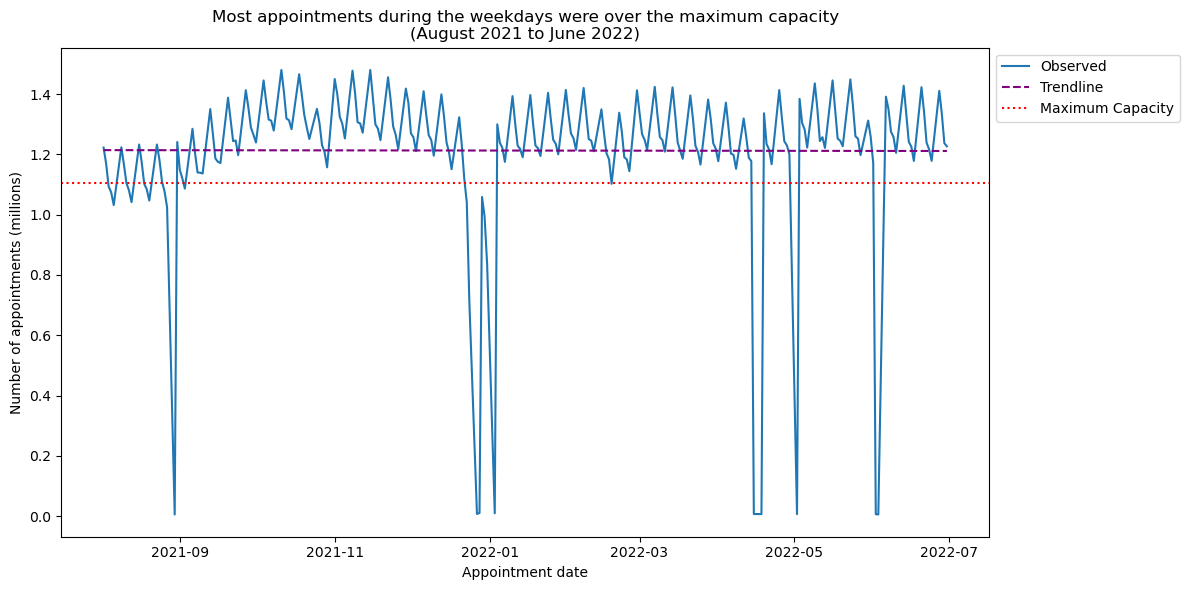

In [293]:
# Time series plot showing the number of appointments per day from August 2021 to June 2022 excluding weekends.
# Also includes a trendline and the maximum capacity line.
time_series_plot_with_trendline(capacity_ex_weekends, "appointment_date", "count_of_appointments", 
                                title="Most appointments during the weekdays were over the maximum capacity\n(August 2021 to June 2022)", 
                                x_label="Appointment date", y_label="Number of appointments (millions)", hline_y=1.105900)

A completely different story! Most week days are over capacity and, again, I'm assuming that the outliers are bank holidays.

25. Create a bar chart showing the number of patients registered in each region in June 2022.

In [296]:
prpr.head(5)

month_year                  region  patients_total  year
0    2022-06  North East & Yorkshire         9035341  2022
1    2021-12  North East & Yorkshire         9012291  2021
2    2021-06  North East & Yorkshire         8961942  2021
3    2020-12  North East & Yorkshire         9254057  2020
4    2020-06  North East & Yorkshire         9230439  2020

In [297]:
# Filter month_year column for 2020-06.
prpr_june_2022 = prpr[prpr["month_year"].dt.strftime('%Y-%m') == "2022-06"]
prpr_june_2022

month_year                  region  patients_total  year
0     2022-06  North East & Yorkshire         9035341  2022
5     2022-06              North West         7736969  2022
10    2022-06                Midlands        11547486  2022
15    2022-06              South West         6006933  2022
20    2022-06                  London        10682806  2022
25    2022-06              South East         9599810  2022
30    2022-06         East of England         7106121  2022

In [298]:
# Sort patients_total in descending order so the bar chart is neater.
prpr_june_2022 = prpr_june_2022.sort_values(by="patients_total", ascending=False)
prpr_june_2022

month_year                  region  patients_total  year
10    2022-06                Midlands        11547486  2022
20    2022-06                  London        10682806  2022
25    2022-06              South East         9599810  2022
0     2022-06  North East & Yorkshire         9035341  2022
5     2022-06              North West         7736969  2022
30    2022-06         East of England         7106121  2022
15    2022-06              South West         6006933  2022

In [299]:
# Create a copy of prpr_june_2022. This is so I can use prpr_june_2022 in this format later on.
prpr_june_2022b = prpr_june_2022.copy()

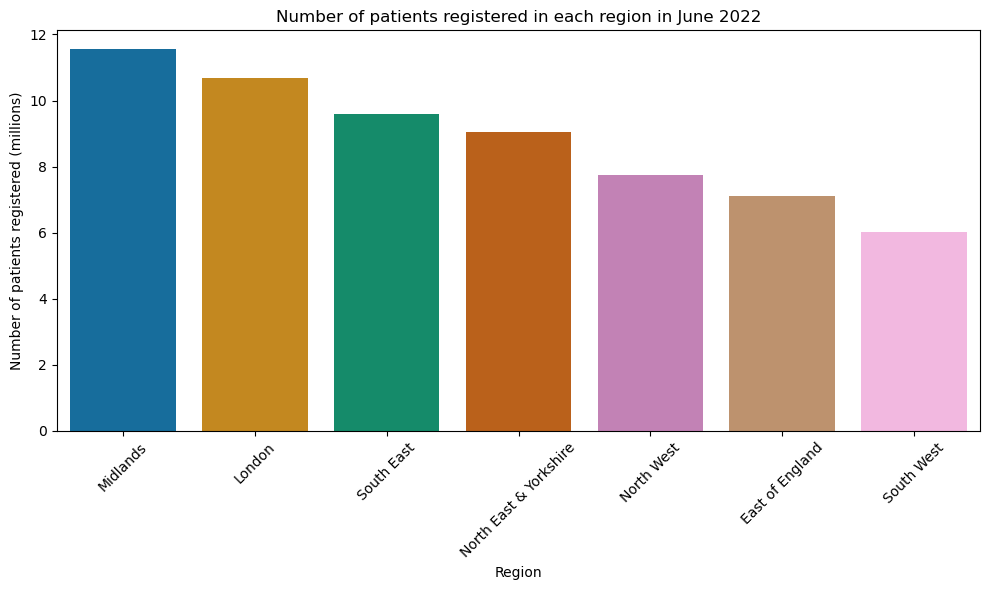

In [300]:
# Divide patients_total by 1000000 to make the y axis more readable.

prpr_june_2022["patients_total"] /= 1000000

# Create bar chart.
standard_vertical_bar_chart(prpr_june_2022, "region", "patients_total",
                            title="Number of patients registered in each region in June 2022",
                            x_label="Region", y_label="Number of patients registered (millions)", palette="colorblind")

As there is a large variety in the number of patients per region, it's not useful to analyse the data using the count of appointments from each region. For example, the South West might look like it doesn't have many appointments but it might in fact be over capacity.

Therefore, I'm going to create a new metric: the average number of appointments per patient registered.
total count of appointments for the regionthe number of patients registered in the region.

Even though there is a slight variation in the number of patients registered in each region in June 2022, Dec, 2021, June 2021 etc., it is only slight so I am going to use the June 2022 number of patients registered. 

For the benchmark for the maximum appointment capacity I'm going to use the max capacity per day number of 1,105,900 and the total patients registered in June 2022 as 61,715,466. Note that the total number of patients registered is higher than the population of England. This may be because patients aren't getting deregistered when they move home. This is a limitation of the data.

I'm first going to create a new column "av_nappoint_per_patient" for ad, ar, and nc.

ad

In [304]:
ad.head(2)

icb_ons_code sub_icb_location_code  \
0    E54000050                   00L   
1    E54000050                   00L   

                        sub_icb_location_name appointment_date  year month  \
0  NHS North East and North Cumbria ICB - 00L       2021-12-01  2021   Dec   
1  NHS North East and North Cumbria ICB - 00L       2021-12-01  2021   Dec   

  actual_duration  count_of_appointments region_ons_code  \
0   31-60 Minutes                    364       E40000012   
1   21-30 Minutes                    619       E40000012   

  sub_icb_location_ons_code                  Region  Season  
0                 E38000130  North East & Yorkshire  Winter  
1                 E38000130  North East & Yorkshire  Winter

In [305]:
# Group by region.
group_ad_region = ad.groupby(["Region", "appointment_date"])["count_of_appointments"].sum().reset_index()
group_ad_region

Region appointment_date  count_of_appointments
0     East of England       2021-12-01                 135906
1     East of England       2021-12-02                 133672
2     East of England       2021-12-03                 129938
3     East of England       2021-12-04                   9852
4     East of England       2021-12-05                   1139
...               ...              ...                    ...
1479       South West       2022-06-26                    470
1480       South West       2022-06-27                 143126
1481       South West       2022-06-28                 133349
1482       South West       2022-06-29                 124566
1483       South West       2022-06-30                 123947

[1484 rows x 3 columns]

In [306]:
# Convert group_ad_region and prpr_region_june2022 to data frames so I can merge them.
group_ad_region_df = pd.DataFrame(group_ad_region)
prpr_region_june_2022_df = pd.DataFrame(prpr_june_2022b)

In [307]:
prpr_region_june_2022_df

month_year                  region  patients_total  year
10    2022-06                Midlands        11547486  2022
20    2022-06                  London        10682806  2022
25    2022-06              South East         9599810  2022
0     2022-06  North East & Yorkshire         9035341  2022
5     2022-06              North West         7736969  2022
30    2022-06         East of England         7106121  2022
15    2022-06              South West         6006933  2022

In [308]:
# Rename column so that "region" has the same case in both data frames.
group_ad_region_df.rename(columns={"Region": "region"}, inplace=True)
group_ad_region_df

region appointment_date  count_of_appointments
0     East of England       2021-12-01                 135906
1     East of England       2021-12-02                 133672
2     East of England       2021-12-03                 129938
3     East of England       2021-12-04                   9852
4     East of England       2021-12-05                   1139
...               ...              ...                    ...
1479       South West       2022-06-26                    470
1480       South West       2022-06-27                 143126
1481       South West       2022-06-28                 133349
1482       South West       2022-06-29                 124566
1483       South West       2022-06-30                 123947

[1484 rows x 3 columns]

In [309]:
# Merge these data frames.
merge_ad_prpr_region_june2022 = pd.merge(group_ad_region_df, prpr_region_june_2022_df, on="region", how="left")
merge_ad_prpr_region_june2022

region appointment_date  count_of_appointments month_year  \
0     East of England       2021-12-01                 135906    2022-06   
1     East of England       2021-12-02                 133672    2022-06   
2     East of England       2021-12-03                 129938    2022-06   
3     East of England       2021-12-04                   9852    2022-06   
4     East of England       2021-12-05                   1139    2022-06   
...               ...              ...                    ...        ...   
1479       South West       2022-06-26                    470    2022-06   
1480       South West       2022-06-27                 143126    2022-06   
1481       South West       2022-06-28                 133349    2022-06   
1482       South West       2022-06-29                 124566    2022-06   
1483       South West       2022-06-30                 123947    2022-06   

      patients_total  year  
0            7106121  2022  
1            7106121  2022  
2            7106121  2022  
3            7106121  2022  
4            7106121  2022  
...              ...   ...  
1479         6006933  2022  
1480         6006933  2022  
1481         6006933  2022  
1482         6006933  2022  
1483         6006933  2022  

[1484 rows x 6 columns]

In [310]:
# Drop month_year and year columns.
merge_ad_prpr_region_june2022 = merge_ad_prpr_region_june2022.drop(["month_year", "year"], axis=1)
merge_ad_prpr_region_june2022

region appointment_date  count_of_appointments  patients_total
0     East of England       2021-12-01                 135906         7106121
1     East of England       2021-12-02                 133672         7106121
2     East of England       2021-12-03                 129938         7106121
3     East of England       2021-12-04                   9852         7106121
4     East of England       2021-12-05                   1139         7106121
...               ...              ...                    ...             ...
1479       South West       2022-06-26                    470         6006933
1480       South West       2022-06-27                 143126         6006933
1481       South West       2022-06-28                 133349         6006933
1482       South West       2022-06-29                 124566         6006933
1483       South West       2022-06-30                 123947         6006933

[1484 rows x 4 columns]

In [311]:
# Create av_nappoint_per_patient column (average number of appointments per patient registered each day).
merge_ad_prpr_region_june2022["av_nappoint_per_patient"] = \
merge_ad_prpr_region_june2022["count_of_appointments"]/merge_ad_prpr_region_june2022["patients_total"]

merge_ad_prpr_region_june2022

region appointment_date  count_of_appointments  patients_total  \
0     East of England       2021-12-01                 135906         7106121   
1     East of England       2021-12-02                 133672         7106121   
2     East of England       2021-12-03                 129938         7106121   
3     East of England       2021-12-04                   9852         7106121   
4     East of England       2021-12-05                   1139         7106121   
...               ...              ...                    ...             ...   
1479       South West       2022-06-26                    470         6006933   
1480       South West       2022-06-27                 143126         6006933   
1481       South West       2022-06-28                 133349         6006933   
1482       South West       2022-06-29                 124566         6006933   
1483       South West       2022-06-30                 123947         6006933   

      av_nappoint_per_patient  
0                    0.019125  
1                    0.018811  
2                    0.018285  
3                    0.001386  
4                    0.000160  
...                       ...  
1479                 0.000078  
1480                 0.023827  
1481                 0.022199  
1482                 0.020737  
1483                 0.020634  

[1484 rows x 5 columns]

25. Check the data by creating a bar chart to compare the number of appointments per patient registered in June 2022.

In [313]:
# Check to see if this makes sense by creating a bar chart.
# Convert to a pandas period type to remove the date and create an "appointment_month" column.
merge_ad_prpr_region_june2022['appointment_month'] = merge_ad_prpr_region_june2022['appointment_date'].dt.to_period('M')

# Filter month_year column for 2020-06.
filter_merge_ad_prpr_region_june2022 = merge_ad_prpr_region_june2022[merge_ad_prpr_region_june2022["appointment_date"]\
.dt.strftime('%Y-%m') == "2022-06"]
filter_merge_ad_prpr_region_june2022

region appointment_date  count_of_appointments  patients_total  \
182   East of England       2022-06-01                 124625         7106121   
183   East of England       2022-06-02                    663         7106121   
184   East of England       2022-06-03                    433         7106121   
185   East of England       2022-06-04                   2203         7106121   
186   East of England       2022-06-05                    741         7106121   
...               ...              ...                    ...             ...   
1479       South West       2022-06-26                    470         6006933   
1480       South West       2022-06-27                 143126         6006933   
1481       South West       2022-06-28                 133349         6006933   
1482       South West       2022-06-29                 124566         6006933   
1483       South West       2022-06-30                 123947         6006933   

      av_nappoint_per_patient appointment_month  
182                  0.017538           2022-06  
183                  0.000093           2022-06  
184                  0.000061           2022-06  
185                  0.000310           2022-06  
186                  0.000104           2022-06  
...                       ...               ...  
1479                 0.000078           2022-06  
1480                 0.023827           2022-06  
1481                 0.022199           2022-06  
1482                 0.020737           2022-06  
1483                 0.020634           2022-06  

[210 rows x 6 columns]

In [314]:
# Group by region and appointment month.
group_merge_ad = filter_merge_ad_prpr_region_june2022.groupby(["region", "appointment_month"])["av_nappoint_per_patient"].sum().reset_index()
group_merge_ad

region appointment_month  av_nappoint_per_patient
0         East of England           2022-06                 0.389091
1                  London           2022-06                 0.327090
2                Midlands           2022-06                 0.398634
3  North East & Yorkshire           2022-06                 0.427067
4              North West           2022-06                 0.360636
5              South East           2022-06                 0.375974
6              South West           2022-06                 0.431957

In [315]:
# Sort the values so bar chart is more readable.
group_merge_ad = group_merge_ad.sort_values(by="av_nappoint_per_patient", ascending=False)
group_merge_ad

region appointment_month  av_nappoint_per_patient
6              South West           2022-06                 0.431957
3  North East & Yorkshire           2022-06                 0.427067
2                Midlands           2022-06                 0.398634
0         East of England           2022-06                 0.389091
5              South East           2022-06                 0.375974
4              North West           2022-06                 0.360636
1                  London           2022-06                 0.327090

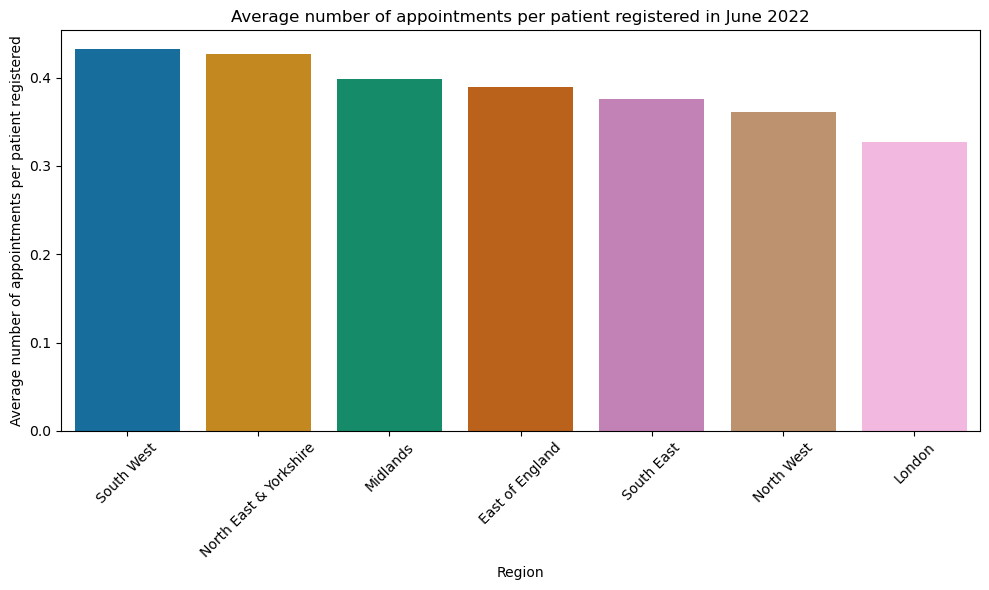

In [316]:
# Create bar chart.
standard_vertical_bar_chart(group_merge_ad, "region", "av_nappoint_per_patient",
                            title="Average number of appointments per patient registered in June 2022",
                            x_label="Region", y_label="Average number of appointments per patient registered", palette="colorblind")

The South West and the North East & Yorkshire have the highest number of appointments per patient registered suggested that there might be more strain on services in these regions.

26. Create a bar chart showing the number of appointments per patients registered for the period July 2021 to June 2022.

First, create an av_nappoint_per_patient column using the ar data.

In [320]:
# Group by region.
group_ar_region = ar.groupby(["Region", "appointment_month"])["count_of_appointments"].sum().reset_index()
group_ar_region

Region appointment_month  count_of_appointments
0    East of England           2020-01                3192308
1    East of England           2020-02                2827790
2    East of England           2020-03                2865248
3    East of England           2020-04                1927799
4    East of England           2020-05                1970358
..               ...               ...                    ...
205       South West           2022-02                2756950
206       South West           2022-03                3206139
207       South West           2022-04                2612333
208       South West           2022-05                2990462
209       South West           2022-06                2795081

[210 rows x 3 columns]

In [321]:
# Convert group_ar_region to a data frames so I can merge.
group_ar_region_df = pd.DataFrame(group_ar_region)

In [322]:
# Rename column so that "region" has the same case in both data frames.
group_ar_region_df.rename(columns={"Region": "region"}, inplace=True)
group_ar_region_df

region appointment_month  count_of_appointments
0    East of England           2020-01                3192308
1    East of England           2020-02                2827790
2    East of England           2020-03                2865248
3    East of England           2020-04                1927799
4    East of England           2020-05                1970358
..               ...               ...                    ...
205       South West           2022-02                2756950
206       South West           2022-03                3206139
207       South West           2022-04                2612333
208       South West           2022-05                2990462
209       South West           2022-06                2795081

[210 rows x 3 columns]

In [323]:
# Merge these data frames.
merge_ar_prpr_region = pd.merge(group_ar_region_df, prpr_region_june_2022_df, on="region", how="left")
merge_ar_prpr_region

region appointment_month  count_of_appointments month_year  \
0    East of England           2020-01                3192308    2022-06   
1    East of England           2020-02                2827790    2022-06   
2    East of England           2020-03                2865248    2022-06   
3    East of England           2020-04                1927799    2022-06   
4    East of England           2020-05                1970358    2022-06   
..               ...               ...                    ...        ...   
205       South West           2022-02                2756950    2022-06   
206       South West           2022-03                3206139    2022-06   
207       South West           2022-04                2612333    2022-06   
208       South West           2022-05                2990462    2022-06   
209       South West           2022-06                2795081    2022-06   

     patients_total  year  
0           7106121  2022  
1           7106121  2022  
2           7106121  2022  
3           7106121  2022  
4           7106121  2022  
..              ...   ...  
205         6006933  2022  
206         6006933  2022  
207         6006933  2022  
208         6006933  2022  
209         6006933  2022  

[210 rows x 6 columns]

In [324]:
# Drop month_year and year columns.
merge_ar_prpr_region = merge_ar_prpr_region.drop(["month_year", "year"], axis=1)
merge_ar_prpr_region

region appointment_month  count_of_appointments  patients_total
0    East of England           2020-01                3192308         7106121
1    East of England           2020-02                2827790         7106121
2    East of England           2020-03                2865248         7106121
3    East of England           2020-04                1927799         7106121
4    East of England           2020-05                1970358         7106121
..               ...               ...                    ...             ...
205       South West           2022-02                2756950         6006933
206       South West           2022-03                3206139         6006933
207       South West           2022-04                2612333         6006933
208       South West           2022-05                2990462         6006933
209       South West           2022-06                2795081         6006933

[210 rows x 4 columns]

In [325]:
# Create av_nappoint_per_patient column (average number of appointments per patient registered each day).
merge_ar_prpr_region["av_nappoint_per_patient"] = \
merge_ar_prpr_region["count_of_appointments"]/merge_ar_prpr_region["patients_total"]

merge_ar_prpr_region

region appointment_month  count_of_appointments  patients_total  \
0    East of England           2020-01                3192308         7106121   
1    East of England           2020-02                2827790         7106121   
2    East of England           2020-03                2865248         7106121   
3    East of England           2020-04                1927799         7106121   
4    East of England           2020-05                1970358         7106121   
..               ...               ...                    ...             ...   
205       South West           2022-02                2756950         6006933   
206       South West           2022-03                3206139         6006933   
207       South West           2022-04                2612333         6006933   
208       South West           2022-05                2990462         6006933   
209       South West           2022-06                2795081         6006933   

     av_nappoint_per_patient  
0                   0.449234  
1                   0.397937  
2                   0.403208  
3                   0.271287  
4                   0.277276  
..                       ...  
205                 0.458961  
206                 0.533740  
207                 0.434886  
208                 0.497835  
209                 0.465309  

[210 rows x 5 columns]

In [326]:
# Filter the data between July 2021 and June 2022 so I can work out the average appointments over a year.
filter_merge_ar_prpr_region = merge_ar_prpr_region[
    (merge_ar_prpr_region["appointment_month"] >= "2021-07-01") &
    (merge_ar_prpr_region["appointment_month"] <= "2022-06-30")]
filter_merge_ar_prpr_region

region appointment_month  count_of_appointments  patients_total  \
19   East of England           2021-08                2723599         7106121   
20   East of England           2021-09                3297004         7106121   
21   East of England           2021-10                3545285         7106121   
22   East of England           2021-11                3480448         7106121   
23   East of England           2021-12                2901948         7106121   
..               ...               ...                    ...             ...   
205       South West           2022-02                2756950         6006933   
206       South West           2022-03                3206139         6006933   
207       South West           2022-04                2612333         6006933   
208       South West           2022-05                2990462         6006933   
209       South West           2022-06                2795081         6006933   

     av_nappoint_per_patient  
19                  0.383275  
20                  0.463967  
21                  0.498906  
22                  0.489782  
23                  0.408373  
..                       ...  
205                 0.458961  
206                 0.533740  
207                 0.434886  
208                 0.497835  
209                 0.465309  

[77 rows x 5 columns]

In [327]:
# Group by region so I get av_nappoint_per_patient per year.
group_filter_merge_ar_prpr_region = filter_merge_ar_prpr_region.groupby("region")["av_nappoint_per_patient"].sum().reset_index()

group_filter_merge_ar_prpr_region

region  av_nappoint_per_patient
0         East of England                 4.792354
1                  London                 4.070507
2                Midlands                 4.966651
3  North East & Yorkshire                 5.303172
4              North West                 4.635596
5              South East                 4.687961
6              South West                 5.388773

In [328]:
# Sort the values so bar chart is more readable.
group_filter_merge_ar_prpr_region = group_filter_merge_ar_prpr_region.sort_values(by="av_nappoint_per_patient", ascending=False)
group_filter_merge_ar_prpr_region

region  av_nappoint_per_patient
6              South West                 5.388773
3  North East & Yorkshire                 5.303172
2                Midlands                 4.966651
0         East of England                 4.792354
5              South East                 4.687961
4              North West                 4.635596
1                  London                 4.070507

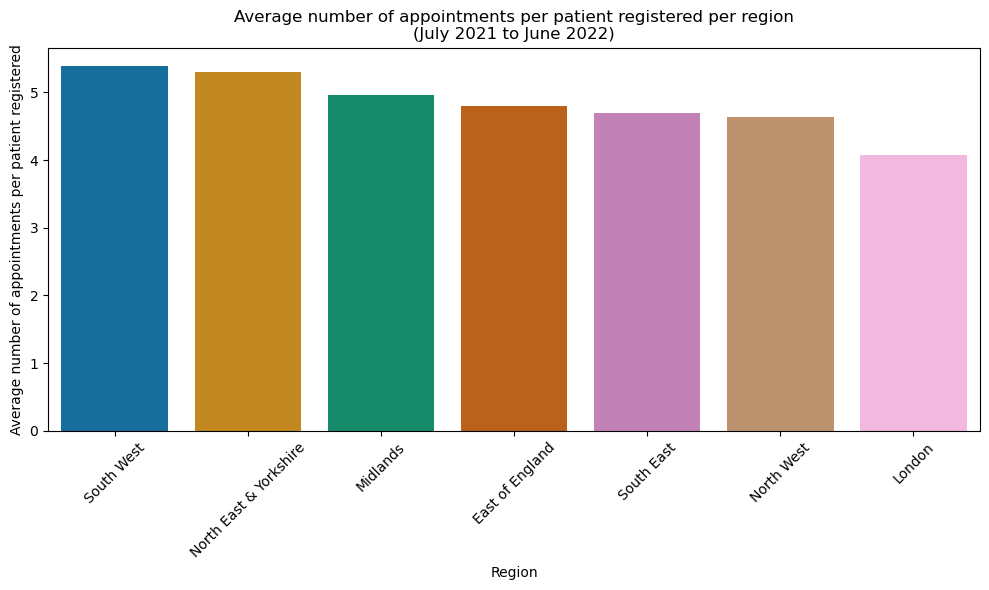

In [329]:
# Create bar chart.
standard_vertical_bar_chart(group_filter_merge_ar_prpr_region, "region", "av_nappoint_per_patient",
                            title="Average number of appointments per patient registered per region\n(July 2021 to June 2022)",
                            x_label="Region", y_label="Average number of appointments per patient registered", 
                            palette="colorblind")

Same result as the previous chart.

28. Create a line chart showing the the average monthly total of appointments per patient registered by region.
For July 2021 to June 2022.

In [332]:
filter_merge_ar_prpr_region

region appointment_month  count_of_appointments  patients_total  \
19   East of England           2021-08                2723599         7106121   
20   East of England           2021-09                3297004         7106121   
21   East of England           2021-10                3545285         7106121   
22   East of England           2021-11                3480448         7106121   
23   East of England           2021-12                2901948         7106121   
..               ...               ...                    ...             ...   
205       South West           2022-02                2756950         6006933   
206       South West           2022-03                3206139         6006933   
207       South West           2022-04                2612333         6006933   
208       South West           2022-05                2990462         6006933   
209       South West           2022-06                2795081         6006933   

     av_nappoint_per_patient  
19                  0.383275  
20                  0.463967  
21                  0.498906  
22                  0.489782  
23                  0.408373  
..                       ...  
205                 0.458961  
206                 0.533740  
207                 0.434886  
208                 0.497835  
209                 0.465309  

[77 rows x 5 columns]

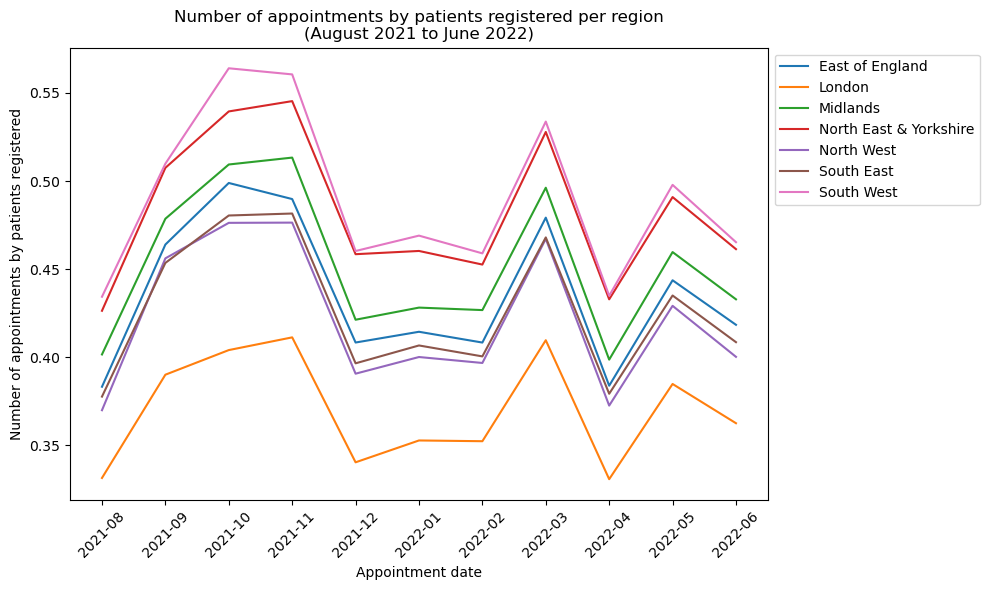

In [333]:
standard_line_plot(filter_merge_ar_prpr_region, "appointment_month", "av_nappoint_per_patient", 
                   title="Number of appointments by patients registered per region\n(August 2021 to June 2022)", 
                   y_label="Appointment date", x_label="Number of appointments by patients registered", hue="region")

This shows the same as the previous bar chart, but adds that the trend across time is similar for each of the regions.

29. Bar chart - Percentage of appointments that were attended or not by month from July 2021 to June 2022.
I unfortunately can't analyse this by days of the week as I only have appointment month.

In [336]:
ar.head(2)

icb_ons_code appointment_month appointment_status hcp_type appointment_mode  \
0    E54000034           2020-01           Attended       GP     Face-to-Face   
1    E54000034           2020-01           Attended       GP     Face-to-Face   

  time_between_book_and_appointment  count_of_appointments month  year  \
0                             1 Day                   8107   Jan  2020   
1                    15  to 21 Days                   6791   Jan  2020   

       Region  Season  
0  South East  Winter  
1  South East  Winter

In [337]:
# Group the filtered data frame by "month", "appointment_status", and "count_of_appointments".
group_ar_filtered_202122_attended = ar_filtered_202122.groupby(["appointment_status", "month"])\
                                ["count_of_appointments"].sum().reset_index()
group_ar_filtered_202122_attended

appointment_status month  count_of_appointments
0            Attended   Apr               21948814
1            Attended   Aug               22081765
2            Attended   Dec               22853483
3            Attended   Feb               23351939
4            Attended   Jan               23597196
5            Attended   Jul               23761001
6            Attended   Jun               23715317
7            Attended   Mar               27170002
8            Attended   May               25343941
9            Attended   Nov               27667665
10           Attended   Oct               27170506
11           Attended   Sep               25757066
12     Did not attend   Apr                1045455
13     Did not attend   Aug                 949137
14     Did not attend   Dec                1198866
15     Did not attend   Feb                1076658
16     Did not attend   Jan                1076013
17     Did not attend   Jul                1029665
18     Did not attend   Jun                1167790
19     Did not attend   Mar                1289888
20     Did not attend   May                1199518
21     Did not attend   Nov                1428087
22     Did not attend   Oct                1565624
23     Did not attend   Sep                1321348
24            Unknown   Apr                 918791
25            Unknown   Aug                 821269
26            Unknown   Dec                1088427
27            Unknown   Feb                 926663
28            Unknown   Jan                 962265
29            Unknown   Jul                 948553
30            Unknown   Jun                 944971
31            Unknown   Mar                1135148
32            Unknown   May                 952049
33            Unknown   Nov                1309318
34            Unknown   Oct                1567704
35            Unknown   Sep                1444087

In [338]:
# Add a total number of appointments per month column.
total_app_month = group_ar_filtered_202122_attended.groupby("month")["count_of_appointments"].sum().reset_index()
total_app_month

# Rename "count_of appointments".
total_app_month.rename(columns={"count_of_appointments":"total_appointments"}, inplace=True)

# Merge total_app_month with group_ar_filtered_202122_attended.
group_ar_filtered_202122_attended_merge = group_ar_filtered_202122_attended.merge(total_app_month, how="left", on="month")
group_ar_filtered_202122_attended_merge                               

appointment_status month  count_of_appointments  total_appointments
0            Attended   Apr               21948814            23913060
1            Attended   Aug               22081765            23852171
2            Attended   Dec               22853483            25140776
3            Attended   Feb               23351939            25355260
4            Attended   Jan               23597196            25635474
5            Attended   Jul               23761001            25739219
6            Attended   Jun               23715317            25828078
7            Attended   Mar               27170002            29595038
8            Attended   May               25343941            27495508
9            Attended   Nov               27667665            30405070
10           Attended   Oct               27170506            30303834
11           Attended   Sep               25757066            28522501
12     Did not attend   Apr                1045455            23913060
13     Did not attend   Aug                 949137            23852171
14     Did not attend   Dec                1198866            25140776
15     Did not attend   Feb                1076658            25355260
16     Did not attend   Jan                1076013            25635474
17     Did not attend   Jul                1029665            25739219
18     Did not attend   Jun                1167790            25828078
19     Did not attend   Mar                1289888            29595038
20     Did not attend   May                1199518            27495508
21     Did not attend   Nov                1428087            30405070
22     Did not attend   Oct                1565624            30303834
23     Did not attend   Sep                1321348            28522501
24            Unknown   Apr                 918791            23913060
25            Unknown   Aug                 821269            23852171
26            Unknown   Dec                1088427            25140776
27            Unknown   Feb                 926663            25355260
28            Unknown   Jan                 962265            25635474
29            Unknown   Jul                 948553            25739219
30            Unknown   Jun                 944971            25828078
31            Unknown   Mar                1135148            29595038
32            Unknown   May                 952049            27495508
33            Unknown   Nov                1309318            30405070
34            Unknown   Oct                1567704            30303834
35            Unknown   Sep                1444087            28522501

In [339]:
# Create a percentage column.
group_ar_filtered_202122_attended_merge["percentage"] = \
(group_ar_filtered_202122_attended_merge["count_of_appointments"]/group_ar_filtered_202122_attended_merge["total_appointments"]) * 100

group_ar_filtered_202122_attended_merge

appointment_status month  count_of_appointments  total_appointments  \
0            Attended   Apr               21948814            23913060   
1            Attended   Aug               22081765            23852171   
2            Attended   Dec               22853483            25140776   
3            Attended   Feb               23351939            25355260   
4            Attended   Jan               23597196            25635474   
5            Attended   Jul               23761001            25739219   
6            Attended   Jun               23715317            25828078   
7            Attended   Mar               27170002            29595038   
8            Attended   May               25343941            27495508   
9            Attended   Nov               27667665            30405070   
10           Attended   Oct               27170506            30303834   
11           Attended   Sep               25757066            28522501   
12     Did not attend   Apr                1045455            23913060   
13     Did not attend   Aug                 949137            23852171   
14     Did not attend   Dec                1198866            25140776   
15     Did not attend   Feb                1076658            25355260   
16     Did not attend   Jan                1076013            25635474   
17     Did not attend   Jul                1029665            25739219   
18     Did not attend   Jun                1167790            25828078   
19     Did not attend   Mar                1289888            29595038   
20     Did not attend   May                1199518            27495508   
21     Did not attend   Nov                1428087            30405070   
22     Did not attend   Oct                1565624            30303834   
23     Did not attend   Sep                1321348            28522501   
24            Unknown   Apr                 918791            23913060   
25            Unknown   Aug                 821269            23852171   
26            Unknown   Dec                1088427            25140776   
27            Unknown   Feb                 926663            25355260   
28            Unknown   Jan                 962265            25635474   
29            Unknown   Jul                 948553            25739219   
30            Unknown   Jun                 944971            25828078   
31            Unknown   Mar                1135148            29595038   
32            Unknown   May                 952049            27495508   
33            Unknown   Nov                1309318            30405070   
34            Unknown   Oct                1567704            30303834   
35            Unknown   Sep                1444087            28522501   

    percentage  
0    91.785886  
1    92.577590  
2    90.902059  
3    92.098992  
4    92.048994  
5    92.314382  
6    91.819906  
7    91.805937  
8    92.174842  
9    90.996880  
10   89.660292  
11   90.304374  
12    4.371900  
13    3.979248  
14    4.768612  
15    4.246291  
16    4.197359  
17    4.000374  
18    4.521397  
19    4.358460  
20    4.362596  
21    4.696871  
22    5.166422  
23    4.632651  
24    3.842214  
25    3.443162  
26    4.329329  
27    3.654717  
28    3.753646  
29    3.685244  
30    3.658697  
31    3.835602  
32    3.462562  
33    4.306249  
34    5.173286  
35    5.062975

In [340]:
# Create a month order from Jul to Jun.
month_order_Jul_Jun = ["Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "May", "Jun"]

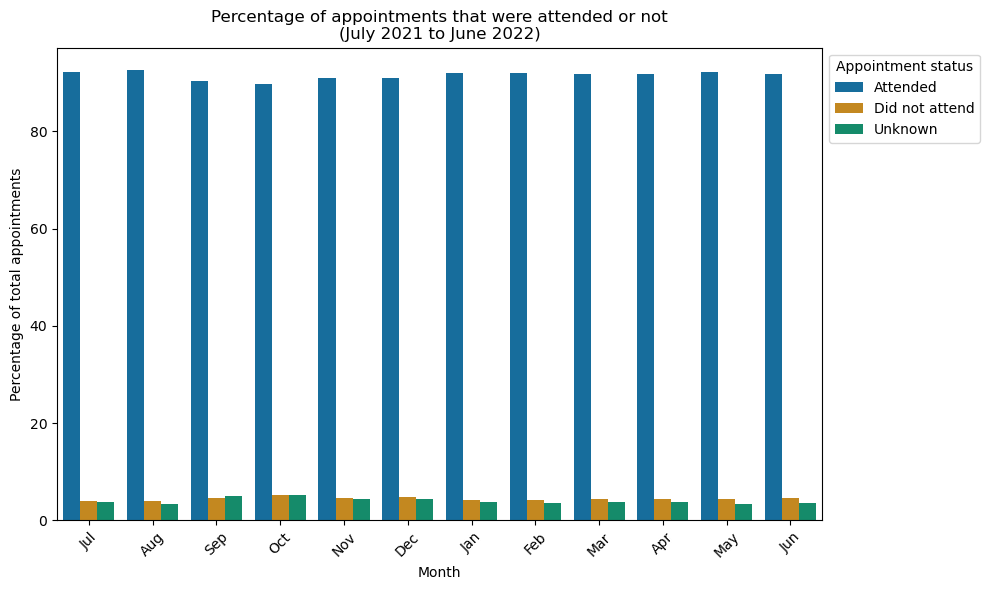

In [341]:
# Create bar chart.
standard_vertical_bar_chart(group_ar_filtered_202122_attended_merge, "month", "percentage",
                            title="Percentage of appointments that were attended or not\n(July 2021 to June 2022)",
                            x_label="Month", y_label="Percentage of total appointments", 
                            order=month_order_Jul_Jun, hue="appointment_status", legend_title="Appointment status", palette="colorblind")

The percentage of total appointments that are attended only has a slight difference between the months. Although even a 1% difference between months could still be a lot of appointments. For example, if there were 1 million appointments in a day, 1% of that would be 10,000 appointments.

31. Bar chart showing the percentage of appointments that weren't attended each month from July 2021 to June 2021.

In [344]:
# Only include "Did not attend" values.
group_ar_filtered_202122_attended_merge_DNA = \
group_ar_filtered_202122_attended_merge[group_ar_filtered_202122_attended_merge["appointment_status"].isin(["Did not attend"])]

group_ar_filtered_202122_attended_merge_DNA

appointment_status month  count_of_appointments  total_appointments  \
12     Did not attend   Apr                1045455            23913060   
13     Did not attend   Aug                 949137            23852171   
14     Did not attend   Dec                1198866            25140776   
15     Did not attend   Feb                1076658            25355260   
16     Did not attend   Jan                1076013            25635474   
17     Did not attend   Jul                1029665            25739219   
18     Did not attend   Jun                1167790            25828078   
19     Did not attend   Mar                1289888            29595038   
20     Did not attend   May                1199518            27495508   
21     Did not attend   Nov                1428087            30405070   
22     Did not attend   Oct                1565624            30303834   
23     Did not attend   Sep                1321348            28522501   

    percentage  
12    4.371900  
13    3.979248  
14    4.768612  
15    4.246291  
16    4.197359  
17    4.000374  
18    4.521397  
19    4.358460  
20    4.362596  
21    4.696871  
22    5.166422  
23    4.632651

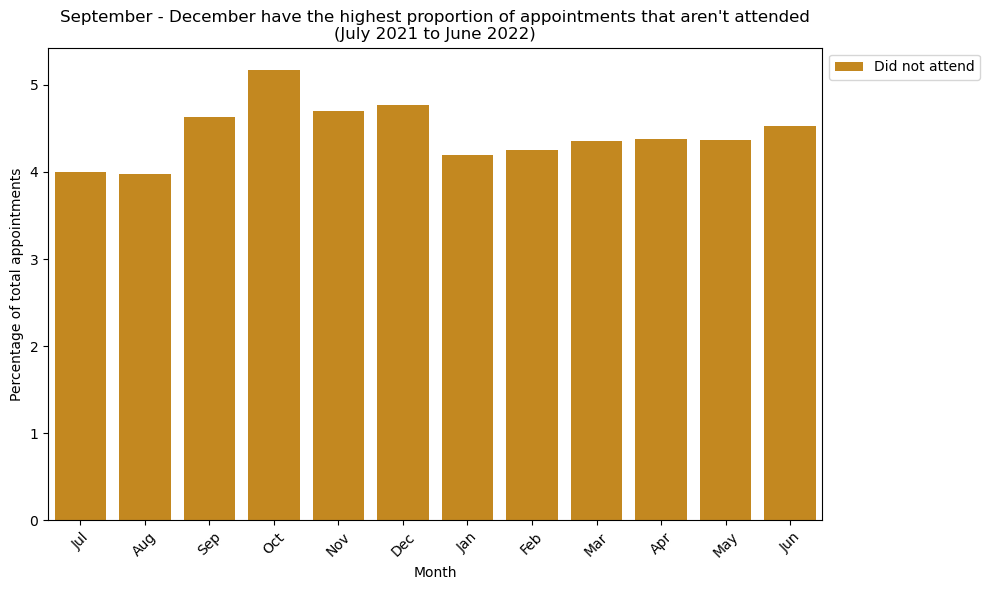

In [345]:
# Extract the second colour from the "colorblind" palette. This is so DNA is the same colour as the chart above.
second_colour = sns.color_palette("colorblind")[1]

# Create bar chart.
standard_vertical_bar_chart(group_ar_filtered_202122_attended_merge_DNA, "month", "percentage",
                            title="September - December have the highest proportion of appointments that aren't attended\n(July 2021 to June 2022)",
                            x_label="Month", y_label="Percentage of total appointments", 
                            order=month_order_Jul_Jun, hue="appointment_status", palette=[second_colour])

September to December had the highest proportion of appointments that aren't attended.

32. Bar chart showing the percentage of appointment that weren't attended per region from July 2021 to July 2022.

ar_filtered_202122 doesn't include "Region" so I will have to filter ar again.

In [349]:
ar_filtered_202122_re = ar[(ar['appointment_month']>= '2021-07') & (ar['appointment_month']<= '2022-06')]

In [350]:
# Group the filtered data frame by "region", "appointment_status", and "count_of_appointments".
group_ar_filtered_202122_attended_re = ar_filtered_202122_re.groupby(["appointment_status", "Region", "month", "appointment_mode"])\
                                ["count_of_appointments"].sum().reset_index()
group_ar_filtered_202122_attended_re

appointment_status           Region month appointment_mode  \
0              Attended  East of England   Apr     Face-to-Face   
1              Attended  East of England   Apr       Home Visit   
2              Attended  East of England   Apr        Telephone   
3              Attended  East of England   Apr          Unknown   
4              Attended  East of England   Apr     Video/Online   
...                 ...              ...   ...              ...   
1255            Unknown       South West   Sep     Face-to-Face   
1256            Unknown       South West   Sep       Home Visit   
1257            Unknown       South West   Sep        Telephone   
1258            Unknown       South West   Sep          Unknown   
1259            Unknown       South West   Sep     Video/Online   

      count_of_appointments  
0                   1680390  
1                     10335  
2                    722045  
3                    107652  
4                     19475  
...                     ...  
1255                 126182  
1256                   2902  
1257                  26693  
1258                   6469  
1259                    513  

[1260 rows x 5 columns]

In [351]:
# Add a total number of appointments per region column.
total_app_region = group_ar_filtered_202122_attended_re.groupby("Region")["count_of_appointments"].sum().reset_index()
total_app_region

Region  count_of_appointments
0         East of England               37004087
1                  London               47356274
2                Midlands               62315744
3  North East & Yorkshire               52068910
4              North West               38930587
5              South East               48931708
6              South West               35178679

In [352]:
# Rename "count_of appointments".
total_app_region.rename(columns={"count_of_appointments":"total_appointments"}, inplace=True)

In [353]:
# Merge total_app_region with group_ar_filtered_202122_attended_re.
group_ar_filtered_202122_attended_merge_re = group_ar_filtered_202122_attended_re.merge(total_app_region, how="left", on="Region")
group_ar_filtered_202122_attended_merge_re     

appointment_status           Region month appointment_mode  \
0              Attended  East of England   Apr     Face-to-Face   
1              Attended  East of England   Apr       Home Visit   
2              Attended  East of England   Apr        Telephone   
3              Attended  East of England   Apr          Unknown   
4              Attended  East of England   Apr     Video/Online   
...                 ...              ...   ...              ...   
1255            Unknown       South West   Sep     Face-to-Face   
1256            Unknown       South West   Sep       Home Visit   
1257            Unknown       South West   Sep        Telephone   
1258            Unknown       South West   Sep          Unknown   
1259            Unknown       South West   Sep     Video/Online   

      count_of_appointments  total_appointments  
0                   1680390            37004087  
1                     10335            37004087  
2                    722045            37004087  
3                    107652            37004087  
4                     19475            37004087  
...                     ...                 ...  
1255                 126182            35178679  
1256                   2902            35178679  
1257                  26693            35178679  
1258                   6469            35178679  
1259                    513            35178679  

[1260 rows x 6 columns]

In [354]:
# Create a percentage column.
group_ar_filtered_202122_attended_merge_re["percentage"] = \
(group_ar_filtered_202122_attended_merge_re["count_of_appointments"]/group_ar_filtered_202122_attended_merge_re["total_appointments"]) * 100

In [355]:
group_ar_filtered_202122_attended_merge_re

appointment_status           Region month appointment_mode  \
0              Attended  East of England   Apr     Face-to-Face   
1              Attended  East of England   Apr       Home Visit   
2              Attended  East of England   Apr        Telephone   
3              Attended  East of England   Apr          Unknown   
4              Attended  East of England   Apr     Video/Online   
...                 ...              ...   ...              ...   
1255            Unknown       South West   Sep     Face-to-Face   
1256            Unknown       South West   Sep       Home Visit   
1257            Unknown       South West   Sep        Telephone   
1258            Unknown       South West   Sep          Unknown   
1259            Unknown       South West   Sep     Video/Online   

      count_of_appointments  total_appointments  percentage  
0                   1680390            37004087    4.541093  
1                     10335            37004087    0.027929  
2                    722045            37004087    1.951257  
3                    107652            37004087    0.290919  
4                     19475            37004087    0.052629  
...                     ...                 ...         ...  
1255                 126182            35178679    0.358689  
1256                   2902            35178679    0.008249  
1257                  26693            35178679    0.075878  
1258                   6469            35178679    0.018389  
1259                    513            35178679    0.001458  

[1260 rows x 7 columns]

In [356]:
# Only include "Did not attend" values.
group_ar_filtered_202122_attended_merge_re_DNA = \
group_ar_filtered_202122_attended_merge_re[group_ar_filtered_202122_attended_merge_re["appointment_status"].isin(["Did not attend"])]

group_ar_filtered_202122_attended_merge_re_DNA

appointment_status           Region month appointment_mode  \
420     Did not attend  East of England   Apr     Face-to-Face   
421     Did not attend  East of England   Apr       Home Visit   
422     Did not attend  East of England   Apr        Telephone   
423     Did not attend  East of England   Apr          Unknown   
424     Did not attend  East of England   Apr     Video/Online   
..                 ...              ...   ...              ...   
835     Did not attend       South West   Sep     Face-to-Face   
836     Did not attend       South West   Sep       Home Visit   
837     Did not attend       South West   Sep        Telephone   
838     Did not attend       South West   Sep          Unknown   
839     Did not attend       South West   Sep     Video/Online   

     count_of_appointments  total_appointments  percentage  
420                  83743            37004087    0.226307  
421                    213            37004087    0.000576  
422                   7244            37004087    0.019576  
423                   2625            37004087    0.007094  
424                   1052            37004087    0.002843  
..                     ...                 ...         ...  
835                 108391            35178679    0.308116  
836                    427            35178679    0.001214  
837                  15901            35178679    0.045201  
838                   3513            35178679    0.009986  
839                    226            35178679    0.000642  

[420 rows x 7 columns]

In [357]:
# Group by region and sum the percentages.
group_region_DNA = group_ar_filtered_202122_attended_merge_re_DNA.groupby("Region")["percentage"].sum().reset_index()

# Sort values so that the bar chart is more readable.
group_region_DNA = group_region_DNA.sort_values(by="percentage", ascending=False)
group_region_DNA

Region  percentage
4              North West    5.559071
1                  London    5.498619
2                Midlands    4.433018
5              South East    4.335751
3  North East & Yorkshire    3.929642
6              South West    3.855975
0         East of England    3.495022

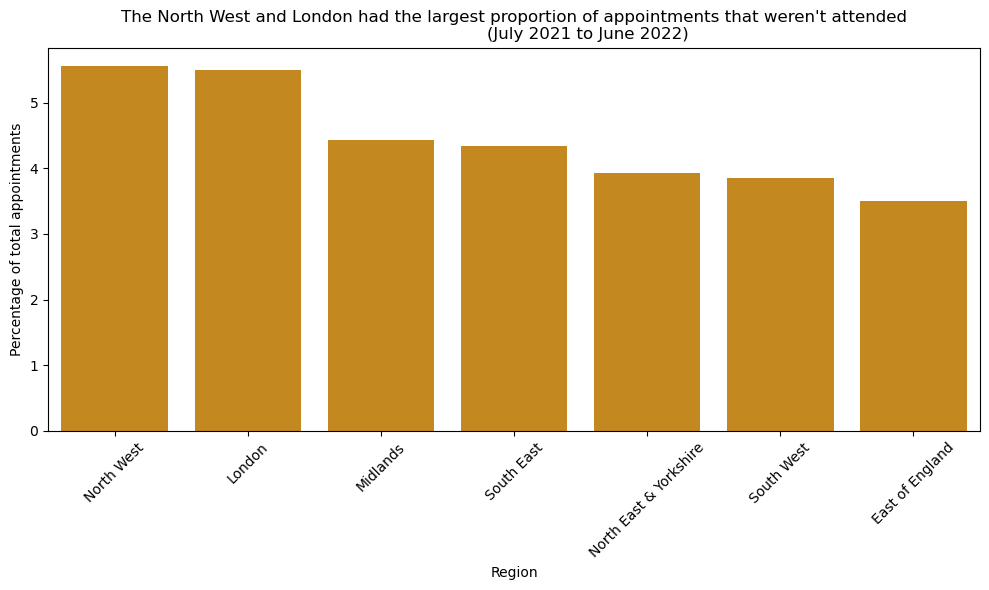

In [358]:
# Create bar chart.
standard_vertical_bar_chart(group_region_DNA, "Region", "percentage",
                            title="The North West and London had the largest proportion of appointments that weren't attended\n\
                            (July 2021 to June 2022)",
                            x_label="Region", y_label="Percentage of total appointments", palette=[second_colour], errorbar=None)

The North West and London had the largest percentage of appointments that weren't attended. East of England the least.

32. Bar chart showing the percentage of appointment that weren't attended per region from July 2021 to July 2022. Month grouped by region.

In [361]:
group_ar_filtered_202122_attended_merge_re_DNA

appointment_status           Region month appointment_mode  \
420     Did not attend  East of England   Apr     Face-to-Face   
421     Did not attend  East of England   Apr       Home Visit   
422     Did not attend  East of England   Apr        Telephone   
423     Did not attend  East of England   Apr          Unknown   
424     Did not attend  East of England   Apr     Video/Online   
..                 ...              ...   ...              ...   
835     Did not attend       South West   Sep     Face-to-Face   
836     Did not attend       South West   Sep       Home Visit   
837     Did not attend       South West   Sep        Telephone   
838     Did not attend       South West   Sep          Unknown   
839     Did not attend       South West   Sep     Video/Online   

     count_of_appointments  total_appointments  percentage  
420                  83743            37004087    0.226307  
421                    213            37004087    0.000576  
422                   7244            37004087    0.019576  
423                   2625            37004087    0.007094  
424                   1052            37004087    0.002843  
..                     ...                 ...         ...  
835                 108391            35178679    0.308116  
836                    427            35178679    0.001214  
837                  15901            35178679    0.045201  
838                   3513            35178679    0.009986  
839                    226            35178679    0.000642  

[420 rows x 7 columns]

In [362]:
# Copy the data frame so I can use it for the next bar chart.
group_ar_filtered_202122_attended_merge_re_DNA2 = group_ar_filtered_202122_attended_merge_re_DNA.copy()

In [363]:
# Group by region region, month, and percentage.
group_ar_re_mon_DNA = \
group_ar_filtered_202122_attended_merge_re_DNA.groupby(["Region", "month"])["percentage"].sum().reset_index()

group_ar_re_mon_DNA

Region month  percentage
0   East of England   Apr    0.256396
1   East of England   Aug    0.218646
2   East of England   Dec    0.299764
3   East of England   Feb    0.260647
4   East of England   Jan    0.264001
..              ...   ...         ...
79       South West   Mar    0.335689
80       South West   May    0.314071
81       South West   Nov    0.386842
82       South West   Oct    0.477369
83       South West   Sep    0.365159

[84 rows x 3 columns]

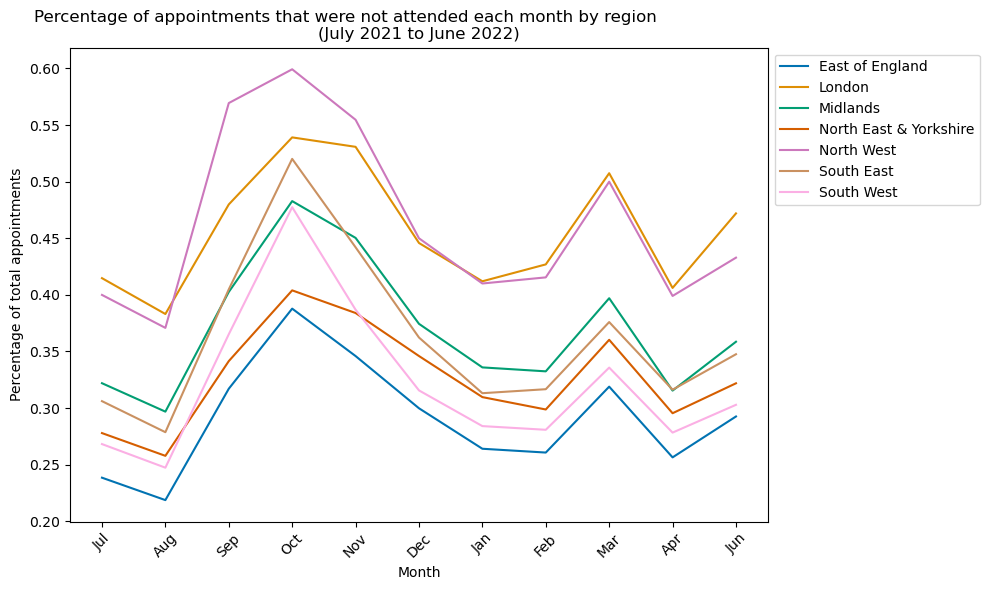

In [364]:
# Order month values.
month_order_Jul_Jun=["Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "Jun"]
group_ar_re_mon_DNA["month"] = pd.Categorical(group_ar_re_mon_DNA["month"], categories=month_order_Jul_Jun, ordered=True)

# Create line chart.
standard_line_plot(group_ar_re_mon_DNA, "month", "percentage",
                            title="Percentage of appointments that were not attended each month by region\
                            \n(July 2021 to June 2022)",
                            x_label="Percentage of total appointments", y_label="Month", hue="Region", 
                            palette="colorblind")

Line chart showing similar to the bar chart above but also showing how the percentage of appointments that aren't attended changed over time. The trend is similar across the regions, with the South West and South East having more of a spike in the Autumn.

30. Bar chart - Percentage of appointments that were not attended by appointment mode.
Create a total number of appointments and percentage column for percentage of each appointment mode that wasn't attended.

In [367]:
# Create a total number of appointments and percentage column for percentage of each appointment mode that wasn't attended.
ar_filtered_202122

icb_ons_code appointment_month appointment_status hcp_type  \
3462      E54000034           2021-07           Attended       GP   
3463      E54000034           2021-07           Attended       GP   
3464      E54000034           2021-07           Attended       GP   
3465      E54000034           2021-07           Attended       GP   
3466      E54000034           2021-07           Attended       GP   
...             ...               ...                ...      ...   
596816    E54000050           2022-06            Unknown  Unknown   
596817    E54000050           2022-06            Unknown  Unknown   
596818    E54000050           2022-06            Unknown  Unknown   
596819    E54000050           2022-06            Unknown  Unknown   
596820    E54000050           2022-06            Unknown  Unknown   

       appointment_mode time_between_book_and_appointment  \
3462       Face-to-Face                             1 Day   
3463       Face-to-Face                    15  to 21 Days   
3464       Face-to-Face                       2 to 7 Days   
3465       Face-to-Face                    22  to 28 Days   
3466       Face-to-Face                     8  to 14 Days   
...                 ...                               ...   
596816          Unknown                       2 to 7 Days   
596817          Unknown                    22  to 28 Days   
596818          Unknown                     8  to 14 Days   
596819          Unknown                 More than 28 Days   
596820          Unknown                          Same Day   

        count_of_appointments month  year  
3462                     7120   Jul  2021  
3463                     2460   Jul  2021  
3464                    11477   Jul  2021  
3465                     1134   Jul  2021  
3466                     5553   Jul  2021  
...                       ...   ...   ...  
596816                     21   Jun  2022  
596817                      8   Jun  2022  
596818                     28   Jun  2022  
596819                     17   Jun  2022  
596820                     10   Jun  2022  

[243317 rows x 9 columns]

In [368]:
# Group by appointment mode, appointment status, and month.
group_am_as_mon = ar_filtered_202122.groupby(["appointment_mode", "appointment_status", "month"])["count_of_appointments"].sum().reset_index()
group_am_as_mon

appointment_mode appointment_status month  count_of_appointments
0       Face-to-Face           Attended   Apr               13594930
1       Face-to-Face           Attended   Aug               12486211
2       Face-to-Face           Attended   Dec               13603930
3       Face-to-Face           Attended   Feb               14066370
4       Face-to-Face           Attended   Jan               13928856
..               ...                ...   ...                    ...
175     Video/Online            Unknown   Mar                   3855
176     Video/Online            Unknown   May                   3626
177     Video/Online            Unknown   Nov                   5175
178     Video/Online            Unknown   Oct                   8322
179     Video/Online            Unknown   Sep                   9336

[180 rows x 4 columns]

In [369]:
# Add a total number of appointments per appointment_mode column.
total_app_mode = group_am_as_mon.groupby("appointment_mode")["count_of_appointments"].sum().reset_index()
total_app_mode

appointment_mode  count_of_appointments
0     Face-to-Face              198111444
1       Home Visit                2149136
2        Telephone              110335304
3          Unknown                9525775
4     Video/Online                1664330

In [370]:
# Rename "count_of appointments".
total_app_mode.rename(columns={"count_of_appointments":"total_appointments"}, inplace=True)

# Merge total_app_mode with group_am_as_mon
group_am_as_mon_merge = group_am_as_mon.merge(total_app_mode, how="left", on="appointment_mode")
group_am_as_mon_merge   

appointment_mode appointment_status month  count_of_appointments  \
0       Face-to-Face           Attended   Apr               13594930   
1       Face-to-Face           Attended   Aug               12486211   
2       Face-to-Face           Attended   Dec               13603930   
3       Face-to-Face           Attended   Feb               14066370   
4       Face-to-Face           Attended   Jan               13928856   
..               ...                ...   ...                    ...   
175     Video/Online            Unknown   Mar                   3855   
176     Video/Online            Unknown   May                   3626   
177     Video/Online            Unknown   Nov                   5175   
178     Video/Online            Unknown   Oct                   8322   
179     Video/Online            Unknown   Sep                   9336   

     total_appointments  
0             198111444  
1             198111444  
2             198111444  
3             198111444  
4             198111444  
..                  ...  
175             1664330  
176             1664330  
177             1664330  
178             1664330  
179             1664330  

[180 rows x 5 columns]

In [371]:
# Create a percentage column.
group_am_as_mon_merge["percentage"] = \
(group_am_as_mon_merge["count_of_appointments"]/group_am_as_mon_merge["total_appointments"]) * 100

group_am_as_mon_merge 

appointment_mode appointment_status month  count_of_appointments  \
0       Face-to-Face           Attended   Apr               13594930   
1       Face-to-Face           Attended   Aug               12486211   
2       Face-to-Face           Attended   Dec               13603930   
3       Face-to-Face           Attended   Feb               14066370   
4       Face-to-Face           Attended   Jan               13928856   
..               ...                ...   ...                    ...   
175     Video/Online            Unknown   Mar                   3855   
176     Video/Online            Unknown   May                   3626   
177     Video/Online            Unknown   Nov                   5175   
178     Video/Online            Unknown   Oct                   8322   
179     Video/Online            Unknown   Sep                   9336   

     total_appointments  percentage  
0             198111444    6.862264  
1             198111444    6.302620  
2             198111444    6.866807  
3             198111444    7.100231  
4             198111444    7.030818  
..                  ...         ...  
175             1664330    0.231625  
176             1664330    0.217865  
177             1664330    0.310936  
178             1664330    0.500021  
179             1664330    0.560946  

[180 rows x 6 columns]

In [372]:
# Only include "Did not attend" values.
group_am_as_mon_merge_DNA = \
group_am_as_mon_merge[group_am_as_mon_merge["appointment_status"].isin(["Did not attend"])]

group_am_as_mon_merge_DNA

appointment_mode appointment_status month  count_of_appointments  \
12      Face-to-Face     Did not attend   Apr                 843333   
13      Face-to-Face     Did not attend   Aug                 726087   
14      Face-to-Face     Did not attend   Dec                 973934   
15      Face-to-Face     Did not attend   Feb                 859758   
16      Face-to-Face     Did not attend   Jan                 853515   
17      Face-to-Face     Did not attend   Jul                 782278   
18      Face-to-Face     Did not attend   Jun                 949083   
19      Face-to-Face     Did not attend   Mar                1035975   
20      Face-to-Face     Did not attend   May                 970268   
21      Face-to-Face     Did not attend   Nov                1168648   
22      Face-to-Face     Did not attend   Oct                1314476   
23      Face-to-Face     Did not attend   Sep                1066945   
48        Home Visit     Did not attend   Apr                   5418   
49        Home Visit     Did not attend   Aug                   6741   
50        Home Visit     Did not attend   Dec                   8518   
51        Home Visit     Did not attend   Feb                   6261   
52        Home Visit     Did not attend   Jan                   7597   
53        Home Visit     Did not attend   Jul                   6454   
54        Home Visit     Did not attend   Jun                   6018   
55        Home Visit     Did not attend   Mar                   6598   
56        Home Visit     Did not attend   May                   6806   
57        Home Visit     Did not attend   Nov                   8965   
58        Home Visit     Did not attend   Oct                   7796   
59        Home Visit     Did not attend   Sep                   7758   
84         Telephone     Did not attend   Apr                 170654   
85         Telephone     Did not attend   Aug                 185902   
86         Telephone     Did not attend   Dec                 176733   
87         Telephone     Did not attend   Feb                 181415   
88         Telephone     Did not attend   Jan                 183167   
89         Telephone     Did not attend   Jul                 205610   
90         Telephone     Did not attend   Jun                 187053   
91         Telephone     Did not attend   Mar                 213908   
92         Telephone     Did not attend   May                 195201   
93         Telephone     Did not attend   Nov                 202403   
94         Telephone     Did not attend   Oct                 191559   
95         Telephone     Did not attend   Sep                 206589   
120          Unknown     Did not attend   Apr                  20010   
121          Unknown     Did not attend   Aug                  25188   
122          Unknown     Did not attend   Dec                  32463   
123          Unknown     Did not attend   Feb                  23030   
124          Unknown     Did not attend   Jan                  25188   
125          Unknown     Did not attend   Jul                  29672   
126          Unknown     Did not attend   Jun                  19028   
127          Unknown     Did not attend   Mar                  26156   
128          Unknown     Did not attend   May                  20374   
129          Unknown     Did not attend   Nov                  39417   
130          Unknown     Did not attend   Oct                  42796   
131          Unknown     Did not attend   Sep                  32124   
156     Video/Online     Did not attend   Apr                   6040   
157     Video/Online     Did not attend   Aug                   5219   
158     Video/Online     Did not attend   Dec                   7218   
159     Video/Online     Did not attend   Feb                   6194   
160     Video/Online     Did not attend   Jan                   6546   
161     Video/Online     Did not attend   Jul                   5651   
162     Video/Online     Did not attend   Ju

In [373]:
# Group by appointment_mode.
group_am_as_mon_merge_DNA_am = group_am_as_mon_merge_DNA.groupby(["appointment_mode", "month"])["percentage"].sum().reset_index()
group_am_as_mon_merge_DNA_am

appointment_mode month  percentage
0      Face-to-Face   Apr    0.425686
1      Face-to-Face   Aug    0.366504
2      Face-to-Face   Dec    0.491609
3      Face-to-Face   Feb    0.433977
4      Face-to-Face   Jan    0.430826
5      Face-to-Face   Jul    0.394868
6      Face-to-Face   Jun    0.479065
7      Face-to-Face   Mar    0.522925
8      Face-to-Face   May    0.489759
9      Face-to-Face   Nov    0.589894
10     Face-to-Face   Oct    0.663503
11     Face-to-Face   Sep    0.538558
12       Home Visit   Apr    0.252101
13       Home Visit   Aug    0.313661
14       Home Visit   Dec    0.396345
15       Home Visit   Feb    0.291326
16       Home Visit   Jan    0.353491
17       Home Visit   Jul    0.300307
18       Home Visit   Jun    0.280020
19       Home Visit   Mar    0.307007
20       Home Visit   May    0.316685
21       Home Visit   Nov    0.417144
22       Home Visit   Oct    0.362750
23       Home Visit   Sep    0.360982
24        Telephone   Apr    0.154669
25        Telephone   Aug    0.168488
26        Telephone   Dec    0.160178
27        Telephone   Feb    0.164422
28        Telephone   Jan    0.166009
29        Telephone   Jul    0.186350
30        Telephone   Jun    0.169531
31        Telephone   Mar    0.193871
32        Telephone   May    0.176916
33        Telephone   Nov    0.183444
34        Telephone   Oct    0.173615
35        Telephone   Sep    0.187237
36          Unknown   Apr    0.210062
37          Unknown   Aug    0.264419
38          Unknown   Dec    0.340791
39          Unknown   Feb    0.241765
40          Unknown   Jan    0.264419
41          Unknown   Jul    0.311492
42          Unknown   Jun    0.199753
43          Unknown   Mar    0.274581
44          Unknown   May    0.213883
45          Unknown   Nov    0.413793
46          Unknown   Oct    0.449265
47          Unknown   Sep    0.337232
48     Video/Online   Apr    0.362909
49     Video/Online   Aug    0.313580
50     Video/Online   Dec    0.433688
51     Video/Online   Feb    0.372162
52     Video/Online   Jan    0.393311
53     Video/Online   Jul    0.339536
54     Video/Online   Jun    0.397037
55     Video/Online   Mar    0.435671
56     Video/Online   May    0.412719
57     Video/Online   Nov    0.519969
58     Video/Online   Oct    0.540578
59     Video/Online   Sep    0.476588

In [374]:
# Sort the values into descending order.
group_am_as_mon_merge_DNA_am2 = group_am_as_mon_merge_DNA_am.groupby("appointment_mode")["percentage"].sum().reset_index()
group_am_as_mon_merge_DNA_am2 = group_am_as_mon_merge_DNA_am2.sort_values(by="percentage", ascending=False)

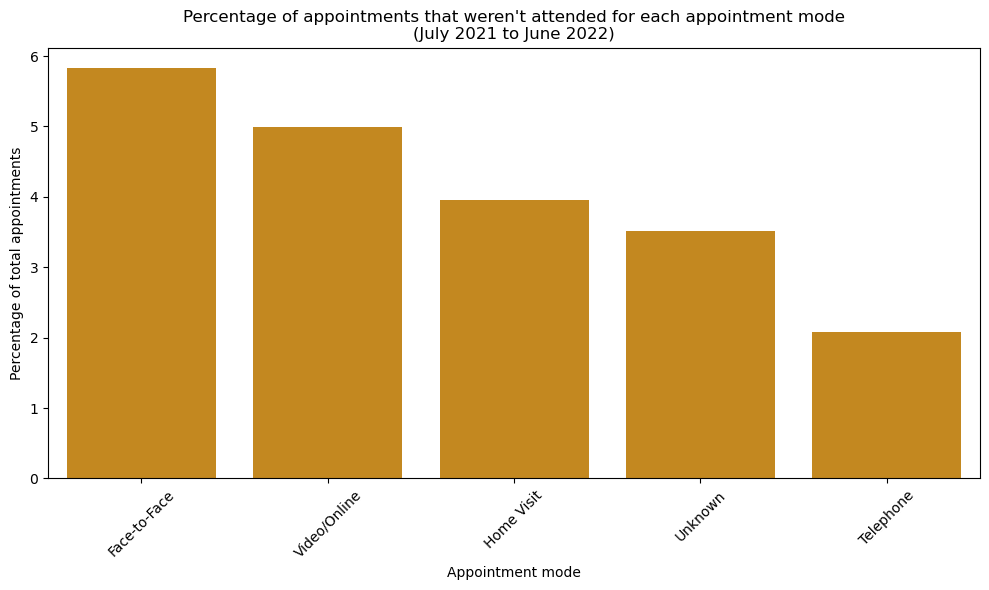

In [375]:
# Create bar chart.
standard_vertical_bar_chart(group_am_as_mon_merge_DNA_am2, "appointment_mode", "percentage",
                            title="Percentage of appointments that weren't attended for each appointment mode\n(July 2021 to June 2022)",
                            x_label="Appointment mode", y_label="Percentage of total appointments", palette=[second_colour], errorbar=None)

Face-to-face appointments were the least well attended and telephone appointments the best.

31. Bar chart - Percentage of appointments that were not attended by appointment mode for each month.

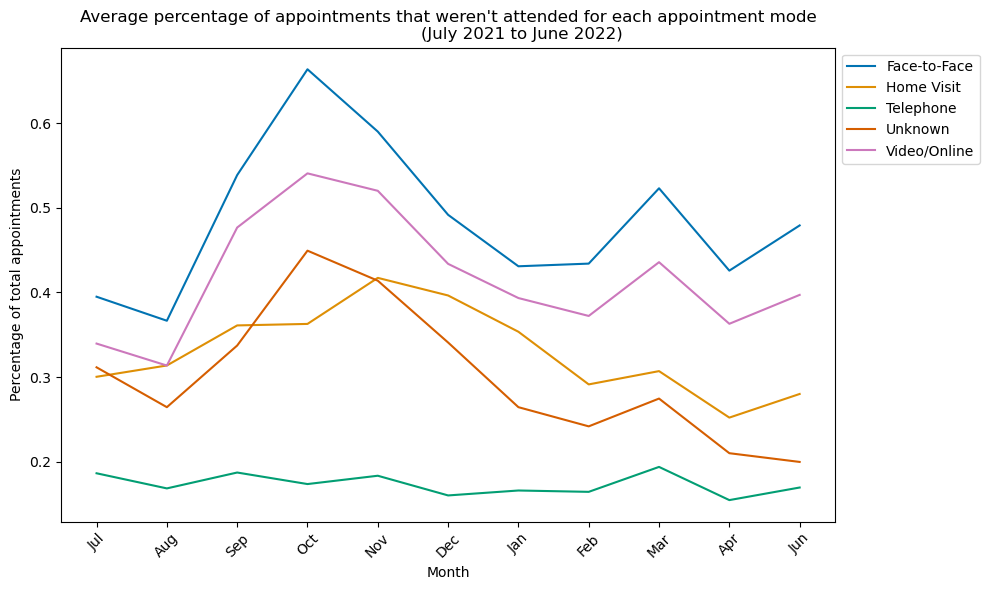

In [378]:
# Order month values.
month_order_Jul_Jun=["Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "Jun"]
group_am_as_mon_merge_DNA_am["month"] = pd.Categorical(group_am_as_mon_merge_DNA_am["month"], categories=month_order_Jul_Jun, ordered=True)


# Create line chart.
standard_line_plot(group_am_as_mon_merge_DNA_am, "month", "percentage",
                            title="Average percentage of appointments that weren't attended for each appointment mode\n\
                            (July 2021 to June 2022)",
                            x_label="Percentage of total appointments", y_label="Month", hue="appointment_mode", 
                            palette="colorblind")

This shows the same as the bar chart above, but adds that all appointment modes other than telephone appointments have more appointments that aren't attended in the autumn. Telephone appointments remain stable. 

32. Bar chart - Percentage of appointments that were not attended by time between booking and appointment.
Create a total number of appointments and percentage column for percentage of each "time_between_book_and_appointment" that wasn't attended.

In [381]:
ar_filtered_202122

icb_ons_code appointment_month appointment_status hcp_type  \
3462      E54000034           2021-07           Attended       GP   
3463      E54000034           2021-07           Attended       GP   
3464      E54000034           2021-07           Attended       GP   
3465      E54000034           2021-07           Attended       GP   
3466      E54000034           2021-07           Attended       GP   
...             ...               ...                ...      ...   
596816    E54000050           2022-06            Unknown  Unknown   
596817    E54000050           2022-06            Unknown  Unknown   
596818    E54000050           2022-06            Unknown  Unknown   
596819    E54000050           2022-06            Unknown  Unknown   
596820    E54000050           2022-06            Unknown  Unknown   

       appointment_mode time_between_book_and_appointment  \
3462       Face-to-Face                             1 Day   
3463       Face-to-Face                    15  to 21 Days   
3464       Face-to-Face                       2 to 7 Days   
3465       Face-to-Face                    22  to 28 Days   
3466       Face-to-Face                     8  to 14 Days   
...                 ...                               ...   
596816          Unknown                       2 to 7 Days   
596817          Unknown                    22  to 28 Days   
596818          Unknown                     8  to 14 Days   
596819          Unknown                 More than 28 Days   
596820          Unknown                          Same Day   

        count_of_appointments month  year  
3462                     7120   Jul  2021  
3463                     2460   Jul  2021  
3464                    11477   Jul  2021  
3465                     1134   Jul  2021  
3466                     5553   Jul  2021  
...                       ...   ...   ...  
596816                     21   Jun  2022  
596817                      8   Jun  2022  
596818                     28   Jun  2022  
596819                     17   Jun  2022  
596820                     10   Jun  2022  

[243317 rows x 9 columns]

In [382]:
# Group the filtered data frame by "time_between_book_and_appointment", "month", "appointment_status", and "count_of_appointments".
group_ar_filtered_202122_tbbaa = ar_filtered_202122.groupby(["time_between_book_and_appointment","appointment_status", "month"])\
                                ["count_of_appointments"].sum().reset_index()
group_ar_filtered_202122_tbbaa

time_between_book_and_appointment appointment_status month  \
0                               1 Day           Attended   Apr   
1                               1 Day           Attended   Aug   
2                               1 Day           Attended   Dec   
3                               1 Day           Attended   Feb   
4                               1 Day           Attended   Jan   
..                                ...                ...   ...   
283                           Unknown            Unknown   Mar   
284                           Unknown            Unknown   May   
285                           Unknown            Unknown   Nov   
286                           Unknown            Unknown   Oct   
287                           Unknown            Unknown   Sep   

     count_of_appointments  
0                  1943829  
1                  1884017  
2                  2049362  
3                  2116014  
4                  2176212  
..                     ...  
283                   4137  
284                   3880  
285                   4381  
286                   5296  
287                   6201  

[288 rows x 4 columns]

In [383]:
# Add a total number of appointments per time_between_book_and_appointment category column.
total_app_tbbaa = group_ar_filtered_202122_tbbaa.groupby("time_between_book_and_appointment")["count_of_appointments"].sum().reset_index()
total_app_tbbaa

time_between_book_and_appointment  count_of_appointments
0                             1 Day               28217526
1                    15  to 21 Days               21003159
2                       2 to 7 Days               66179202
3                    22  to 28 Days               12288428
4                     8  to 14 Days               40711118
5                 More than 28 Days               10524835
6                          Same Day              142652547
7                           Unknown                 209174

In [384]:
# Rename "count_of appointments".
total_app_tbbaa.rename(columns={"count_of_appointments":"total_appointments"}, inplace=True)

In [385]:
# Merge total_app_month with group_ar_filtered_202122_attended.
group_ar_filtered_202122_tbbaa = group_ar_filtered_202122_tbbaa.merge(total_app_tbbaa, how="left", on="time_between_book_and_appointment")
group_ar_filtered_202122_tbbaa     

time_between_book_and_appointment appointment_status month  \
0                               1 Day           Attended   Apr   
1                               1 Day           Attended   Aug   
2                               1 Day           Attended   Dec   
3                               1 Day           Attended   Feb   
4                               1 Day           Attended   Jan   
..                                ...                ...   ...   
283                           Unknown            Unknown   Mar   
284                           Unknown            Unknown   May   
285                           Unknown            Unknown   Nov   
286                           Unknown            Unknown   Oct   
287                           Unknown            Unknown   Sep   

     count_of_appointments  total_appointments  
0                  1943829            28217526  
1                  1884017            28217526  
2                  2049362            28217526  
3                  2116014            28217526  
4                  2176212            28217526  
..                     ...                 ...  
283                   4137              209174  
284                   3880              209174  
285                   4381              209174  
286                   5296              209174  
287                   6201              209174  

[288 rows x 5 columns]

In [386]:
# Create a percentage column.
group_ar_filtered_202122_tbbaa["percentage"] = \
(group_ar_filtered_202122_tbbaa["count_of_appointments"]/group_ar_filtered_202122_tbbaa["total_appointments"]) * 100

In [387]:
group_ar_filtered_202122_tbbaa

time_between_book_and_appointment appointment_status month  \
0                               1 Day           Attended   Apr   
1                               1 Day           Attended   Aug   
2                               1 Day           Attended   Dec   
3                               1 Day           Attended   Feb   
4                               1 Day           Attended   Jan   
..                                ...                ...   ...   
283                           Unknown            Unknown   Mar   
284                           Unknown            Unknown   May   
285                           Unknown            Unknown   Nov   
286                           Unknown            Unknown   Oct   
287                           Unknown            Unknown   Sep   

     count_of_appointments  total_appointments  percentage  
0                  1943829            28217526    6.888729  
1                  1884017            28217526    6.676762  
2                  2049362            28217526    7.262727  
3                  2116014            28217526    7.498935  
4                  2176212            28217526    7.712271  
..                     ...                 ...         ...  
283                   4137              209174    1.977779  
284                   3880              209174    1.854915  
285                   4381              209174    2.094429  
286                   5296              209174    2.531863  
287                   6201              209174    2.964518  

[288 rows x 6 columns]

In [388]:
# Only include "Did not attend" values.
group_ar_filtered_202122_tbbaa_DNA = \
group_ar_filtered_202122_tbbaa[group_ar_filtered_202122_tbbaa["appointment_status"].isin(["Did not attend"])]

group_ar_filtered_202122_tbbaa_DNA

time_between_book_and_appointment appointment_status month  \
12                              1 Day     Did not attend   Apr   
13                              1 Day     Did not attend   Aug   
14                              1 Day     Did not attend   Dec   
15                              1 Day     Did not attend   Feb   
16                              1 Day     Did not attend   Jan   
..                                ...                ...   ...   
271                           Unknown     Did not attend   Mar   
272                           Unknown     Did not attend   May   
273                           Unknown     Did not attend   Nov   
274                           Unknown     Did not attend   Oct   
275                           Unknown     Did not attend   Sep   

     count_of_appointments  total_appointments  percentage  
12                   80804            28217526    0.286361  
13                   73344            28217526    0.259924  
14                   98168            28217526    0.347897  
15                   87637            28217526    0.310576  
16                   91828            28217526    0.325429  
..                     ...                 ...         ...  
271                    605              209174    0.289233  
272                    431              209174    0.206049  
273                    459              209174    0.219435  
274                    540              209174    0.258158  
275                    502              209174    0.239992  

[96 rows x 6 columns]

In [389]:
# Group by time_between_book_and_appointment.
group_ar_filtered_202122_tbbaa_DNA2 = \
group_ar_filtered_202122_tbbaa_DNA.groupby("time_between_book_and_appointment")["percentage"].sum().reset_index()

group_ar_filtered_202122_tbbaa_DNA2 = group_ar_filtered_202122_tbbaa_DNA2.sort_values(by="percentage", ascending=False)
group_ar_filtered_202122_tbbaa_DNA2

time_between_book_and_appointment  percentage
5                 More than 28 Days    9.205455
3                    22  to 28 Days    8.128420
1                    15  to 21 Days    7.998897
4                     8  to 14 Days    7.590931
2                       2 to 7 Days    6.024086
0                             1 Day    4.007648
7                           Unknown    2.647079
6                          Same Day    1.743308

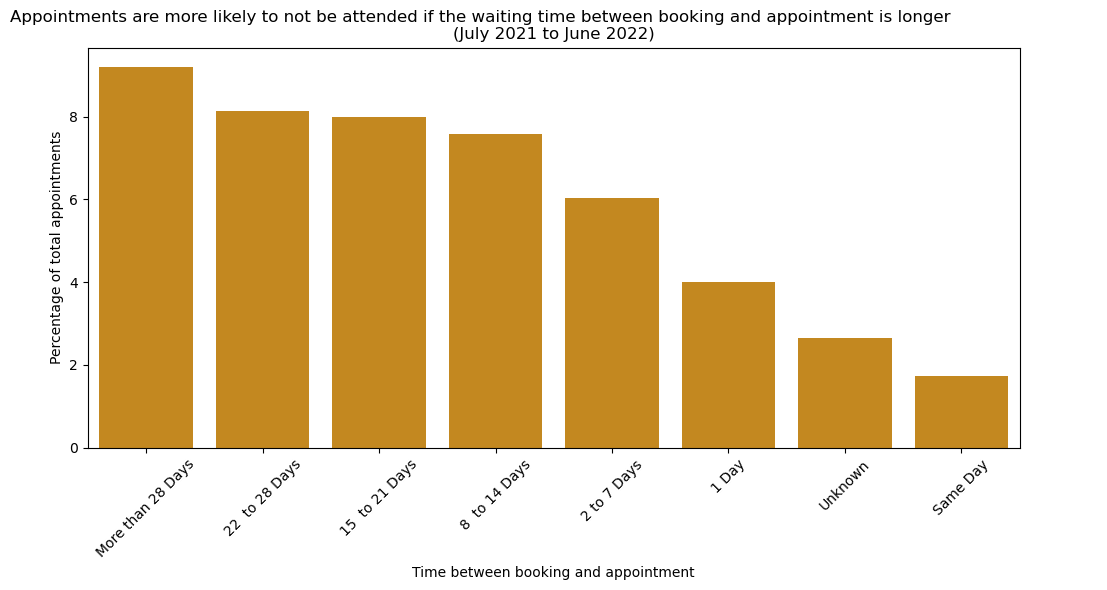

In [390]:
# Create bar chart.
standard_vertical_bar_chart(group_ar_filtered_202122_tbbaa_DNA2, "time_between_book_and_appointment", "percentage",
                            title="Appointments are more likely to not be attended if the waiting time between booking and appointment is longer\
                            \n(July 2021 to June 2022)",
                            x_label="Time between booking and appointment", 
                            y_label="Percentage of total appointments", palette=[second_colour], errorbar=None)

Appointments are more likely to not be attended if the waiting time between booking and appointment is longer.

33. Bar chart - Percentage of appointments that were not attended by time between booking and appointment by month.

In [393]:
group_ar_filtered_202122_tbbaa_DNA

time_between_book_and_appointment appointment_status month  \
12                              1 Day     Did not attend   Apr   
13                              1 Day     Did not attend   Aug   
14                              1 Day     Did not attend   Dec   
15                              1 Day     Did not attend   Feb   
16                              1 Day     Did not attend   Jan   
..                                ...                ...   ...   
271                           Unknown     Did not attend   Mar   
272                           Unknown     Did not attend   May   
273                           Unknown     Did not attend   Nov   
274                           Unknown     Did not attend   Oct   
275                           Unknown     Did not attend   Sep   

     count_of_appointments  total_appointments  percentage  
12                   80804            28217526    0.286361  
13                   73344            28217526    0.259924  
14                   98168            28217526    0.347897  
15                   87637            28217526    0.310576  
16                   91828            28217526    0.325429  
..                     ...                 ...         ...  
271                    605              209174    0.289233  
272                    431              209174    0.206049  
273                    459              209174    0.219435  
274                    540              209174    0.258158  
275                    502              209174    0.239992  

[96 rows x 6 columns]

In [394]:
# Group by time_between_book_and_appointment.
group_ar_filtered_202122_tbbaa_DNA3 = \
group_ar_filtered_202122_tbbaa_DNA.groupby(["time_between_book_and_appointment", "month"])["percentage"].sum().reset_index()

group_ar_filtered_202122_tbbaa_DNA3 = group_ar_filtered_202122_tbbaa_DNA3.sort_values(by="percentage", ascending=False)
group_ar_filtered_202122_tbbaa_DNA3

time_between_book_and_appointment month  percentage
70                 More than 28 Days   Oct    1.094003
71                 More than 28 Days   Sep    0.981678
66                 More than 28 Days   Jun    0.900309
58                     8  to 14 Days   Oct    0.899160
21                    15  to 21 Days   Nov    0.880263
..                               ...   ...         ...
75                          Same Day   Feb    0.139641
74                          Same Day   Dec    0.139538
77                          Same Day   Jul    0.138603
72                          Same Day   Apr    0.130752
73                          Same Day   Aug    0.129281

[96 rows x 3 columns]

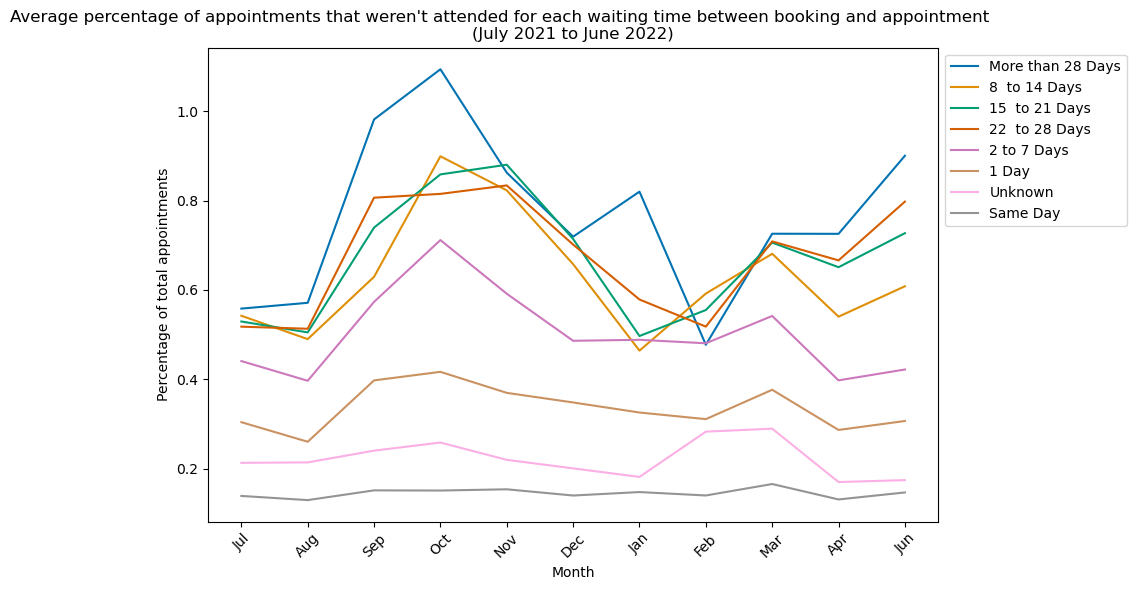

In [395]:
# Order month values.
month_order_Jul_Jun=["Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "Jun"]
group_ar_filtered_202122_tbbaa_DNA3["month"] = pd.Categorical(group_ar_filtered_202122_tbbaa_DNA3["month"], categories=month_order_Jul_Jun, ordered=True)


# Create line chart.
standard_line_plot(group_ar_filtered_202122_tbbaa_DNA3, "month", "percentage",
                            title="Average percentage of appointments that weren't attended for each waiting time between booking and appointment\
                            \n(July 2021 to June 2022)",
                            x_label="Percentage of total appointments", y_label="Month", hue="time_between_book_and_appointment", 
                            palette="colorblind")

This shows similar to the bar chart above, but shows that a lot of appointments that are more than 28 days aren't attended in the autumn and there is another spike in January and June. Same day and 1 day appointments are fairly stable throughout the year.

34. Line plot - How many 111 calls were made each month between July 2021 and June 2022.

In [398]:
one11.head(5)

month_year month  year  count_111_triages  Season
0    2020-07   Jul  2020            1248152  Summer
1    2020-08   Aug  2020            1404175  Summer
2    2020-09   Sep  2020            1402720  Autumn
3    2020-10   Oct  2020            1339519  Autumn
4    2020-11   Nov  2020            1279294  Autumn

In [399]:
# Filter one11 for July 2021 to June 2022.
one11_202122 = one11[(one11['month_year']>= '2021-07') & (one11['month_year']<= '2022-06')]
one11_202122

month_year month  year  count_111_triages  Season
12    2021-07   Jul  2021            1334046  Summer
13    2021-08   Aug  2021            1296163  Summer
14    2021-09   Sep  2021            1216971  Autumn
15    2021-10   Oct  2021            1315164  Autumn
16    2021-11   Nov  2021            1267048  Autumn
17    2021-12   Dec  2021            1369860  Winter
18    2022-01   Jan  2022            1301133  Winter
19    2022-02   Feb  2022            1159507  Winter
20    2022-03   Mar  2022            1364499  Spring
21    2022-04   Apr  2022            1476155  Spring
22    2022-05   May  2022            1454204  Spring
23    2022-06   Jun  2022            1505813  Summer

In [400]:
# Divide count_111_triages by a million.
one11_202122["count_111_triages"] /= 1000000
one11_202122

month_year month  year  count_111_triages  Season
12    2021-07   Jul  2021           1.334046  Summer
13    2021-08   Aug  2021           1.296163  Summer
14    2021-09   Sep  2021           1.216971  Autumn
15    2021-10   Oct  2021           1.315164  Autumn
16    2021-11   Nov  2021           1.267048  Autumn
17    2021-12   Dec  2021           1.369860  Winter
18    2022-01   Jan  2022           1.301133  Winter
19    2022-02   Feb  2022           1.159507  Winter
20    2022-03   Mar  2022           1.364499  Spring
21    2022-04   Apr  2022           1.476155  Spring
22    2022-05   May  2022           1.454204  Spring
23    2022-06   Jun  2022           1.505813  Summer

In [401]:
# Convert "month_year" to a string.
one11_202122["month_year"] = one11_202122["month_year"].astype(str)
one11_202122.dtypes

month_year            object
month                 object
year                  object
count_111_triages    float64
Season                object
dtype: object

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


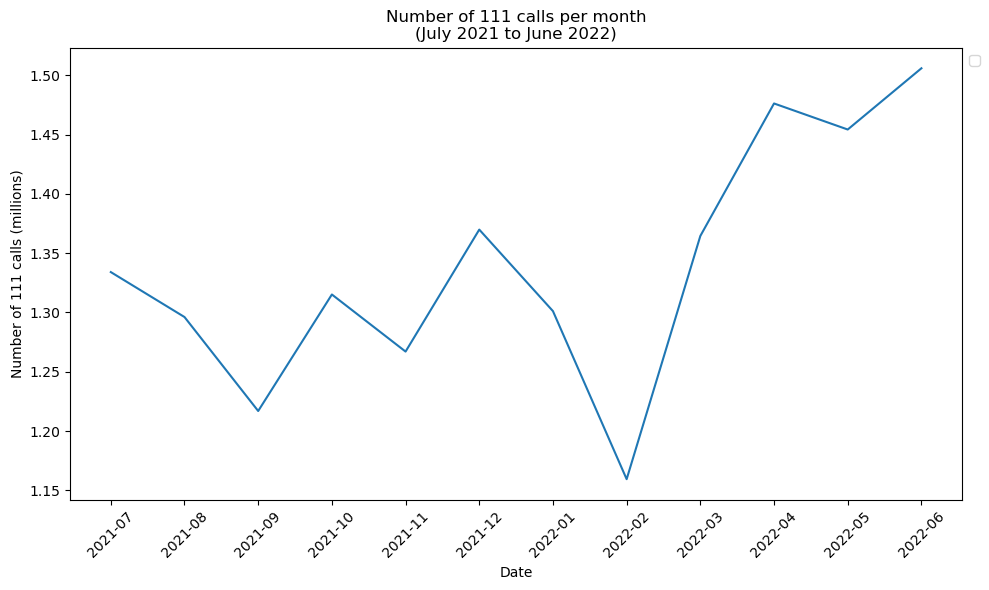

In [402]:
# Create a line plot.
standard_line_plot(one11_202122, "month_year", "count_111_triages", 
                   title="Number of 111 calls per month\n(July 2021 to June 2022)", 
                   x_label="Number of 111 calls (millions)", y_label="Date")

There are fewer 111 calls in September and February and the most in June.

35. Line plot - Approximately how many people were employed by the NHS between July 2021 and June 2022?

In [405]:
wf

month_year month  year  staff_total
0     2020-01   Jan  2020      1178573
1     2020-02   Feb  2020      1182326
2     2020-03   Mar  2020      1189414
3     2020-04   Apr  2020      1202179
4     2020-05   May  2020      1211884
5     2020-06   Jun  2020      1220324
6     2020-07   Jul  2020      1219984
7     2020-08   Aug  2020      1211416
8     2020-09   Sep  2020      1212944
9     2020-10   Oct  2020      1216156
10    2020-11   Nov  2020      1223247
11    2020-12   Dec  2020      1221764
12    2021-01   Jan  2021      1229444
13    2021-02   Feb  2021      1239214
14    2021-03   Mar  2021      1247002
15    2021-04   Apr  2021      1244453
16    2021-05   May  2021      1241983
17    2021-06   Jun  2021      1242456
18    2021-07   Jul  2021      1242747
19    2021-08   Aug  2021      1246842
20    2021-09   Sep  2021      1253859
21    2021-10   Oct  2021      1257496
22    2021-11   Nov  2021      1263412
23    2021-12   Dec  2021      1259515
24    2022-01   Jan  2022      1266716
25    2022-02   Feb  2022      1269954
26    2022-03   Mar  2022      1272425
27    2022-04   Apr  2022      1267514
28    2022-05   May  2022      1269724
29    2022-06   Jun  2022      1269267

In [406]:
# Filter wf for July 2021 to June 2022.
wf_202122 = wf[(wf['month_year']>= '2021-07') & (wf['month_year']<= '2022-06')]
wf_202122

month_year month  year  staff_total
18    2021-07   Jul  2021      1242747
19    2021-08   Aug  2021      1246842
20    2021-09   Sep  2021      1253859
21    2021-10   Oct  2021      1257496
22    2021-11   Nov  2021      1263412
23    2021-12   Dec  2021      1259515
24    2022-01   Jan  2022      1266716
25    2022-02   Feb  2022      1269954
26    2022-03   Mar  2022      1272425
27    2022-04   Apr  2022      1267514
28    2022-05   May  2022      1269724
29    2022-06   Jun  2022      1269267

In [407]:
# Divide wf_202122 by a million.
wf_202122["staff_total"] /= 1000000
wf_202122

month_year month  year  staff_total
18    2021-07   Jul  2021     1.242747
19    2021-08   Aug  2021     1.246842
20    2021-09   Sep  2021     1.253859
21    2021-10   Oct  2021     1.257496
22    2021-11   Nov  2021     1.263412
23    2021-12   Dec  2021     1.259515
24    2022-01   Jan  2022     1.266716
25    2022-02   Feb  2022     1.269954
26    2022-03   Mar  2022     1.272425
27    2022-04   Apr  2022     1.267514
28    2022-05   May  2022     1.269724
29    2022-06   Jun  2022     1.269267

In [408]:
# Convert "month_year" to a string.
wf_202122["month_year"] = wf_202122["month_year"].astype(str)
wf_202122.dtypes

month_year      object
month           object
year            object
staff_total    float64
dtype: object

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


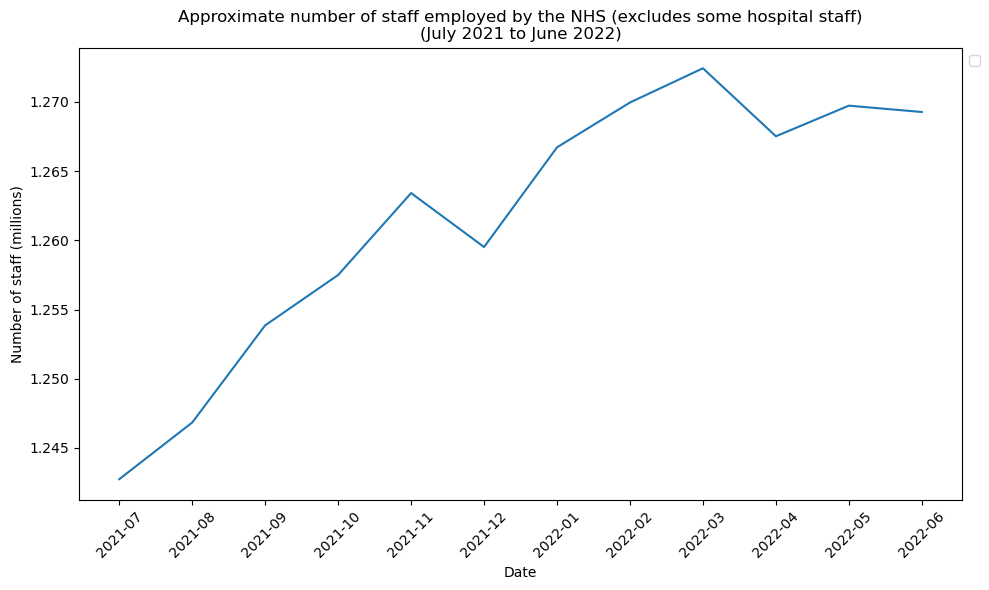

In [409]:
# Create a line plot.
standard_line_plot(wf_202122, "month_year", "staff_total", 
                   title="Approximate number of staff employed by the NHS (excludes some hospital staff)\n(July 2021 to June 2022)", 
                   x_label="Number of staff (millions)", y_label="Date")

Overall, the number of staff increased from July 2021 to June 2022.

36. Create a grouped bar chart per day of the week (excluding weekends) of the percentage of appointments from August 2021 to June 2022 that were over or under capacity.

In [412]:
nc.head(2)

appointment_date icb_ons_code                       sub_icb_location_name  \
0       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
1       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   

        service_setting            context_type  \
0  Primary Care Network  Care Related Encounter   
1                 Other  Care Related Encounter   

                        national_category  count_of_appointments month  year  \
0  Patient contact during care home round                      3   Aug  2021   
1                         Planned clinics                      7   Aug  2021   

                   Region  Season appointment_month  
0  North East & Yorkshire  Summer           2021-08  
1  North East & Yorkshire  Summer           2021-08

In [413]:
# Create a day of the week column.
nc["day_of_week"] = nc["appointment_date"].dt.day_name()
nc["day_of_week"].unique()

array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday'], dtype=object)

In [414]:
# Filter the dataframe to exclude weekends (as they heavily skew the data).
nc_ex_weekends = nc[~nc["day_of_week"].isin(["Saturday", "Sunday"])]
nc_ex_weekends["day_of_week"].unique()

array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
      dtype=object)

In [415]:
# Group the appointment_date together so I can create a "Capacity"column.
group_nc_ex_weekends = nc_ex_weekends.groupby(["appointment_date", "day_of_week"])["count_of_appointments"].sum().reset_index()
group_nc_ex_weekends

appointment_date day_of_week  count_of_appointments
0         2021-08-02      Monday                1222768
1         2021-08-03     Tuesday                1169920
2         2021-08-04   Wednesday                1093532
3         2021-08-05    Thursday                1074043
4         2021-08-06      Friday                1032165
..               ...         ...                    ...
234       2022-06-24      Friday                1178564
235       2022-06-27      Monday                1410883
236       2022-06-28     Tuesday                1335598
237       2022-06-29   Wednesday                1237258
238       2022-06-30    Thursday                1226746

[239 rows x 3 columns]

In [416]:
# Create a "Capacity" column.
group_nc_ex_weekends["Capacity"] = group_nc_ex_weekends["count_of_appointments"].apply(
    lambda x: "Over max capacity" if x >= 1105900 else "Under max capacity")

group_nc_ex_weekends

appointment_date day_of_week  count_of_appointments            Capacity
0         2021-08-02      Monday                1222768   Over max capacity
1         2021-08-03     Tuesday                1169920   Over max capacity
2         2021-08-04   Wednesday                1093532  Under max capacity
3         2021-08-05    Thursday                1074043  Under max capacity
4         2021-08-06      Friday                1032165  Under max capacity
..               ...         ...                    ...                 ...
234       2022-06-24      Friday                1178564   Over max capacity
235       2022-06-27      Monday                1410883   Over max capacity
236       2022-06-28     Tuesday                1335598   Over max capacity
237       2022-06-29   Wednesday                1237258   Over max capacity
238       2022-06-30    Thursday                1226746   Over max capacity

[239 rows x 4 columns]

In [417]:
# Count how many days are over or under max capacity for each day of the week.
nc_ex_weekends_capacity_count = group_nc_ex_weekends.groupby(["day_of_week", "Capacity"]).size().reset_index()
nc_ex_weekends_capacity_count

day_of_week            Capacity   0
0      Friday   Over max capacity  37
1      Friday  Under max capacity  10
2      Monday   Over max capacity  43
3      Monday  Under max capacity   5
4    Thursday   Over max capacity  41
5    Thursday  Under max capacity   7
6     Tuesday   Over max capacity  47
7     Tuesday  Under max capacity   1
8   Wednesday   Over max capacity  44
9   Wednesday  Under max capacity   4

In [418]:
# Rename the "0" column.
nc_ex_weekends_capacity_count.rename(columns={0:"number_of_days"}, inplace=True)
nc_ex_weekends_capacity_count

day_of_week            Capacity  number_of_days
0      Friday   Over max capacity              37
1      Friday  Under max capacity              10
2      Monday   Over max capacity              43
3      Monday  Under max capacity               5
4    Thursday   Over max capacity              41
5    Thursday  Under max capacity               7
6     Tuesday   Over max capacity              47
7     Tuesday  Under max capacity               1
8   Wednesday   Over max capacity              44
9   Wednesday  Under max capacity               4

In [419]:
# Create a percentage column.
# Work out of the total days for each day of the week.
total_days_per_weekday = nc_ex_weekends_capacity_count.groupby("day_of_week")["number_of_days"].transform("sum")

# Calculate the percentages.
nc_ex_weekends_capacity_count["percentage"] = (nc_ex_weekends_capacity_count["number_of_days"]/total_days_per_weekday) * 100
nc_ex_weekends_capacity_count

day_of_week            Capacity  number_of_days  percentage
0      Friday   Over max capacity              37   78.723404
1      Friday  Under max capacity              10   21.276596
2      Monday   Over max capacity              43   89.583333
3      Monday  Under max capacity               5   10.416667
4    Thursday   Over max capacity              41   85.416667
5    Thursday  Under max capacity               7   14.583333
6     Tuesday   Over max capacity              47   97.916667
7     Tuesday  Under max capacity               1    2.083333
8   Wednesday   Over max capacity              44   91.666667
9   Wednesday  Under max capacity               4    8.333333

In [420]:
# Create a day order for Monday to Friday.
day_order_weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

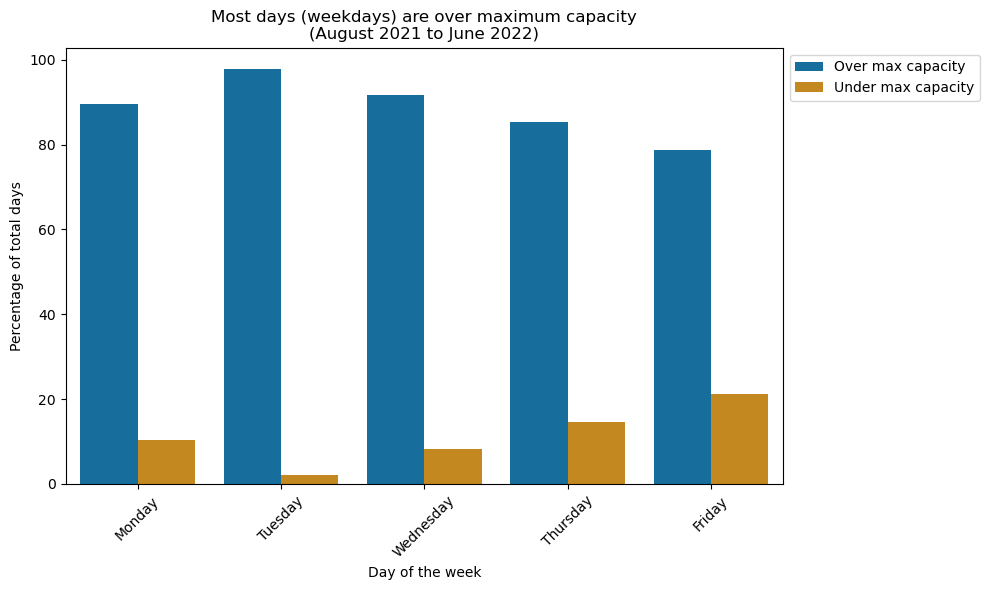

In [421]:
# Create bar chart.
standard_vertical_bar_chart(nc_ex_weekends_capacity_count, "day_of_week", "percentage",
                            title="Most days (weekdays) are over maximum capacity\n(August 2021 to June 2022)",
                            x_label="Day of the week", y_label="Percentage of total days", 
                            hue="Capacity", order=day_order_weekdays, palette="colorblind")

All days of the week had more days over max capacity than under but Tuesday was the worst and Friday the best.

37. Line chart showing the number of appointments for each duration of appointment from December 2021 to June 2022 (range of this data set).

In [424]:
ad.head(2)

icb_ons_code sub_icb_location_code  \
0    E54000050                   00L   
1    E54000050                   00L   

                        sub_icb_location_name appointment_date  year month  \
0  NHS North East and North Cumbria ICB - 00L       2021-12-01  2021   Dec   
1  NHS North East and North Cumbria ICB - 00L       2021-12-01  2021   Dec   

  actual_duration  count_of_appointments region_ons_code  \
0   31-60 Minutes                    364       E40000012   
1   21-30 Minutes                    619       E40000012   

  sub_icb_location_ons_code                  Region  Season  
0                 E38000130  North East & Yorkshire  Winter  
1                 E38000130  North East & Yorkshire  Winter

In [425]:
# Create a appointment_month column.
ad["appointment_month"] = ad["appointment_date"].dt.to_period('M')
ad.head(2)

icb_ons_code sub_icb_location_code  \
0    E54000050                   00L   
1    E54000050                   00L   

                        sub_icb_location_name appointment_date  year month  \
0  NHS North East and North Cumbria ICB - 00L       2021-12-01  2021   Dec   
1  NHS North East and North Cumbria ICB - 00L       2021-12-01  2021   Dec   

  actual_duration  count_of_appointments region_ons_code  \
0   31-60 Minutes                    364       E40000012   
1   21-30 Minutes                    619       E40000012   

  sub_icb_location_ons_code                  Region  Season appointment_month  
0                 E38000130  North East & Yorkshire  Winter           2021-12  
1                 E38000130  North East & Yorkshire  Winter           2021-12

In [426]:
# Group by appointment month.
group_ad_month = ad.groupby(["appointment_month", "actual_duration"])["count_of_appointments"].sum().reset_index()
group_ad_month.head(5)

appointment_month actual_duration  count_of_appointments
0           2021-12     1-5 Minutes                4266686
1           2021-12   11-15 Minutes                3280132
2           2021-12   16-20 Minutes                2023774
3           2021-12   21-30 Minutes                1885864
4           2021-12   31-60 Minutes                1163515

In [427]:
# Create an average count of appointments per day column.
# Also divide by a thousand so that the y axis will be more readable. So divide by 30*1000
group_ad_month["av_app_per_day"] = group_ad_month["count_of_appointments"]/30000
group_ad_month.head(5)

appointment_month actual_duration  count_of_appointments  av_app_per_day
0           2021-12     1-5 Minutes                4266686      142.222867
1           2021-12   11-15 Minutes                3280132      109.337733
2           2021-12   16-20 Minutes                2023774       67.459133
3           2021-12   21-30 Minutes                1885864       62.862133
4           2021-12   31-60 Minutes                1163515       38.783833

In [428]:
# Change "appointment_month" to a string data type.
group_ad_month.dtypes

appointment_month        period[M]
actual_duration             object
count_of_appointments        int64
av_app_per_day             float64
dtype: object

In [429]:
# Change appointment_month to a string.
group_ad_month["appointment_month"] = group_ad_month["appointment_month"].astype(str)
group_ad_month.dtypes

appointment_month         object
actual_duration           object
count_of_appointments      int64
av_app_per_day           float64
dtype: object

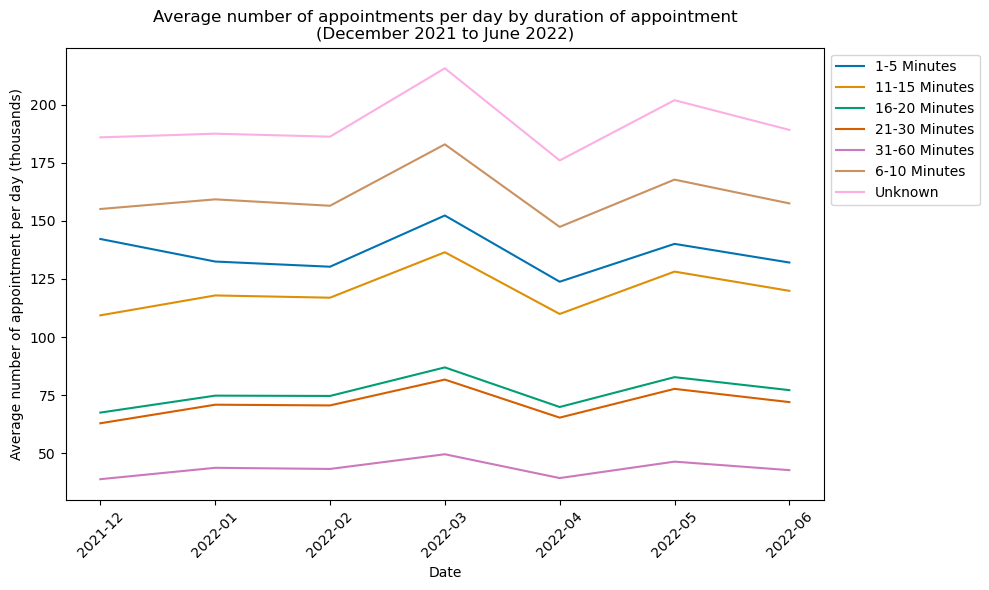

In [430]:
# Create a line plot.
standard_line_plot(group_ad_month, "appointment_month", "av_app_per_day", 
                   title="Average number of appointments per day by duration of appointment\n(December 2021 to June 2022)", 
                   x_label="Average number of appointment per day (thousands)", y_label="Date", hue="actual_duration", palette="colorblind")

The trend is similar from December 2021 to June 2022 across the different appointment durations.

38. Bar chart showing the percentage of apppointments that were attended and not attended by hcp_type.

In [433]:
ar.head(2)

icb_ons_code appointment_month appointment_status hcp_type appointment_mode  \
0    E54000034           2020-01           Attended       GP     Face-to-Face   
1    E54000034           2020-01           Attended       GP     Face-to-Face   

  time_between_book_and_appointment  count_of_appointments month  year  \
0                             1 Day                   8107   Jan  2020   
1                    15  to 21 Days                   6791   Jan  2020   

       Region  Season  
0  South East  Winter  
1  South East  Winter

In [434]:
# View the filtered data frame (July 2021 to June 2022).
ar_filtered_202122.head(3)

icb_ons_code appointment_month appointment_status hcp_type  \
3462    E54000034           2021-07           Attended       GP   
3463    E54000034           2021-07           Attended       GP   
3464    E54000034           2021-07           Attended       GP   

     appointment_mode time_between_book_and_appointment  \
3462     Face-to-Face                             1 Day   
3463     Face-to-Face                    15  to 21 Days   
3464     Face-to-Face                       2 to 7 Days   

      count_of_appointments month  year  
3462                   7120   Jul  2021  
3463                   2460   Jul  2021  
3464                  11477   Jul  2021

In [435]:
# Group by appointment_status and hcp_type
group_app_status_hcp = ar_filtered_202122.groupby(["appointment_status", "hcp_type"])["count_of_appointments"].sum().reset_index()
group_app_status_hcp

appointment_status              hcp_type  count_of_appointments
0           Attended                    GP              152869112
1           Attended  Other Practice staff              132159219
2           Attended               Unknown                9390364
3     Did not attend                    GP                4143188
4     Did not attend  Other Practice staff                9907123
5     Did not attend               Unknown                 297738
6            Unknown                    GP                4697658
7            Unknown  Other Practice staff                7499995
8            Unknown               Unknown                 821592

In [436]:
# Add a total number of appointments per appointment_status column.
total_app_status= group_app_status_hcp.groupby("appointment_status")["count_of_appointments"].sum().reset_index()
total_app_status

appointment_status  count_of_appointments
0           Attended              294418695
1     Did not attend               14348049
2            Unknown               13019245

In [437]:
# Rename "count_of appointments".
total_app_status.rename(columns={"count_of_appointments":"total_appointments"}, inplace=True)
total_app_status

appointment_status  total_appointments
0           Attended           294418695
1     Did not attend            14348049
2            Unknown            13019245

In [438]:
# Merge total_app_month with group_ar_filtered_202122_attended.
group_ar_filtered_202122_status_merge = group_app_status_hcp.merge(total_app_status, how="left", on="appointment_status")
group_ar_filtered_202122_status_merge

appointment_status              hcp_type  count_of_appointments  \
0           Attended                    GP              152869112   
1           Attended  Other Practice staff              132159219   
2           Attended               Unknown                9390364   
3     Did not attend                    GP                4143188   
4     Did not attend  Other Practice staff                9907123   
5     Did not attend               Unknown                 297738   
6            Unknown                    GP                4697658   
7            Unknown  Other Practice staff                7499995   
8            Unknown               Unknown                 821592   

   total_appointments  
0           294418695  
1           294418695  
2           294418695  
3            14348049  
4            14348049  
5            14348049  
6            13019245  
7            13019245  
8            13019245

In [439]:
# Create a percentage column.
group_ar_filtered_202122_status_merge["percentage"] = \
(group_ar_filtered_202122_status_merge["count_of_appointments"]/group_ar_filtered_202122_status_merge["total_appointments"]) * 100

group_ar_filtered_202122_status_merge

appointment_status              hcp_type  count_of_appointments  \
0           Attended                    GP              152869112   
1           Attended  Other Practice staff              132159219   
2           Attended               Unknown                9390364   
3     Did not attend                    GP                4143188   
4     Did not attend  Other Practice staff                9907123   
5     Did not attend               Unknown                 297738   
6            Unknown                    GP                4697658   
7            Unknown  Other Practice staff                7499995   
8            Unknown               Unknown                 821592   

   total_appointments  percentage  
0           294418695   51.922352  
1           294418695   44.888189  
2           294418695    3.189459  
3            14348049   28.876316  
4            14348049   69.048572  
5            14348049    2.075111  
6            13019245   36.082415  
7            13019245   57.606989  
8            13019245    6.310596

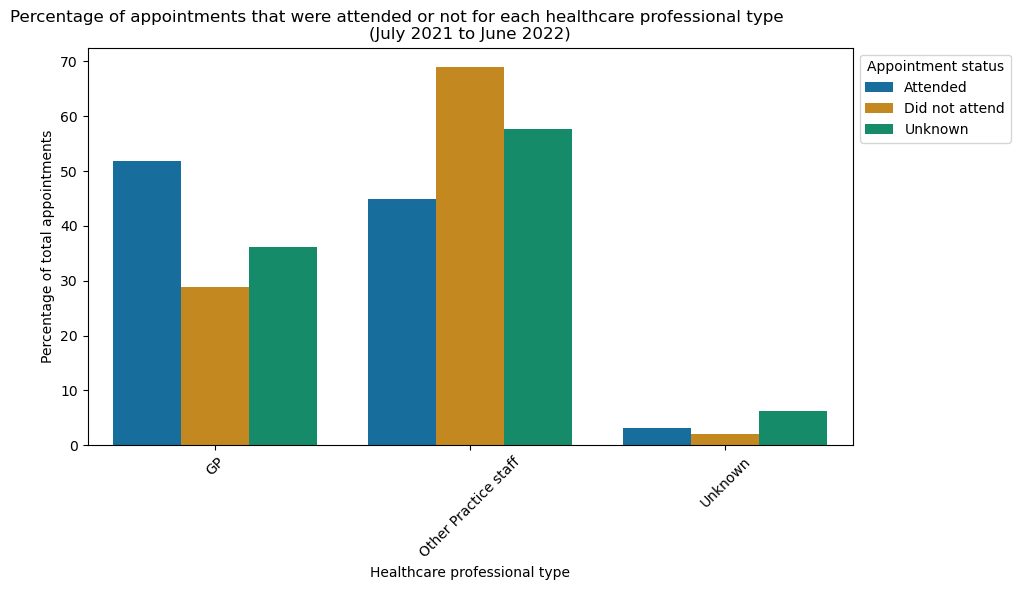

In [440]:
# Create bar chart.
standard_vertical_bar_chart(group_ar_filtered_202122_status_merge, "hcp_type", "percentage",
                            title="Percentage of appointments that were attended or not for each healthcare professional type\
                            \n(July 2021 to June 2022)",
                            x_label="Healthcare professional type", y_label="Percentage of total appointments", 
                            legend_title="Appointment status", hue="appointment_status", palette="colorblind")

More appointments may be attended if it's conducted by a GP but it's difficult to say for certain because of the large number of unknowns.

### Analysing the Twitter data

In [443]:
# Set macimum column width of the DataFrame to 200.
pd.options.display.max_colwidth=200

In [462]:
# Load the tweet csv file.
tweets = pd.read_csv("tweets.csv")
tweets.head(5)

tweet_id  \
0  1567629223795527681   
1  1567582846612553728   
2  1567582787070304256   
3  1567582767625428992   
4  1567582720460570625   

                                                                                                                                                                                           tweet_full_text  \
0  As Arkansas’ first Comprehensive Stroke Certified Center, UAMS provides Arkansans with access to the most advanced stoke care. Join us in our mission to make a difference in the health and well-be...   
1                                                              RT @AndreaGrammer: Work-life balance is at the foundation of how decisions are made and where #PremiseHealth is headed.  We're #hiring for…   
2                                                           RT @OntarioGreens: $10 billion can go a long way to fixing our broken #Healthcare system.\n\nYet Doug Ford would rather spend it ALL on a hig…   
3                                                             RT @modrnhealthcr: 🚨#NEW:🚨 Insurance companies are figuring out the best ways to collect information about members’ race and ethnicity data…   
4  ICYMI: Our recent blogs on Cybersecurity in Accounting https://t.co/4nnK0FiVVL and Digital Transformation in Healthcare Finance https://t.co/jIqn52lHD3 are a great read, take a look!\n\n#blogs #di...   

                                                                                                                                                                                            tweet_entities  \
0  {'hashtags': [{'text': 'Healthcare', 'indices': [253, 264]}], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/yw0cstfmSI', 'expanded_url': 'https://bit.ly/3BiSKbs', 'display_url...   
1  {'hashtags': [{'text': 'PremiseHealth', 'indices': [94, 108]}, {'text': 'hiring', 'indices': [127, 134]}], 'symbols': [], 'user_mentions': [{'screen_name': 'AndreaGrammer', 'name': 'Andrea Grammer...   
2  {'hashtags': [{'text': 'Healthcare', 'indices': [70, 81]}], 'symbols': [], 'user_mentions': [{'screen_name': 'OntarioGreens', 'name': 'Green Party of Ontario', 'id': 37115912, 'id_str': '37115912'...   
3  {'hashtags': [{'text': 'NEW', 'indices': [20, 24]}], 'symbols': [], 'user_mentions': [{'screen_name': 'modrnhealthcr', 'name': 'Modern Healthcare', 'id': 18935711, 'id_str': '18935711', 'indices':...   
4  {'hashtags': [{'text': 'blogs', 'indices': [184, 190]}, {'text': 'digitaltransformation', 'indices': [191, 213]}, {'text': 'cybersecurity', 'indices': [214, 228]}, {'text': 'accounting', 'indices'...   

                                                              tweet_entities_hashtags  \
0                                                                         #Healthcare   
1                                                             #PremiseHealth, #hiring   
2                                                                         #Healthcare   
3                                                                                #NEW   
4  #blogs, #digitaltransformation, #cybersecurity, #accounting, #finance, #healthcare   

                                         tweet_metadata  tweet_retweet_count  \
0  {'iso_language_code': 'en', 'result_type': 'recent'}                    0   
1  {'iso_language_code': 'en', 'result_type': 'recent'}                    2   
2  {'iso_language_code': 'en', 'result_type': 'recent'}                   39   
3  {'iso_language_code': 'en', 'result_type': 'recent'}                    5   
4  {'iso_language_code': 'en', 'result_type': 'recent'}                    0   

   tweet_favorite_count  tweet_favorited  tweet_retweeted tweet_lang  
0                     0            False            False         en  
1                     0            False            False         en  
2                     0            False            False         en  
3                     0            False            False         en  
4           

In [464]:
# Explore the data set with the describe function.
tweets.describe()

tweet_id  tweet_retweet_count  tweet_favorite_count
count  1.174000e+03          1174.000000            1174.00000
mean   1.567612e+18             8.629472               0.37138
std    2.427553e+13            29.784675               2.04470
min    1.567574e+18             0.000000               0.00000
25%    1.567590e+18             0.000000               0.00000
50%    1.567611e+18             1.000000               0.00000
75%    1.567633e+18             3.000000               0.00000
max    1.567655e+18           303.000000              42.00000

In [466]:
# Explore the data set with the info function.
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174 entries, 0 to 1173
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   tweet_id                 1174 non-null   int64 
 1   tweet_full_text          1174 non-null   object
 2   tweet_entities           1174 non-null   object
 3   tweet_entities_hashtags  1007 non-null   object
 4   tweet_metadata           1174 non-null   object
 5   tweet_retweet_count      1174 non-null   int64 
 6   tweet_favorite_count     1174 non-null   int64 
 7   tweet_favorited          1174 non-null   bool  
 8   tweet_retweeted          1174 non-null   bool  
 9   tweet_lang               1174 non-null   object
dtypes: bool(2), int64(3), object(5)
memory usage: 75.8+ KB


In [468]:
# Explore the tweet_retweet_count and tweet_favourite_count columns.
tweets["tweet_retweet_count"].value_counts().reset_index()

tweet_retweet_count  count
0                     0    526
1                     1    215
2                     2    114
3                     3     70
4                     5     35
5                     4     27
6                     7     18
7                    12     16
8                     8     15
9                    73     14
10                    9     13
11                    6     12
12                  208     12
13                   35     10
14                   37      6
15                   11      6
16                   10      5
17                   53      5
18                   44      4
19                  150      4
20                   63      4
21                   76      3
22                   85      3
23                   41      3
24                   62      3
25                  207      3
26                   68      3
27                   78      2
28                   23      2
29                   24      2
30                   72      2
31                   16      2
32                   13      1
33                   49      1
34                   48      1
35                   15      1
36                  107      1
37                   14      1
38                   79      1
39                   20      1
40                   39      1
41                   19      1
42                  303      1
43                   57      1
44                   40      1
45                   54      1
46                  169      1

Most tweets haven't been retweeted (526) or have only been tweeted once (215). This could mean that for the majority of these tweets, what has been said hasn't been popular/people don't care about what's been said.

In [470]:
tweets["tweet_favorite_count"].value_counts().reset_index()

tweet_favorite_count  count
0                      0   1027
1                      1     91
2                      2     16
3                      3     13
4                      4      7
5                      5      5
6                      6      2
7                     17      1
8                     12      1
9                     10      1
10                     8      1
11                    13      1
12                    11      1
13                     7      1
14                    20      1
15                    28      1
16                    14      1
17                    18      1
18                     9      1
19                    42      1

The vast majority of tweets haven't been favourited.

We could look more at the tweets that have been retweeted and/or favourited a lot, for example the tweet that has been retweeted 208 times.

In [472]:
# Create a new DataFrame with only the text values.
tags = []
for y in [x.split(' ') for x in tweets['tweet_full_text'].values]:
    for z in y:
        if '#' in z:
            tags.append(z.lower())
            
tweets_text = pd.DataFrame(tags, columns=["tweets"])
tweets_text

tweets
0            #healthcare
1         #premisehealth
2                #hiring
3            #healthcare
4                🚨#new:🚨
...                  ...
4328  #mediqueststaffing
4329           #hospital
4330              #shift
4331     (#newportbeach)
4332                #job

[4333 rows x 1 columns]

In [473]:
# Create a Pandas Series to count the values in the list.
tags = tweets_text["tweets"].value_counts().reset_index()

# Display the first 30 records.
tags.head(30)

tweets  count
0                   #healthcare    716
1                       #health     80
2                     #medicine     41
3                           #ai     40
4                          #job     38
5                      #medical     35
6                     #strategy     30
7               #pharmaceutical     28
8                #digitalhealth     25
9                       #pharma     25
10                   #marketing     25
11                  #medtwitter     24
12                     #biotech     24
13     #competitiveintelligence     24
14                       #meded     23
15                     #vaccine     18
16                      #hiring     18
17                        #news     17
18             #machinelearning     17
19                  #technology     17
20                 #coronavirus     16
21             #womeninmedicine     16
22                       #covid     16
23        #competitivemarketing     16
24                    #wellness     15
25                  #healthtech     15
26  #doctorofveterinarymedicine     14
27                     #science     14
28                    #medicare     14
29                     #covid19     14

In [474]:
# Convert the tags series to a data frame.
twitter_df = pd.DataFrame(tags)

In [475]:
twitter_df.head(5)

tweets  count
0  #healthcare    716
1      #health     80
2    #medicine     41
3          #ai     40
4         #job     38

In [476]:
# Rename "tweets" to "word".
twitter_df.rename(columns={"tweets":"word"}, inplace=True)
twitter_df.head(5)

word  count
0  #healthcare    716
1      #health     80
2    #medicine     41
3          #ai     40
4         #job     38

In [477]:
# Ensure the count data type is an integer for data analysis.
twitter_df.dtypes

word     object
count     int64
dtype: object

In [478]:
# Sense-check the DataFrame.
twitter_df.describe()

count
count  1754.000000
mean      2.470353
std      17.462844
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max     716.000000

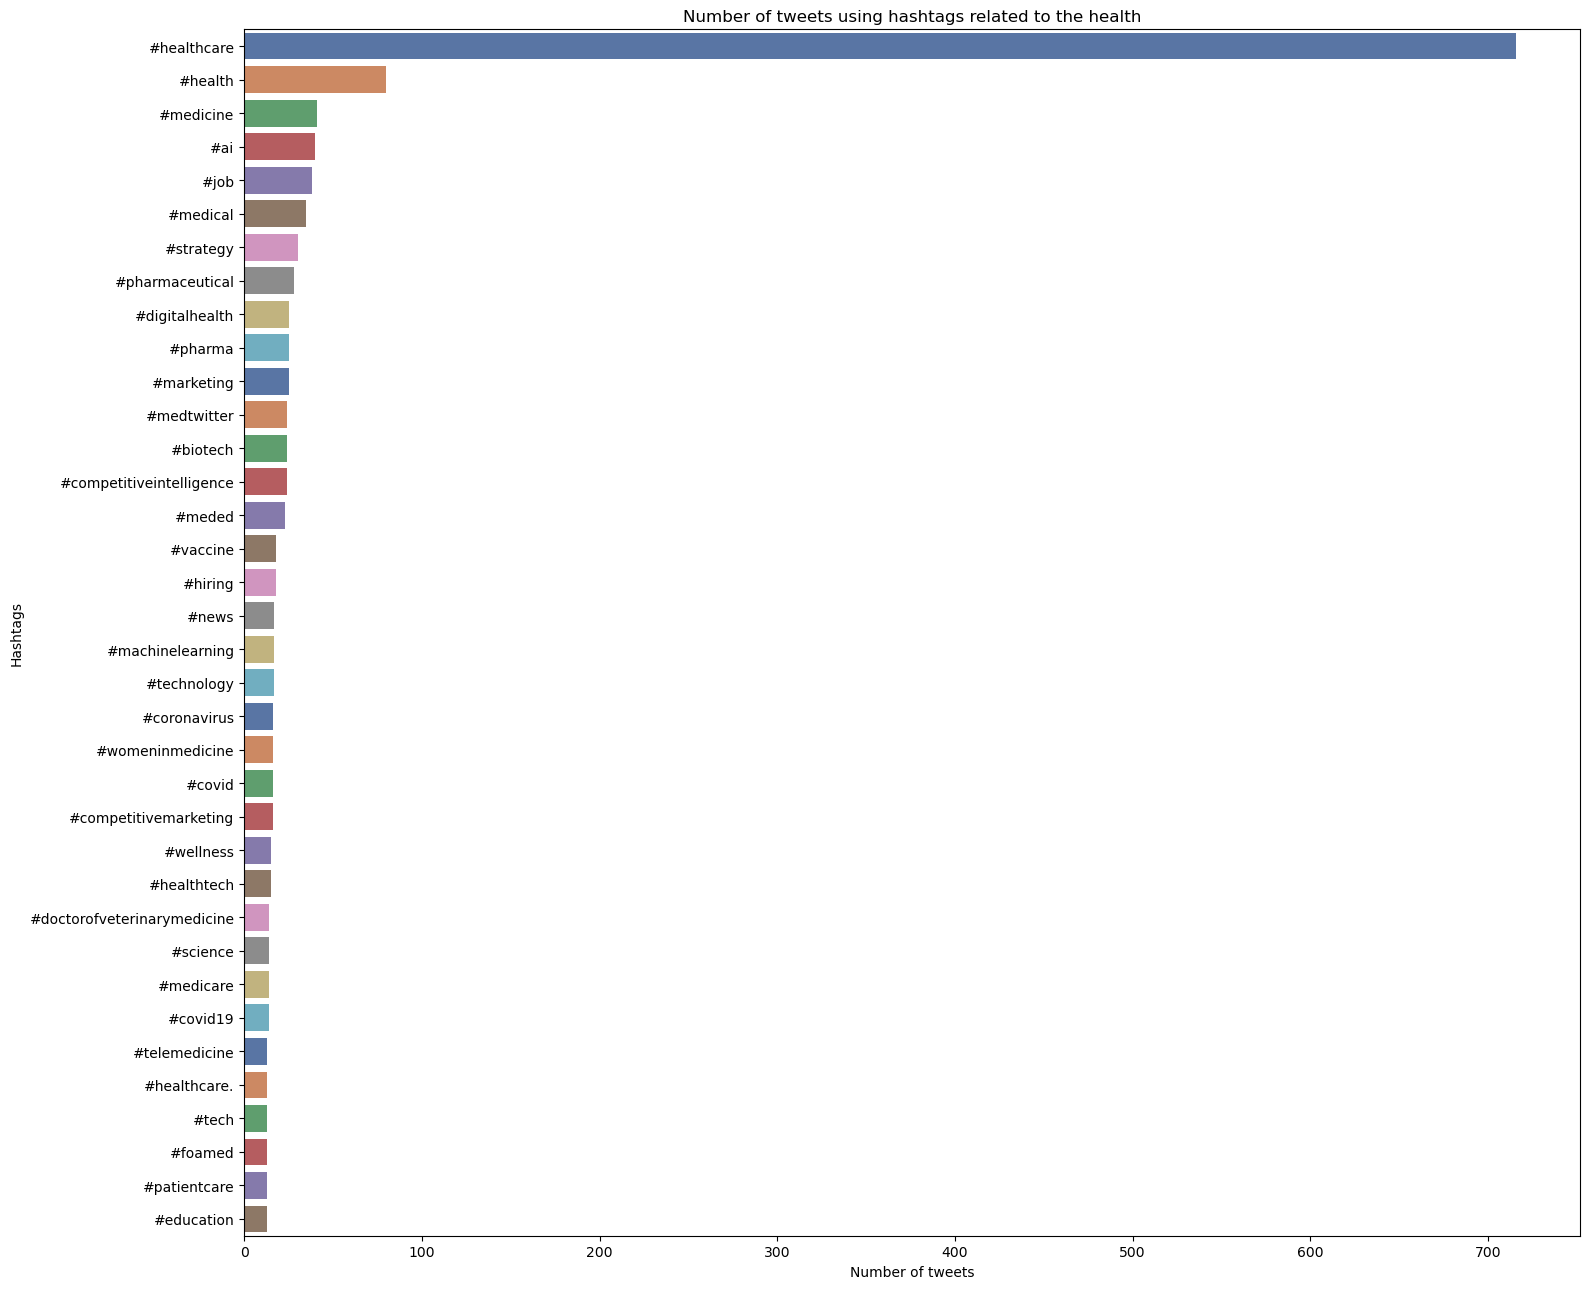

In [480]:
# Create a barplot of all records with a count>12. I'm not using 10 because not all the hashtags fit on the y axis.
twitter_df_filtered = twitter_df[twitter_df["count"]>12]

standard_horizontal_bar_chart(twitter_df_filtered, "word", "count", 
                              title="Number of tweets using hashtags related to the health", 
                              x_label="Hashtags", y_label="Number of tweets", palette="deep", 
                              figsize=(16,13))

How tweets can be utilised to provide feedback to stakeholders (https://www.businessnewsdaily.com/7488-twitter-for-business.html):
- Filter by hashtags (like I've done above). Then determine which are the most popular, such as which hashtags are used the most and how many retweets and likes there are for each hashtag.
- If a tweet is found which can be useful for a stakeholder, there is the potential to tag them by using the @ symbol.
- Twitter bookmarks can be used to save tweets so that they can easily found later. This could be useful as useful tweets can quickly be bookmarked to be referenced later.
- You can directly message people who've posted a tweet to ask them more questions about their opinions.
- You can follow accounts that mention the NHS and healthcare frequently so that these posts appear in your feed.
- You can create a private list of other users who you find interesting that you can look at whenever you want.

Whether the tweets add value to the overall project:
- Not in its current form as just by looking at the intial data I imported, I can already see that these tweets reference other countries and subjects other than NHS England. I would web scrape (or connect to the API if it's needed) and search for relevant hashtags like #NHS, #NHSEngland, or #NHSGPs so that it would be more likely that the results are relevant. We can see from the graph above that the most referenced hashtag was #healthcare but we do not know what percentage of these were about NHS England.

The NHS can utilise tweets by gauging public opinion. However, what is on Twitter (now X) may not be representative of overall public opinion as there can be a tendency for exaggeration of opinions and perhaps certain political biases. To gauge public opinion, a poll across a variety of demographics would probably be more useful. Although they could use Twitter data to help come up with questions for the poll.